# Imports and plot properties


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlt
import pandas as pd
from pandas import read_excel
from matplotlib.font_manager import FontProperties
from scipy.ndimage.interpolation import shift
import os
import glob
import timeit
from scipy import stats
import statsmodels.stats.api as sms
from matplotlib.collections import LineCollection
from tempfile import TemporaryFile
import matplotlib.gridspec as gridspec
import seaborn as sns
from statannot import add_stat_annotation
try:
    from statannot import add_stat_annotation
except ModuleNotFoundError:
    !conda install statannot
# import numpy_indexed as npi
#print(os.path.dirname(__file__))


#############################   Plot properties   ########################################################


font = FontProperties()
font.set_family('serif')
font.set_name('Times New Roman')
font.set_style('italic')
font.set_size('30')
font.set_weight('bold')

font_label = FontProperties()
font_label.set_family('serif')
font_label.set_name('Times New Roman')
font_label.set_style('italic')
font_label.set_size('25')
font_label.set_weight('bold')

def set_ticks(ax):
    ax.get_xaxis().set_tick_params(direction='out',labelsize = 30,length=10)
    ax.xaxis.set_ticks_position('bottom')
    ax.get_yaxis().set_tick_params(direction='out',labelsize = 30,length=10)
    ax.yaxis.set_ticks_position('left')


# Functions

In [2]:
print(extract_epochs_over_trials.__doc__)

NameError: name 'extract_epochs_over_trials' is not defined

In [47]:
def read_DLC(file_name):
    '''Read DeepLabCut Data.'''
    df = pd.read_excel(file_name, header=[1,2])*scale_pix_to_cm # scale to cm
    return df

def read_laser(laser_file_name):
    '''Read laser onset offset times for Square pulse stimulation'''
    laser_t = pd.read_excel(laser_file_name, skiprows = 4 )
    return laser_t

def read_laser_beta_stim(laser_file_name):
    '''Read laser onset offset times for Beta pulse stimulation'''
    laser_t = pd.read_excel(laser_file_name, skiprows = 4 )
    onset = np.array(laser_t['ON'].values)
    starts = np.where(shift(onset, -1, cval= 0)-onset > min_t_between_stim) # find the starts of sessions if 
                                     # they are not oscilations of a beta wave
    
    temp = np.zeros((len(onset[starts[0]])+1,))
    temp[0] = onset[0] # save the first detected laser as the dtart of the first session

    temp[1:temp.shape[0],]= onset[starts[0]+1] # the rest are as detected above

    df = pd.DataFrame(({'ON':temp,'OFF':temp+interval}))
    return df

def list_all_files(path,extension):
    '''List all the files with this extention in this directory'''
    files = [x for x in os.listdir(path) if not x.startswith('.')]
    files.sort()
    return list(filter(lambda x: extension in x, files))

def convert_csv_to_xlsx(path):
    '''Check if a .xlsx version of all the .csv files exists, if not convert to this format
        and remove the .csv to save space'''
    files = [x for x in os.listdir(path) if not x.startswith('.')]
    files.sort()
    csv_files = list(filter(lambda x: ".csv" in x, files))
    csv_file_names = [x.replace(".csv","") for x in csv_files] # remove extensions to be able to compare lists
    xlsx_files = list(filter(lambda x: extension in x, files))
    xlsx_file_names = [x.replace(".xlsx","") for x in xlsx_files]
    if not set(csv_file_names) < set(xlsx_file_names): # if most files are in csv convert them to xlsx

        for filepath_in in csv_files:
            name = os.path.join(path, filepath_in) 

            try:
                pd.read_csv(name, delimiter=",").to_excel(os.path.join(path, filepath_in.replace(".csv",".xlsx")), header = True,index = False)
            except pd.errors.ParserError: # it must be a laser file
                pd.read_csv(name, delimiter=",",skiprows= 4).to_excel(os.path.join(path, filepath_in.replace(".csv",".xlsx")), startrow=4, header = True, index = False)

            os.remove(name) # remove the csv file.
            

def save_npz(mouse_type,opto_par,folder,pulse_inten,fps, window,n_timebin,file_name_ext,
             epochs_all_mice, epochs_mean_each_mouse, epochs_spont_all_mice,pre_info,
             cor,body_part,plot_param):
    '''Save the trial epochs in one .npz file with the following elements:
        1: all of laser sessions one mouse type
        2: average for each mouse in mouse type
        3: eauivalent number of laser sessions derived from spontaneous'''
    s = '_'
    s = s.join(body_part)

    file_name = (mouse_type+'_'+opto_par+'_'+pulse_inten+file_name_ext+"_mov_aver="+str(int(window/fps*1000))+"_n_t="+
                str(int(n_timebin/fps*1000))+'_'+cor+'_'+plot_param+'_'+s)
    np.savez( os.path.join(pre_direct,'data_npz',folder,opto_par, file_name),
             epochs_all_mice = epochs_all_mice,
             epochs_mean_each_mouse = epochs_mean_each_mouse, 
             epochs_spont_all_mice = epochs_spont_all_mice,
             avg_pre_stim_position = pre_info[:,0],
             avg_pre_stim_velocity = pre_info[:,1],
            avg_pre_stim_acc = pre_info[:,2])
#     dat = np.load(pre_direct+'data_npz/'+file_name+'.npz')
#     dat.files
    
def moving_average_array(X, n):
    '''Return the moving average over X with window n without changing dimesions of X'''
    z2= np.cumsum(np.pad(X, (n,0), 'constant', constant_values=0))
    z1 = np.cumsum(np.pad(X, (0,n), 'constant', constant_values=X[-1]))
    return (z1-z2)[(n-1):-1]/n

def align_right_left(right,left):
    '''Correct if for any reason there has been a shift between labelings of right and left side
    
    Parameters
    ----------
    right : 1-D array
        position in time detected from the right camera
    left : 1-D array
        position in time detected from the left camera
    '''
    delta = np.average(right-left)
    if delta > 0: # if the right is ahead
        right -=delta/2 ; left += delta/2
    else: # if the left is ahead
        right +=delta/2 ; left -= delta/2
    return right,left


def compare_r_l_correct_misdetect (right_p, left_p, acc_deviance,t_s, 
                                   internal_ctr_dev=0,percent_thresh_align=0,n_iter_jitter=0,jitter_threshold=0):
    '''Compare the right and left sides and correct if the difference between 
        the two is more than an acceptable amount. 
        
    
    Parameters
    ----------
    right_p : 1-D array
        position in time detected from the right camera
    left_p : 1-D array
        position in time detected from the left camera
    acc_deviance : float (passed within misdetect dictionary)
        acceptable deviance of the right and left side detections
    t_s : int
        the number of procedeeing and post time bins to average from and correct the misdetection with
    
    There are other parameters passed as a **kwarg that are not used in this function
    
    Returns 
    -------
    
    right : 1-D array
        corrected position in time detected from the right camera
    left : 1-D array
        corrected position in time detected from the left camera
    '''
    right_x = np.copy(right_p); left_x = np.copy(left_p) ### if not it changes the df that was passed to the function along with the right_x and left_x
#     r_x = np.copy(right_x)
#     l_x = np.copy(left_x)
    delta_x = np.absolute(right_x - left_x) # the difference between detections of right and left cameras
    ind, = np.where(delta_x > internal_ctr_dev)
    
    if len(ind)> percent_thresh_align*len(right_x):# if more than a percentage of detections are not aligned there must be a shift
        print("There's a shift between left and right detections. Don't worry we will fix it!")
        right_x, left_x = align_right_left(right_x,left_x)
        
    delta_x = np.absolute(right_x - left_x) 
    mis_r_l, = np.where(delta_x > acc_deviance) # spot where  
    removed_edge_ind = np.logical_and((mis_r_l > t_s+1), (mis_r_l <(len(right_x)-t_s-1)))
    mis_r_l = mis_r_l[removed_edge_ind]
#     print(mis_r_l)
    # spot which is more deviant from it's neghbors in time
    print("# inconsistent right left = ", len(mis_r_l))
#     print("time stamps = ", mis_r_l[(mis_r_l>34.5*fps) & (mis_r_l<35*fps)]/fps)
    if len(mis_r_l) > 0: # only bother if only you find any mismatches
        compare_within_r = np.zeros((delta_x.shape))
        compare_within_l = np.zeros((delta_x.shape))
        bef_r = np.hstack([ np.absolute(np.average(right_x[j-t_s:j-1])-right_x[j])+
                np.absolute(np.average(right_x[j+1:j+t_s])-right_x[j]) for j in mis_r_l ])/2
        bef_l = np.hstack([ np.absolute(np.average(left_x[j-t_s:j-1])-left_x[j])+
                np.absolute(np.average(left_x[j+1:j+t_s])-left_x[j]) for j in mis_r_l ])/2
        compare_within_r[mis_r_l] = bef_r
        compare_within_l[mis_r_l]= bef_l

        ind_right_larger, =np.where(compare_within_l < compare_within_r) 
        ind_left_larger, =np.where(compare_within_l > compare_within_r) 

        temp_r = np.in1d(mis_r_l,ind_right_larger)
        ind_r_corr = mis_r_l[temp_r] # where there's mismatch and it's annonated to the right one
        temp_l = np.in1d(mis_r_l,ind_left_larger)
        ind_l_corr = mis_r_l[temp_l] # where there's mismatch and it's annonated to the left one
        # correct based on the findings
        # set to the average of the other side rather than the same track because there's a better chance the
        # mistake happens again in the proximity of the same side
        if len(ind_l_corr) > 0 :
            left_x[ind_l_corr] = np.hstack([np.average( right_x[j-t_s:j-1] ) +
                                       np.average( right_x[j+1:j+t_s] ) for j in ind_l_corr])/2
        if len(ind_r_corr) > 0 :
            right_x[ind_r_corr] = np.hstack([np.average( left_x[j-t_s:j-1] ) +
                                       np.average( left_x[j+1:j+t_s] ) for j in ind_r_corr])/2

    return np.array(right_x).reshape((-1, 1)), np.array(left_x).reshape((-1, 1))


def correct_labeling_jitter(x,jitter_threshold,n_iter_jitter,t_s,acc_deviance=0,internal_ctr_dev=0,
                                   percent_thresh_align=0):
    '''Correct the detections exceeding the max speed of the mouse.
    
    The detected jitters are replaced by the average of before and after time stamps.
    
    Parameters
    ----------
    x : 1-D array
        The time series that needs correction (usually the average of right and left cameras).
        
    jitter_threshold : float
        The allowed maximum movement in one timebin with the max allowed velocity.
    
    n_iter_jitter : int
        This process can be done several times (n_iter) to make sure if jitters appear with averaging they are resolved.
    
    t_s : int
        The number of timebins to average from when correcting the jitter point.
        
    Returns
    -------
    x : 1-D array
        The corrected time series.
        
    '''
    for i in range(n_iter_jitter):
        deltas = x - shift(x, 1, cval= x[0])
        ind, = np.where(np.absolute(deltas) > jitter_threshold)
        ind = ind[(ind > t_s+1) & (ind <(len(x)-t_s-1))]
        if len(ind) > 0: # if jumped in detection set to the mean of <t_s> previous and next detections
            x[ind] = np.hstack([np.average(x[j-t_s:j-1])+np.average(x[j+1:j+t_s]) for j in ind])/2
            print("# jitter in mean(righ,left)  = ", len(ind))                                     
#     print("nan found? How many? ",sum(np.isnan(x)))
#     print(x[ind])
    return x


def average_position_r_l(df,window,misdetection_dict,cor,body_part,plot_param):
    '''Return three-level correction of the average between right and left side for multiple selected body-parts.
    
    Extract the right and left trace for each selected body part, correct right and left traces with 
    "compare_r_l_correct_misdetect", then average over right and left and remove jitters by calling
    "correct_labeling_jitter". Then return the moving average of all selected body-parts.
    
    Parameters
    ----------
    
    df : dataframe
        Dataframe derived from DLC for one session of one animal
        
    which_plot : int
        Which coordinate to work with. 0-->x or 1-->y
    
    where_plot : list (int)
        Which body parts to average over. list of int that will be translated to list of strings with a dict.
    
    window : int
        Moving average window for smoothing the position time series
        
    misdetection_dict : dictionary
        Dictionary containing constants for misdetection corrections
        
    Returns
    -------
    corrected_averaged : 1-D array 
        Moving average of all selected body-parts.
        
    '''

    averaged_position = np.zeros((df[('r'+body_part[0],cor)].values.shape))
    
    for param in body_part : # average over body parts
        right_x = np.copy(df[('r'+param,cor)].values)
        left_x = np.copy(df[('l'+param,cor)].values)
        right, left = compare_r_l_correct_misdetect(right_x,left_x,**misdetection_dict) #first compare r and l
        left_right_corrected_averaged = np.average(np.concatenate((right,left),axis = 1),axis=1)
        # (this corrects when the misdetection happened for both left and right because
        # left and right have already been aligned together)
        averaged_position += correct_labeling_jitter(left_right_corrected_averaged,**misdetection_dict)
#         averaged_position += correct_labeling_jitter(left_x,jitter_threshold,n_iter_jitter, t_s)

    averaged_position = averaged_position/len(body_part)
    corrected_averaged = moving_average_array(averaged_position, window)
    return  corrected_averaged
   
def position_r_l(df,window,misdetection_dict,cor,body_part,plot_param):
    '''Remove jitters with "correct_labeling_jitter" on right and left on the 
    selected body parts and return right and left separately.
    
    Parameters
    ----------
    
    df : dataframe
        Dataframe derived from DLC for one session of one animal
        
    which_plot : int
        Which coordinate to work with. 0-->x or 1-->y
    
    where_plot : list (int)
        Which body parts to average over. list of int that will be translated to list of strings with a dict.
        
    window : int
        Moving average window for smoothing the position time series
        
    misdetection_dict : dictionary 
        Dictionary containing constants for misdetection corrections
        
    Returns
    -------
    right_corrected : 1-D array 
        Moving average of right side for all selected body-parts
        
    left_corrected : 1-D array 
        Moving average of left side for all selected body-parts
        '''

    
    averaged_position_r = np.zeros((df[('r'+body_part[0],cor)].values.shape))
    averaged_position_l = np.zeros((df[('r'+body_part[0],cor)].values.shape))

    for param in body_part : # average over body parts
        right_x = np.copy(df[('r'+param,cor)].values)
        left_x = np.copy(df[('l'+param,cor)].values)
        averaged_position_l += correct_labeling_jitter(left_x,**misdetection_dict)
        averaged_position_r += correct_labeling_jitter(right_x,**misdetection_dict)

    averaged_position_r = averaged_position_r/len(body_part)
    averaged_position_l = averaged_position_l/len(body_part)
    right_corrected = moving_average_array(averaged_position_r, window)
    left_corrected = moving_average_array(averaged_position_l, window)
    return   right_corrected, left_corrected
   

def derivative(x,delta_t):
    '''Take the derivative with delta_t.'''
    
    derivative_out = (x - shift(x, delta_t, cval= x[0]))/ (delta_t/fps)
    ## got crazy zith keyerror -1 
#     print(derivative_out[-1])
#     return shift(derivative_out,-int(delta_t/2),cval= derivative_out[-1])
    return shift(derivative_out,-int(delta_t/2),cval= derivative_out[len(derivative_out)-1])

def derivative_mov_ave(x,delta_t,window):
    '''Take the derivative with delta_t and do a moving average.'''
    
    derivative_out = (x - shift(x, delta_t, cval= x[0]))/ (delta_t/fps)
    dx_dt = shift(derivative_out,-int(delta_t/2),cval= derivative_out[len(derivative_out)-1])
    return moving_average_array(dx_dt, window_veloc) # return the moving average
#     return dx_dt # if you don't want to do a moving average 


# def detect_remove_jitter(velocity, max_accel = 95):
#     ''' detect when the DLC labeled wrongly by filtering with acceleration criteria
    
#     to do: set the inconsistent one to the average of before and after'''
#     shifted = shift(velocity, 1, cval= velocity[0])
#     accel = (velocity - shifted)/(1/fps)
#     print(np.sort(accel)[-2])
#     print("max accel = ", max(accel), np.argmax(accel)/fps)
#     ind = np.where(np.absolute(accel) > max_accel)
#     print("# jitters in speed = ",len(ind[0]))
#     return velocity

def input_plot(df, laser_t,exp_dict,t_window_dict):
    '''Get the specifics of the plot as input and call the corresponding plot function.'''
    study_param = get_input_cor_body_part(**exp_dict)
 
    print(" 1. Right & Left \n 2. Average")
    Average_sep_plot = int(input()) # ask what body part to plot
    
    if Average_sep_plot == 2:
        print(Average_sep_plot)
        plot_what_which_where(df, laser_t, 
                              **study_param,**t_window_dict)
    else:
        plot_what_which_where_r_l(df, laser_t, 
                                  **study_param,**t_window_dict)
        
def get_input_cor_body_part(cor_list,body_part_list,plot_param_list):
    '''Ask for the body part and coordinate from user.'''
    
    print("Select for which parts you want to see the pre/On/post: \n")
    print(" 1. Tail \n 2. Nose \n 3. Fore Limb \n 4. Hind Limb")
    where_plot = [int(x)-1 for x in input().split()] # ask what body part to plot
    print(" 1. X \n 2. Y ")
    which_plot = int(input())-1 # ask what body part to plot
    print(" 1. Position \n 2. Velocity \n ")
    what_plot = int(input())-1 # ask what body part to plot
    study_param = {'cor' : cor_list[which_plot],
                        'body_part' : body_part_list[where_plot],
                       'plot_param' : plot_param_list[what_plot]}
    return study_param

def produce_random_bins_for_spont(max_time,n_sample,pre_interval,interval,post_interval,max_distance,min_distance,n_trials_spont):
    '''Produce a grid for start of bins then perturb to have randomly 
    spaced trials with a minimum and maximum distance between them.
    
    Parameters
    ----------
    
    max_time : int
        number of timebins of the spontaneous session
        
    n_sample : int
        number of trial samples that needs to be extracted from this session
        
    max_distance : int
        maximum number of timebins between extracted trials
    
    min_distance : int
        minimum number of timebins between extracted trials
        
    Returns
    -------
        
    bins : 2D-array (int)
        an array with two columns each row containing (start,end) of each trial
        
    '''
    
    half_max_distance =int(max_distance/2)
    start = pre_interval + half_max_distance # the first timebin eligible for the start of the first timebin
    end = max_time - (post_interval+interval+half_max_distance) # the last timebin eligible for the start of the last trial 
    time_points = np.arange(start, end-((end-start)%(min_distance+half_max_distance)),min_distance+half_max_distance ) # produce the grid
    perturb = np.random.randint(-half_max_distance,half_max_distance, size = (n_sample,len(time_points))) # produce the random perturbations
    start_arr = np.repeat(time_points.reshape(1,len(time_points)),n_sample,axis = 0)+perturb # perturb the starting points
    starts = (np.array(start_arr.ravel())).reshape(len(start_arr.ravel()),1)
    ends = starts+interval
    bins = np.concatenate((starts,ends),axis = 1) #stack start and ends of bins

    return bins

def extract_epochs(bins,x,smallest_accep_inter,largest_accep_inter,pre_interval,interval,post_interval):
    '''Extract the (pre | Laser ON | post) epochs.
    
    Check reported (start,end) of trials from bins and discard trial with unacceptable duration. 
    Return the stacked the corresponding frames of all trials from the measurment array x.
    
    Parameters
    ----------
    
    bins : 2D-array (int)
        array of start and end times for trials
        
    pre_interval : int
        number of timebins for the pre-laser epoch
    
    post_interval : int
        number of timebins for the post-laser epoch
        
    interval : int
        number of timebins for the laser epoch
    '''
    bins_in = np.copy(bins)
    ### remove the unacceptable epochs
    duration = bins_in[:,1]-bins_in[:,0]
    acceptable = np.logical_and(duration>smallest_accep_inter,duration<largest_accep_inter)

    print("# discarded epochs =",len(acceptable)-sum(acceptable))
    bins_in = bins[acceptable,:]

    ### find the epochs != interval 
    larger_intervals = (duration[acceptable])>interval # find the exterior intervals to the standard interval
    smaller_intervals = (duration[acceptable])<interval # find the inferior intervals to the min interval
    
    # remove or add the extra frames  to make it uniform along the different stimuli
    bins_in[larger_intervals,1] = bins_in[larger_intervals,1] - (bins_in[larger_intervals,1]-bins_in[larger_intervals,0]-interval)
    bins_in[smaller_intervals,1] = bins_in[smaller_intervals,1] + (interval-(bins_in[smaller_intervals,1]-bins_in[smaller_intervals,0]))
    bins_in[:,1] = bins_in[:,0] + interval + post_interval; bins_in[:,0] = bins_in[:,0] - pre_interval  # extend the interval to pre and post
    n_trials = len(bins_in)-1
    take = np.hstack([np.arange(i[0],i[1]+1) for i in bins_in[:-1]]) # make an array with indices of laser ON timebins
    epochs = x[take].reshape(n_trials,pre_interval+post_interval+interval+1)
    
    return epochs,n_trials,take


    

def min_and_mean_on_off(epochs,measure,pre_interval,interval,post_interval,pre_stim_inter):
    '''Report the min or mean (specified by measure) velocity in the off-on periods'''
    
    if measure =='Mean':
        try:
            pre = np.average(epochs[:,0:pre_interval],axis = 1).reshape(epochs.shape[0],1)
            ON = np.average(epochs[:,pre_interval:pre_interval+interval],axis = 1).reshape(epochs.shape[0],1)
            post = np.average(epochs[:,pre_interval+interval:pre_interval+interval+post_interval],axis = 1).reshape(epochs.shape[0],1)

        except ZeroDivisionError:
            pre = np.zeros((epochs.shape[0],1))
            ON = np.zeros((epochs.shape[0],1))
            post = np.zeros((epochs.shape[0],1))
    elif measure =='Min':
        try:
            pre = np.average(epochs[:,0:pre_interval],axis = 1).reshape(epochs.shape[0],1)
            ON = np.min(epochs[:,pre_interval:pre_interval+interval],axis = 1).reshape(epochs.shape[0],1)
            post = np.average(epochs[:,pre_interval+interval:pre_interval+interval+post_interval],axis = 1).reshape(epochs.shape[0],1)
        except ZeroDivisionError:
            pre = np.zeros((epochs.shape[0],1))
            ON = np.zeros((epochs.shape[0],1))
            post = np.zeros((epochs.shape[0],1))
    average_of_on_off_on = np.concatenate((pre, ON, post), axis = 1)
    return average_of_on_off_on

def plot_what_which_where_r_l(df,laser_t,cor,body_part,plot_param,
                              fps,n_timebin,window_pos,window_veloc):
    '''Choose which body part/
                what measure/
                for x or y
        to see the left vs. right traces
    '''
    label_1 = "Right" 
    label_2 = "left "



    param = plot_param[0]
    
    
    if plot_param == 'velocity':
        
        velocity_r = derivative_mov_ave(df[('r'+param,cor)], n_timebin, window_veloc)
        velocity_l = derivative_mov_ave(df[('l'+param,cor)], n_timebin, window_veloc)
        plt.plot(time_series+n_timebin/fps, velocity_r, 'navy',label = label_1, linewidth = 0.8)
        plt.plot(time_series+n_timebin/fps, velocity_l, 'orangered',label = label_2, linewidth = 0.8)
        plt.xlim(n_timebin/fps, trial_time/2)
        plt.ylabel(cor+ " Velocity (cm/s)" ,fontproperties=font_label)
        min_end = min(min(velocity_r),min(velocity_l))
        max_end = max(max(velocity_r),max(velocity_l))
        plt.axhline(y = 0, color = 'r',linestyle= '--', linewidth = 0.9) # plot zero velocity threshold
        
    elif plot_param == "acceleration":
        
        accel_r = derivative_mov_ave(derivative_mov_ave(df[('r'+param,cor)],n_timebin,window_veloc),
                                     n_timebin,window_veloc)
        accel_l = derivative_mov_ave(derivative_mov_ave(df[('l'+param,cor)],n_timebin,window_veloc),
                                     n_timebin,window_veloc)
        t_shift = n_timebin/fps/2
        plt.plot(time_series+t_shift+t_shift, accel_r, 'navy',label = label_1, linewidth = 0.8)
        plt.plot(time_series+t_shift+t_shift, accel_l, 'orangered',label = label_2, linewidth = 0.8)
        plt.xlim(t_shift+t_shift, trial_time/2)
        plt.ylabel(cor+ " Acceleration (cm/s2)" ,fontproperties=font_label)
        min_end = min(min(accel_r),min(accel_l))
        max_end = max(max(accel_r),max(accel_l))
        plt.axhline(y = 0, color = 'r',linestyle= '--', linewidth = 0.9) # plot zero velocity threshold
        
    else:
        
        r,l = compare_r_l_correct_misdetect (df[('r'+param,cor)].values, df[('l'+param,cor)].values, acc_deviance, t_s)
        plt.plot(time_series, r-5, 'k',  marker = 'o', label = label_1,markersize=1)
        plt.plot(time_series, l-5, 'g', label = label_2, marker = 'o', linewidth = 0.8, markersize=1)

        plt.plot(time_series, df[('r'+param,cor)], 'navy',  marker = 'o', label = label_1,markersize=1)
        plt.plot(time_series, df[('l'+param,cor)], 'orangered', label = label_2, marker = 'o', linewidth = 0.8, markersize=1)
        

        plt.xlim(min_x,max_x)
        plt.ylim(min_y,max_y)

        plt.ylabel(cor+ " (cm)" ,fontproperties=font_label)
        min_end = min(min(df[('r'+param,cor)]),min(df[('l'+param,cor)]))
        max_end = max(max(df[('r'+param,cor)]),max(df[('l'+param,cor)]))
            
        
    plt.xlabel("Time(s)" ,fontproperties=font_label)
    plt.title(plot_param+' #'+str(mouse_no)+'\n'+param,fontproperties=font)
    plt.legend(fontsize = 20)
#     plt.ylim(min_end,max_end)
    for i in range(len(laser_t['ON'].values)):
        plt.axvspan(laser_t['ON'].values[i]/fps, laser_t['OFF'].values[i]/fps, alpha=0.2, color='orange')
#     plt.vlines(laser_t['ON']/fps,min_end,max_end, color = 'orange', linewidth = 0.4) # plot stimulus onsets
#     plt.vlines(laser_t['OFF']/fps,min_end,max_end, color = 'orange', linewidth = 0.4) # plot stimulus offsets

    plt.savefig(os.path.join(pre_direct,"One_session",'Mouse_trial'+str(trial_no)+'_mouse_' +str(mouse_no)+'_'+
                param + '_' + plot_param + '_' +cor+ '.png'),bbox_inches='tight',orientation='landscape',dpi=300)



def plot_what_which_where(df,laser_t, misdetection_dict, cor,body_part,plot_param,
                         fps,n_timebin,window_pos,window_veloc):
    '''Choose to see averaged velocity, position or acceleration for a chosen combination of body_parts
        for either x or y coordiante.
    '''

    averaged_pos = average_position_r_l(df,window_pos,misdetection_dict,cor,body_part,plot_param)

    time_series  = df.index / fps
    trial_time = max(time_series)
    
    if plot_param == "velocity":
        
        velocity = derivative_mov_ave(averaged_pos,n_timebin,window)
        plt.plot(time_series+n_timebin/fps/2, velocity, 'k', linewidth = 2, label = body_part_list[where_plot]) # plot all body
        plt.xlim(35,65)
        plt.ylabel(cor+ " Velocity (cm/s)" ,fontproperties=font_label)
        min_end = min(velocity)
        max_end = max(velocity)
        plt.axhline(y = 0, color = 'r',linestyle= '--', linewidth = 0.9) # plot zero velocity threshold
    
    elif plot_param == "acceleration":
        
        accel = derivative_mov_ave(derivative_mov_ave(averaged_pos,n_timebin,window),n_timebin,window)
        t_shift = n_timebin/fps/2
        plt.plot(time_series+t_shift+t_shift, accel, 'k', linewidth = 2, label = body_part_list[where_plot]) # plot all body
        plt.xlim(t_shift+t_shift, trial_time/2)
        plt.ylabel(cor+ " Acceleration (cm/(s2))" ,fontproperties=font_label)
        min_end = min(accel)
        max_end = max(accel)
        plt.axhline(y = 0, color = 'r',linestyle= '--', linewidth = 0.9) # plot zero velocity threshold
        
    else:
        plt.plot(time_series, averaged_pos, '-k', linewidth = 1, label = body_part_list[where_plot],markersize = 1) # plot all body        
        plt.xlim(min_x,max_x)
        plt.ylabel(cor+ " (cm)" ,fontproperties=font_label)
        min_end = min(averaged_pos)
        max_end = max(averaged_pos)
        
    ax.get_xaxis().set_tick_params(direction='out',labelsize = 20)
    ax.xaxis.set_ticks_position('bottom')
    ax.get_yaxis().set_tick_params(direction='out',labelsize = 20)
    ax.yaxis.set_ticks_position('left')
    
    plt.xlabel("Time(s)" ,fontproperties=font_label)
    plt.title("Average "+plot_param+' #'+str(mouse_no)+"\n"+mouse_type+" "+opto_par,fontproperties=font)
    plt.legend(fontsize = 20)
    plt.ylim(min_end,max_end)
    for i in range(len(laser_t['ON'].values)):
        plt.axvspan(laser_t['ON'].values[i]/fps, laser_t['OFF'].values[i]/fps, alpha=0.4, color='lightskyblue')
#     plt.vlines(laser_t['ON']/fps,min_end,max_end, color = 'darkskyblue', linewidth = 0.4) # plot stimulus onsets
#     plt.vlines(laser_t['OFF']/fps,min_end,max_end, color = 'darkskyblue', linewidth = 0.4) # plot stimulus offsets
    plt.savefig(os.path.join(pre_direct,"One_session",'Mouse_trial'+str(trial_no)+'_mouse_' +str(mouse_no)+'_' +cor+ '_' +
                plot_param+ '_averaged_all_body.png'),bbox_inches='tight',orientation='landscape',dpi=300)


 ###################  looking at the pre/on/post stimulus behavior #########################
def plot_pre_on_post(mouse_type,opto_par,epochs,epochs_spont,
                     fps, cor,body_part,plot_param,
                     pre_interval,interval,post_interval,pre_stim_inter,
                    average,c_laser,c_spont):
    '''Plot (pre Laser/ON-Laser/post Laser) velocity/position/acceleration comparison between 
    laser trials and spontaneous'''
    
#     epochs_mean = np.average(epochs, axis = 0) # average over different stimuli
#     epochs_mean_spont = np.average(epochs_spont, axis = 0) # average over different stimuli
    
#     epochs_sem = stats.sem(epochs, axis=0) # SEM 
#     epochs_sem_spont = stats.sem(epochs, axis=0) # SEM 

    confidence_inter = np.empty((0,2), int)
    
    if len(epochs.shape) > 1 :
        epochs_mean = np.average(epochs, axis = 0)
        epochs_mean_spont = np.average(epochs_spont, axis = 0)
        
        for i in range (epochs.shape[1]): #calculate the two sided confidence interval for every timestep
            m = [sms.DescrStatsW(epochs[:,i]).tconfint_mean(alpha=0.05, alternative='two-sided')]
            confidence_inter = np.append(confidence_inter,[[m[0][0],m[0][1]]],axis=0)
        confidence_inter_spont = np.empty((0,2), int)
        
        for i in range (epochs_spont.shape[1]):
            m = [sms.DescrStatsW(epochs_spont[:,i]).tconfint_mean(alpha=0.05, alternative='two-sided')]
            confidence_inter_spont = np.append(confidence_inter_spont,[[m[0][0],m[0][1]]],axis=0)
    else:
        epochs_mean = epochs
        epochs_mean_spont = epochs_spont
        confidence_inter = np.zeros(((epochs_mean.shape[0]),2))
        confidence_inter_spont = np.zeros((epochs_mean.shape[0],2))
    time_series = np.arange(-pre_interval,interval+post_interval+1)/fps
    
    plt1,=plt.plot(time_series, epochs_mean, color = c_laser, label = body_part, linestyle='-',linewidth=2)#, marker='o',markersize=1)
    plt.fill_between(time_series, confidence_inter[:,0],  confidence_inter[:,1], color=c_laser, alpha=0.2)
    
    plt2,=plt.plot(time_series, epochs_mean_spont, color = c_spont, label = "Spontaeous")
    plt.fill_between(time_series, confidence_inter_spont[:,0],  confidence_inter_spont[:,1], color=c_spont, alpha=0.2)
    plt.axvspan(0, interval/fps, alpha=0.2, color='lightskyblue')
    
#     plt.fill_between(time_series, epochs_mean - epochs_sem,  epochs_mean+ epochs_sem,
#                     color='gray', alpha=0.2)
#     plt.fill_between(time_series, epochs_mean_spont - epochs_sem_spont,  epochs_mean_spont+ epochs_sem_spont,
#                    color='b', alpha=0.2)

    if plot_param == 'velocity':
        plt.ylabel(" Velocity (cm/s)").set_fontproperties(font_label)
    else:
        plt.ylabel(" Position (cm)").set_fontproperties(font_label)
        
    plt.axhline( y = treadmil_velocity, ls='--', c='red')
    
    plt.xlabel("Time(s)").set_fontproperties(font_label)
    plt.ylim(min_y_pre_post,max_y_pre_post) #set limits
    plt.legend(fontsize = 10)
#     plt.xlim(-.5,2) #set limits
    s = '_'
    s = s.join(body_part)
    if average == 'n':
        ax.get_xaxis().set_tick_params(direction='out',labelsize = 20 ,length=6)
        ax.xaxis.set_ticks_position('bottom')
        ax.get_yaxis().set_tick_params(direction='out',labelsize = 20, length=6)
        ax.yaxis.set_ticks_position('left')
        plt.title(plot_param+"("+mouse_type+") #"+str(mouse_no) +" "+opto_par+"\n").set_fontproperties(font)
        plt.savefig(os.path.join(pre_direct,'Compare','Mouse'+str(mouse_no)+'_'+folder+"_"+opto_par+'_'+mouse_type+'_'+plot_param
                    +'_timebin_'+str(n_timebin)+'_window_'+str(window)+'_pre_post_stim.png'),bbox_inches='tight',orientation='landscape',dpi=300)
    elif average == 'Averg_trials': # one one mouse
        plt.title("("+mouse_type+") #"+str(mouse_no) +" "+opto_par+"\n"+folder).set_fontproperties(font)
#         plt.title(" #"+str(mouse_no) +" "+mouse_type , fontproperties=font)
#         plt.savefig(pre_direct+'Compare'+'/'+average+'_Mouse'+str(mouse_no)+'_'+folder+"_"+opto_par+'_'+mouse_type+'_'+ cor+ '_Velociy_' +str(n_timebin)+ 'spont_sampl='+str(no_sample)+'_pre_post_stim.png',bbox_inches='tight',orientation='landscape',dpi=400)
    else:
        ax.get_xaxis().set_tick_params(direction='out',labelsize = 20 ,length=6)
        ax.xaxis.set_ticks_position('bottom')
        ax.get_yaxis().set_tick_params(direction='out',labelsize = 20, length=6)
        ax.yaxis.set_ticks_position('left')
        plt.legend(handles=[plt1,plt2],labels=['Laser Stimulation','Spontaneous'],loc = 'lower right',fontsize =20)
        plt.title( mouse_type+"\n"+" Average of all "+opto_par).set_fontproperties(font)

        plt.savefig(os.path.join(path,'average'+'_'+folder+"_"+opto_par+'_'+mouse_type+'_'+ cor+ '_'+plot_param+'_' +s+'_'+
                    str(n_timebin)+'_pre_post_stim.pdf'),bbox_inches='tight',
                    orientation='landscape',dpi=300)

def epochs_single_file(file_name_pos,file_name_spont,file_name_laser):
    '''Read a single file for a mouse and return the epochs.'''
    
    df = read_DLC(file_name_pos)
    df_spont = read_DLC(file_name_spont)
    laser_t = read_laser(file_name_laser)


    time_series  = df.index / fps ## time axis in seconds for stimulation trial
    trial_time = max(time_series)

    time_series_spont  = df_spont.index / fps ## time axis in seconds for spontaneous activity
    trial_time_spont = max(time_series_spont)

    velocity = derivative(average_position_r_l(df,window_pos,misdetection_dict,**study_param).values,n_timebin)  # velocity
    bins  = np.array(laser_t.values).astype(int)
    epochs = extract_epochs(bins,velocity,*accep_interval_range,**intervals_dict)
    velocity_spont = derivative(average_position_r_l(df_spont,window_pos,misdetection_dict, **study_param).values,n_timebin)  # velocity 
    bins_spont  = np.array(laser_t.values).astype(int) # for now
    epochs_spont = extract_epochs(bins,velocity_spont,*accep_interval_range,**intervals_dict)
    return epochs,epochs_spont


def extract_pre_laser_x_epochs_over_trials(files_list,files_list_laser,
                                           direct,folder,study_param,smallest_accep_inter,largest_accep_inter,
                                           back_front_boundary,v_threshold,pre_stim_inter):
    '''Return all the x positions in epochs preceding to a ON-laser of all trials for one mouse.'''

    i = 0
    epochs = np.empty((0,pre_stim_inter))

    for i in range(0,len(files_list)):
        
        print('x number of session = {} out of {}'.format(i+1,len(files_list)))
        file_path_DLC = os.path.join(direct,folder,'DLC',files_list[i])
        df = read_DLC(file_path_DLC)
        x_average = average_position_r_l(df,window_pos,misdetection_dict, **study_param) # x positions
        file_path_Laser = os.path.join(direct,folder,'Laser',files_list_laser[i])
        laser_t = read_laser(file_path_Laser)
        bins  = np.copy(laser_t.values).astype(int)
        duration = bins[:,1]-bins[:,0]
        acceptable = np.logical_and(duration>smallest_accep_inter,duration<largest_accep_inter)
        print("# x discarded epochs =",len(acceptable)-sum(acceptable))
        bins = bins[acceptable,:]
        
        take = np.hstack([np.arange(i[0]-pre_stim_inter,i[0]) for i in bins[:-1]]) # make an array with indices of laser ON 
        pre_x_series = x_average[take]
        # calculate the x position relative to the front edge of the treadmill
        epochs_trial = np.absolute(pre_x_series-max(pre_x_series)).reshape(len(bins)-1,pre_stim_inter)        
        epochs = np.append(epochs,epochs_trial,axis = 0)
#         print("x = ",epochs_trial.shape)
    return epochs


    
def plot_every_mouse_mean(epochs_mean_each_mouse):
    '''plot mean of each mouse for epochs OFF-ON-OFF'''
    
    for i in range (epochs_mean_each_mouse.shape[0]):
        plt.plot(median,epochs_mean_each_mouse[i,:],'-',color = 'gray',marker = '.')

def violin_plot_summary(data_init,names,measure):
    ''' plot violin plot for different columns in data'''

    def set_axis_style(ax, labels):
        ax.get_xaxis().set_tick_params(direction='out')
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xticks(np.arange(1, len(labels) + 1))
        ax.set_xticklabels(labels)
        ax.set_xlim(0.25, len(labels) + 0.75)
        ax.set_xlabel('Time Epoch')

    # transform the data into list as to be fed to the violin plot function
    data = list([data_init[:,i] for i in range(data_init.shape[1])])
    fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(20, 10), sharey=True)

    ax2.set_title(mouse_type)
    parts = ax2.violinplot(data, widths=0.3, showmeans=False, showmedians=False,showextrema=False)

    for pc in parts['bodies']:
        pc.set_facecolor('teal')
        pc.set_edgecolor('None')
        pc.set_alpha(.4)

    quartile1, medians, quartile3 = np.percentile(data, [25, 50, 75], axis=1)

    inds = np.arange(1, len(medians) + 1)
    confidence_inter = np.empty((0,2), int)

    for i in range (data_init.shape[1]): #calculate the two sided confidence interval for every timestep
        m = [sms.DescrStatsW(data_init[:,i]).tconfint_mean(alpha=0.05, alternative='two-sided')]
        confidence_inter = np.append(confidence_inter,[[m[0][0],m[0][1]]],axis=0)

    ax2.scatter(inds,np.average(data_init,axis=0), marker='o', color='white', s=20, zorder=3, label = 'Means') # measns
    ax2.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=2, label = 'Quartiles') # quartiles

    ax2.errorbar(inds, np.average(data_init,axis=0),yerr=confidence_inter.T,fmt='none', elinewidth=2, capsize=7,marker='o', color='r',label = '95% Confidence interval') # confidence interval

#     ax2.boxplot(inds, data)
#     ax2.vlines(inds, np.min(data_init,axis=0), np.max(data_init,axis=0), color='r', linestyle='-', lw=1,label = 'Whiskers')
# 
    # set style for the axes
    set_axis_style(ax2, names)
    print(epochs_mean_each_mouse.shape)
    
    # plot each mouse data individually on top of the summary of all
    if measure == 'Mean':
        for i in range (epochs_mean_each_mouse.shape[0]):
            plt.plot(inds,epochs_mean_each_mouse[i,:],'-',color = 'gray',marker = 'o',fillstyle='none',markersize=10,linewidth=2,alpha=0.6)
    elif measure == 'Min':
        for i in range (epochs_min_each_mouse.shape[0]):
            plt.plot(inds,epochs_min_each_mouse[i,:],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
            
    plt.subplots_adjust(bottom=0.15, wspace=0.05)
    plt.ylabel(" Velocity (cm/s)", fontproperties=font_label)
    plt.xlabel("Epoch", fontproperties=font_label)
    plt.ylim(-16,30) #set limits
    plt.title(cor+ " "+measure+" Velocity"+"\n"+mouse_type+' '+opto_par +"\n"+folder, fontproperties=font)
    plt.legend(fontsize = 20)
    plt.savefig(os.path.join(pre_direct,'Summary','Aver_of_pre_stim_post'+opto_par+'_'+folder+'_'+mouse_type+
                             '_'+ cor+'_'+measure+ '_Velociy_' +str(n_timebin)+'_violin_plot'+'.png'),bbox_inches='tight',orientation='landscape',dpi=400)


def plot_two_protocols_with_mouse_distinction(mouse_type, mouse_list,folder1,folder2,opto_par):
    '''Extract data over all mice of one group in two folders intensity and plot with subplots of individual animals'''
    epochs_spont_all_mice = np.empty((0,pre_interval+interval+post_interval+1))
    epochs_all_mice = np.empty((0,pre_interval+interval+post_interval+1))
#     epochs_mean_each_mouse = np.empty((0,3)) # array storing the average of each period (OFF-ON-OFF) for all the mice
    epochs_spont_all_mice_1 = np.empty((0,pre_interval+interval+post_interval+1))
    epochs_all_mice_1 = np.empty((0,pre_interval+interval+post_interval+1))
#     epochs_mean_each_mouse = np.empty((0,3)) # array storing the average of each period (OFF-ON-OFF) for all the mice

#     epochs_min_each_mouse = np.empty((0,3)) # array storing the average of each period (OFF-ON-OFF) for all the mice
    plt.figure(2)
    fig = plt.figure(figsize=(20,15))
    nrows=3;ncols=4
#     fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15), sharey=True)

    count = 0
    if opto_par == "Control":
        loop_list = mouse_list[1]
    else:
        loop_list = mouse_list[0]

    for n in loop_list: # Run over all the mice
        count +=1
        start = timeit.default_timer()
        global mouse_no
        mouse_no = n
        print("type ="+mouse_type+" #",n)
        direct = os.path.join(pre_direct, mouse_type, opto_par, 'Mouse_' +str(mouse_no))  # directory to the folder for each mouse
#         print(direct+folder)
#         convert_csv_to_xlsx(direct+folder+'/DLC')
        files_list_DLC1 = list_all_files(os.path.join(direct,folder,'DLC'),'.xlsx')
#         convert_csv_to_xlsx(direct+folder+'/Laser') # files might be given in csv, this is to unify 
        files_list_Laser1 = list_all_files(os.path.join(direct,folder,'Laser'),'.xlsx')
        files_list_spont1 = list_all_files(os.path.join(direct,folder_spont,'DLC'),'.xlsx')
        files_list_DLC2 = list_all_files(os.path.join(direct,folder,'DLC'),'.xlsx')
#         convert_csv_to_xlsx(direct+folder+'/Laser') # files might be given in csv, this is to unify 
        files_list_Laser2 = list_all_files(os.path.join(direct,folder,'Laser'),'.xlsx')
        files_list_spont2 = list_all_files(os.path.join(direct,folder_spont,'DLC'),'.xlsx')
#         files_list_spont = []
        if len(files_list_DLC1)==0 :
            print("No files for mouse # ",n)
            continue
        elif len(files_list_Laser1)==0 :
            print("No Laser detection for mouse # ",n)
            continue
        else:

            epochs, = extract_epochs_over_trials(files_list_DLC1,files_list_Laser1,direct,folder1,'n',accep_interval_range,
                                                spont_trial_dict,study_param,**intervals_dict,**t_window_dict) 
            print('n epochs',epochs.shape[0])
            epochs_all_mice = np.append(epochs_all_mice, epochs, axis = 0)# construct an array of all the trial epochs of all mice
            no_epochs = epochs.shape[0] # number of epochs extracted for the mouse

            n_spont_sessions = len(files_list_spont1) # number of spont sessions
            global no_sample
            no_sample = int(no_epochs/(n_spont_sessions*n_trials_spont))+1 # number of repeats 
                                        # over a spont file to get the same number of epochs as laser session
            epochs_spont, = extract_epochs_over_trials(files_list_spont1,files_list_Laser1,direct,
                                                       folder_spont,'y',accep_interval_range,
                                                spont_trial_dict,study_param,**intervals_dict,**t_window_dict)
            epochs_spont_all_mice = np.append(epochs_spont_all_mice, epochs_spont, axis = 0) # construct an array of all the spont epochs

            ax = fig.add_subplot(3,4,count)
            plot_pre_on_post(epochs,epochs_spont,t_window_dict['fps'],**study_param,
                             **intervals_dict,average = 'Averg_trials',c_laser = 'deepskyblue',c_spont = 'k')
            
            epochs, = extract_epochs_over_trials(files_list_DLC2,files_list_Laser2,direct,folder2,'n',accep_interval_range,
                                                spont_trial_dict,study_param,**intervals_dict,**t_window_dict) 
            print('n epochs',epochs.shape[0])
            epochs_all_mice = np.append(epochs_all_mice, epochs, axis = 0)# construct an array of all the trial epochs of all mice
            no_epochs = epochs.shape[0] # number of epochs extracted for the mouse

            n_spont_sessions = len(files_list_spont2) # number of spont sessions

            no_sample = int(no_epochs/(n_spont_sessions*n_trials_spont))+1 # number of repeats 
                                        # over a spont file to get the same number of epochs as laser session
            epochs_spont, = extract_epochs_over_trials(files_list_spont2,files_list_Laser2,direct,
                                                       folder_spont,'y',accep_interval_range,
                                                spont_trial_dict,study_param,**intervals_dict,**t_window_dict)
            epochs_spont_all_mice = np.append(epochs_spont_all_mice, epochs_spont, axis = 0) # construct an array of all the spont epochs

            plot_pre_on_post(mouse_type,opto_par,epochs,epochs_spont,t_window_dict['fps'],**study_param,
                             **intervals_dict,average = 'Averg_trials',c_laser = 'mediumseagreen',c_spont = 'hotpink')

    plt.tight_layout()
    
    fig.suptitle(cor+ "-Velocity ("+mouse_type+") "+opto_par+"\n"+" interval = "+ str(n_timebin) , fontproperties=font)
    plt.savefig(os.path.join(pre_direct,'Subplots','All_together_'+folder+"_"+opto_par+'_'+mouse_type+'_'+ cor+ '_'+body_part+'_timebin=' +str(n_timebin)+ "_moving_aver_win="
        +str(window)+ '_spont_sampl='+str(no_sample)+'_pre_post_stim.pdf'),bbox_inches='tight',orientation='landscape',dpi=200)
    plt.show()

    
def MWW_test(result,result_Ctr,mouse_type):
    '''Return two-sided Mann-Whitney test for ON-laser period velocity between Ctr and ChR2.
    
    Parameters
    ----------
    
    result : df
        a data frame containing mean velocity for ChR2 mice.

    result_Ctr : df
        a data frame containing mean velocity for Control mice.
        
    mouse_type : str
        mouse type as a string e.g. FoxP2, D2, Vglut2 ..
    
    Returns
    -------
    
    stat : obj
        MWW stat results
    '''
    x = result_Ctr[(result_Ctr['epoch']=='ON') & (result_Ctr['mouse_type'] == mouse_type)]['mean_velocity'].values
    y = result[(result['epoch']==('ON'+mouse_type)) & (result['mouse_type'] == mouse_type)]['mean_velocity'].values
    stat = stats.mannwhitneyu(x,y)
    print("MWW ChR2 vs. Ctr "+mouse_type+" = ",stat)
    return statt


# def average_pre_x_v_and_save(mouse_type, folder, opto_par,pre_interval,interval,post_interval,pre_stim_inter,back_front_boundary,v_threshold,pre_stim_inter):
#     '''Save data of epochs together with x and v prior to the laser epoch and individal mice to a npz file
#     by running over all mice of one group and one intensity . 
    
#     Parameters
#     ----------
    
#     mouse_type : str
#         mouse type such as 'FoxP2' or ..
    
#     mouse_list : list (int)
#         list of mouse identification numbers
        
#     folder : str
#         the folder with the corresponding experiment protocol e.g. "Square_1_mW".
    
#     opto_par: str
#         "ChR2" --> for ChR2 injected animals
#         "Control" --> for Control group
    
#     '''

#     where_plot,which_plot, what_plot = get_input_cor_body_part() # decide to average over what and coordinates
#     cor = cor_list[which_plot] # gets either x or y by user

#     if pre_interval > pre_stim_inter:
#         pre_era = pre_interval
#     else:
#         pre_era = pre_stim_inter
        
#     epochs_all_mice = np.empty((0,pre_interval+interval+post_interval+1))
#     x_all_mice = np.empty((0,1))
#     mean_pre_vel_all_mice = np.empty((0,1))

#     if opto_par == "Control":
#         loop_list = mouse_no_dict[mouse_type][1]
#     else:
#         loop_list = mouse_no_dict[mouse_type][0]
        
#     count = 0
#     for n in loop_list: # Run over all the mice
#         count +=1
#         start = timeit.default_timer()
#         mouse_no = n
#         print("# mouse = ",mouse_no)
#         direct = os.path.join(pre_direct, mouse_type, opto_par, 'Mouse_' + str(mouse_no)) # directory to the folder for each mouse
#         files_list_DLC = list_all_files(os.path.join(direct,folder,'DLC',".xlsx"))
#         files_list_Laser = list_all_files(os.path.join(direct,folder,'Laser',".xlsx"))
#         if len(files_list_DLC)==0 :
#             print("No files for mouse # ",n)
#             continue
#         elif len(files_list_Laser)==0 :
#             print("No Laser detection for mouse # ",n)
#             continue
#         else:
#             epochs = extract_epochs_over_trials(files_list_DLC,files_list_Laser,direct,folder,'n',accep_interval_range,
#                                                 spont_trial_dict,intervals_dict,**t_window_dict,**exp_dict) 
#             if pre_era > pre_interval:
#                 epochs_all_mice = np.append(epochs_all_mice, epochs[:,pre_stim_inter-pre_interval:], axis = 0)# construct an array of all the trial epochs of all mice
#                 pre_vel = np.average(epochs[:,:pre_stim_inter],axis = 1)
#             else:
#                 epochs_all_mice = np.append(epochs_all_mice, epochs, axis = 0)# construct an array of all the trial epochs of all mice
#                 pre_vel = np.average(epochs[:,pre_interval - pre_stim_inter:pre_era],axis = 1)
#             what_plot = 0 # for x
#             pre_x_position_epochs = extract_pre_laser_x_epochs_over_trials(files_list_DLC,files_list_Laser,direct,folder,
#                                                                            *accep_interval_range, **pre_x_v_dict)
#             pre_x_position = np.average(pre_x_position_epochs[:,:pre_stim_inter],axis = 1)
#             x_all_mice = np.append(x_all_mice,pre_x_position)
#             mean_pre_vel_all_mice = np.append(mean_pre_vel_all_mice,pre_vel)

#             stop = timeit.default_timer()
#             print('run time = ',stop-start)

#     save_npz(mouse_type,opto_par,"Distinction",folder, window,n_timebin,"_pre_x_pre_v_pre_stim_inter="+str(pre_stim_inter),epochs_all_mice, x_all_mice, mean_pre_vel_all_mice,where_plot,which_plot,what_plot,where_plot,**exp_dict)


# def read_npz_return_data_frame(path,pre_interval,post_interval,interval):
#     ''' reads the saved npz and produces a data frame with the following columns'''
    
#     Summary_files_list = list_all_files(path,".npz")
#     col_names =  ['mean_velocity', 'mouse_type', 'optogenetic expression', 'pulse_type','intensity_mW','epoch','velocity']
#     result = pd.DataFrame(columns = col_names)
#     for file in Summary_files_list:
#         print(file)
#         dat = np.load(path+file)
#         properties=file.split("_")
#         epochs = dat[dat.files[0]]
#         n_epochs = epochs.shape[0]
#         ### set the variables of epoch/optogen/pulse type/mouse type/velocity and x of pre stim
#         pre = epochs[:,:pre_interval] ; post = epochs[:,pre_interval+1:pre_interval+interval+1]
#         mouse_type_ = [properties[0]] * n_epochs*2
#         opto_par_ = [properties[1]] * n_epochs*2
#         pulse_ = [properties[2]] * n_epochs*2
#         inten_ = [properties[3]] * n_epochs*2
#         Velocity = dat[dat.files[2]]
#         x = dat[dat.files[1]]
#         x_ = np.concatenate((x,x),axis=0) 
#         Velocity_ = np.concatenate((Velocity,Velocity),axis=0) 
#         try:
#             off_vel = np.average(pre,axis = 1)
#             on_vel = np.average(post,axis = 1)
#             all_ = np.concatenate((off_vel,on_vel),axis = 0)
#         except ZeroDivisionError:
#             all_ = np.empty((0))
#         epoch_off = ['OFF'] * n_epochs
#         epoch_on = ['ON'] * n_epochs
#         epoch_ = epoch_off+epoch_on
#         # append the data of each mouse to a unit dataframe
#         df = pd.DataFrame(({'mean_velocity':all_, 
#                             'mouse_type':mouse_type_, 'optogenetic expression':opto_par_, 'pulse_type':pulse_,
#                             'intensity_mW':inten_,'epoch':epoch_,'velocity':Velocity_,'x':x_}))
#         frames = [result, df]
#         result = pd.concat(frames,ignore_index=True)
#     return result

def read_npz_return_data_frame(path,pre_interval,interval,post_interval,pre_stim_inter):
    '''Read the saved .npz file and produce a data frame with the following columns.'''
    
    Summary_files_list = list_all_files(path,".npz")
    col_names =  ['mean_velocity', 'min_velocity', 'mouse_type', 'optogenetic expression', 'pulse_type','intensity_mW','epoch','velocity']
    result = pd.DataFrame(columns = col_names)
    for file in Summary_files_list:
        print(file)
        dat = np.load(path+file)
        properties=file.split("_")
        epochs = dat[dat.files[0]]
        n_epochs = epochs.shape[0]
        ### set the variables of epoch/optogen/pulse type/mouse type/velocity and x of pre stim
        pre = epochs[:,:pre_interval] ; on = epochs[:,pre_interval+1:pre_interval+interval+1]
        mouse_type_ = [properties[0]] * n_epochs*2
        opto_par_ = [properties[1]] * n_epochs*2
        pulse_ = [properties[2]] * n_epochs*2
        inten_ = [properties[3]] * n_epochs*2
        Velocity = dat[dat.files[2]]
        x = dat[dat.files[1]]
        x_ = np.concatenate((x,x),axis=0) 
        Velocity_ = np.concatenate((Velocity,Velocity),axis=0) 
        try:
            off_vel = np.average(pre,axis = 1)
            on_vel = np.average(on,axis = 1)
            all_mean = np.concatenate((off_vel,on_vel),axis = 0)
        except ZeroDivisionError:
            all_mean = np.empty((0))

        all_min = np.concatenate((np.min(pre,axis = 1),np.min(on,axis = 1)),axis = 0)
        epoch_off = ['OFF'] * n_epochs
        epoch_on = ['ON'] * n_epochs
        epoch_ = epoch_off+epoch_on
        # append the data of each mouse to a unit dataframe
        df = pd.DataFrame(({'mean_velocity':all_mean, 'min_velocity':all_min, 
                            'mouse_type':mouse_type_, 'optogenetic expression':opto_par_, 'pulse_type':pulse_,
                            'intensity_mW':inten_,'epoch':epoch_,'velocity':Velocity_,'x':x_}))
        frames = [result, df]
        result = pd.concat(frames,ignore_index=True)
    return result

def categorize_pre_x_and_v(result,back_front_boundary,v_threshold,pre_stim_inter):
    '''Set threshold to velocity and x position averaged over pre_stim_inter.'''
    
    ind_0 = result['velocity'] < v_threshold
    ind_1 = result['velocity'] > v_threshold
    ind_2 = result['x'] < back_front_boundary
    ind_3 = result['x'] > back_front_boundary
    result.loc[ind_0 ,'velocity'] = 'neg'
    result.loc[ind_1 ,'velocity'] = 'pos'
    result.loc[ind_2 ,'x'] = 'front'
    result.loc[ind_3 ,'x'] = 'back'
    return result

def Plot_ON_OFF_X_V_mean(result,path,mouse_type,folder,back_front_boundary,v_threshold,pre_stim_inter):
    '''Plot the mean laser-ON laser-OFF vellociry with distinction of velocity and x prior to laser stim.'''
    
    result_pos = result[result['velocity'] == 'pos']
    result_neg = result[result['velocity'] == 'neg']
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10), sharey=True)

    y = [np.average(result_pos[(result_pos['x']=='front') & (result_pos['epoch']=='OFF')]['mean_velocity']),\
         np.average(result_pos[(result_pos['x']=='front') & (result_pos['epoch']=='ON')]['mean_velocity'])]
    delta = str(round(y[1]-y[0],2))

    plt.plot(['OFF','ON'],y,'-',\
             color = 'g',marker = 'o',markersize=20,linewidth=4,alpha=1, label = 'V>0 - front-N='+\
             str(len(result_pos[(result_pos['x']=='front') & (result_pos['epoch']=='ON')]['mean_velocity']))+\
             ' $\delta$='+delta)

    y = [np.average(result_pos[(result_pos['x']=='back') & (result_pos['epoch']=='OFF')]['mean_velocity']),\
             np.average(result_pos[(result_pos['x']=='back') & (result_pos['epoch']=='ON')]['mean_velocity'])]
    delta = str(round(y[1]-y[0],2))
    plt.plot(['OFF','ON'],y,'-',
        color = 'r',marker = 'o',markersize=20,linewidth=4,alpha=1, label = 'V>0 - back-N='+\
        str(len(result_pos[(result_pos['x']=='back') & (result_pos['epoch']=='ON')]['mean_velocity']))+\
        ' $\delta$='+delta)

    y = [np.average(result_neg[(result_neg['x']=='front') & (result_neg['epoch']=='OFF')]['mean_velocity']),\
             np.average(result_neg[(result_neg['x']=='front') & (result_neg['epoch']=='ON')]['mean_velocity'])]
    delta = str(round(y[1]-y[0],2))
    plt.plot(['OFF','ON'],y,'-',
        color = 'b',marker = 'o',markersize=20,linewidth=4,alpha=1, label = 'V<0 - front-N='+\
        str(len(result_neg[(result_neg['x']=='front') & (result_neg['epoch']=='ON')]['mean_velocity']))+\
        ' $\delta$='+delta)

    y = [np.average(result_neg[(result_neg['x']=='back') & (result_neg['epoch']=='OFF')]['mean_velocity']),\
             np.average(result_neg[(result_neg['x']=='back') & (result_neg['epoch']=='ON')]['mean_velocity'])]
    delta = str(round(y[1]-y[0],2))
    plt.plot(['OFF','ON'],y,'-',
        color = 'k',marker = 'o',markersize=20,linewidth=4,alpha=1, label = 'V<0 - back-N='+\
        str(len(result_neg[(result_neg['x']=='back') & (result_neg['epoch']=='ON')]['mean_velocity']))+\
        ' $\delta$='+delta)
    inten = result['intensity_mW'][0]
    legend = plt.legend(loc='upper right',fontsize= 20)
    plt.xlabel("Laser").set_fontproperties(font_label), 
    plt.ylabel("Average velocity (cm/s)").set_fontproperties(font_label)
    plt.suptitle(mouse_type+'  '+folder+'(I='+inten+')'+'\n'+'pre-stim-inetrval = '+str(pre_stim_inter*4)+' ms',fontsize= 30,y = 1)
    ax.get_xaxis().set_tick_params(direction='out',labelsize = 20 ,length=6)
    ax.xaxis.set_ticks_position('bottom')
    ax.get_yaxis().set_tick_params(direction='out',labelsize = 20, length=6)
    ax.yaxis.set_ticks_position('left')
    plt.ylim(-20,15)
    ax.set_facecolor((0.8, 1.0, 1.0))
    plt.savefig(os.path.join(path,'X_V_distinction_mean_'+folder+'_pre_stim_t='+str(pre_stim_inter)+
                             '_inten='+inten+'.png'),bbox_inches='tight',orientation='landscape',dpi=350)
    
def Plot_ON_OFF_V_mean(result,path,mouse_type,folder,back_front_boundary,v_threshold,pre_stim_inter):
    '''Plot the mean laser-ON laser-OFF vellociry with distinction of velocity prior to laser stim'''
    
    result_pos = result[result['velocity'] == 'pos']
    result_neg = result[result['velocity'] == 'neg']
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10), sharey=True)

    y = [np.average(result_pos[(result_pos['epoch']=='OFF')]['mean_velocity']),
             np.average(result_pos[(result_pos['epoch']=='ON')]['mean_velocity'])]
    delta = str(round(y[1]-y[0],2))
    yerr = [np.std(result_pos[(result_pos['epoch']=='OFF')]['mean_velocity']),
             np.std(result_pos[(result_pos['epoch']=='ON')]['mean_velocity'])]
    print(yerr)
    plt.errorbar(['OFF','ON'],y,yerr,marker = 'o',markersize=20,linewidth=4,capsize=15,capthick=5,
             color = 'r', label = 'V>0 -N='+
             str(len(result_pos[(result_pos['epoch']=='ON')]['mean_velocity']))+
             ' $\delta$='+delta)

    
    y = [np.average(result_neg[ (result_neg['epoch']=='OFF')]['mean_velocity']),
             np.average(result_neg[(result_neg['epoch']=='ON')]['mean_velocity'])]
    yerr = [np.std(result_neg[(result_neg['epoch']=='OFF')]['mean_velocity']),
             np.std(result_neg[(result_neg['epoch']=='ON')]['mean_velocity'])]
    delta = str(round(y[1]-y[0],2))
    plt.errorbar(['OFF','ON'],y,yerr,marker = 'o',markersize=20,linewidth=5,capsize=15,capthick=5,
        color = 'k', label = 'V<0 -N='+
        str(len(result_neg[ (result_neg['epoch']=='ON')]['mean_velocity']))+
        ' $\delta$='+delta)

    
    inten = result['intensity_mW'][0]
    legend = plt.legend(loc='upper right',fontsize= 25)
    plt.ylim(-20,15)
    plt.xlabel("Laser").set_fontproperties(font_label), 
    plt.ylabel("Average velocity (cm/s)").set_fontproperties(font_label)
    plt.suptitle(mouse_type+'  '+folder+'(I='+inten+')'+'\n'+'pre-stim-inetrval = '+str(pre_stim_inter*4)+' ms',fontsize= 30,y = 1)
    ax.get_xaxis().set_tick_params(direction='out',labelsize = 20 ,length=6)
    ax.xaxis.set_ticks_position('bottom')
    ax.get_yaxis().set_tick_params(direction='out',labelsize = 20, length=6)
    ax.yaxis.set_ticks_position('left')
    
    ax.set_facecolor((1, 1.0, .8))
    plt.savefig(os.path.join(path,'X_V_distinction_mean_'+folder+'_pre_stim_t='+str(pre_stim_inter)+
                             '_inten='+inten+'.png'),bbox_inches='tight',orientation='landscape',dpi=350)
    

def violin_plot_X_V_distiction(result, path,mouse_type,folder,back_front_boundary,v_threshold,pre_stim_inter):
    g = sns.catplot(x="epoch", y="mean_velocity",
                    hue="x", col="velocity",
                    data=result, kind="violin", split=True, palette = sns.color_palette("Set2", n_colors=2, desat=.5),
                     scale_hue=False, linewidth = 2, inner="quartile", scale = 'area',
                    hue_order=['front','back'],col_order=['pos','neg'],legend = False)

    ax1, ax2 = g.axes[0]

    sns.set(font_scale = 2)
    sns.set_style("white")
    plt.ylim([-30,30])

    ax1.axhline( y=0, ls='-', c='y',linewidth = 3)
    ax2.axhline( y=0, ls='-', c='y',linewidth = 3)

    ax1.axhline( y=-15, ls='--', c='r',linewidth = 3)
    ax2.axhline( y=-15, ls='--', c='r',linewidth = 3)

    ax1.set_title('V > 0', y=0.95, fontsize = 25)
    ax2.set_title('V < 0', y=0.95, fontsize = 25)
    inten = result['intensity_mW'][0]
    g.set_axis_labels("Laser", "Average velocity (cm/s)")
    plt.suptitle(mouse_type+'  '+folder+'(I='+inten+')'+'\n'+'pre-stim-interval = '+str(pre_stim_inter*4)+' ms',fontsize= 30,y = 1)
    g.fig.set_figwidth(20.0)
    g.fig.set_figheight(12)
    legend = plt.legend(loc='upper right', title='position on treadmill',fontsize= 20)
    
    plt.savefig(os.path.join(path, mouse_type+'_X_V_violin_plot_'+folder+'_pre_stim_t='+str(pre_stim_inter)
                             +'_inten='+inten+'.png'),bbox_inches='tight',orientation='landscape',dpi=350)

def plot_phase_space_V(result,path,mouse_type,folder,back_front_boundary,v_threshold,pre_stim_inter):
    '''Plot the phase space of laser-ON vs. laser-OFF velocity for all trials of all mice.'''
    result_pos = result[result['velocity'] == 'pos']
    result_neg = result[result['velocity'] == 'neg']
#     result_zero = result[(result['velocity'] != 'neg') & (result['velocity'] != 'pos')]

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10), sharey=True)
    OFF_vel= result_pos[(result_pos['epoch']=='OFF')]['mean_velocity']
    plt.scatter(result_pos[(result_pos['epoch']=='OFF')]['mean_velocity'],
        result_pos[(result_pos['epoch']=='ON')]['mean_velocity'], c='navy',label = r'$V > 0$')
    plt.scatter(result_neg[(result_neg['epoch']=='OFF')]['mean_velocity'],
        result_neg[(result_neg['epoch']=='ON')]['mean_velocity'], c='purple',label = r'$V < 0$')

    inten = result['intensity_mW'][0]
    plt.plot([-40,40],[-40,40], '--', c='k',label = r'$ V_{ON}=V_{OFF}$')
    legend = plt.legend(loc='upper right',fontsize= 20)
    plt.xlabel("Velocity OFF (cm/s)").set_fontproperties(font_label), 
    plt.ylabel("Velocity ON (cm/s)").set_fontproperties(font_label)
    plt.suptitle(mouse_type+'  '+folder+'(I='+inten+')'+'\n'+'pre-stim-interval = '+str(pre_stim_inter*4)+' ms',fontsize= 30,y = 1)
    plt.xlim(-25,32)
    plt.ylim(-30,40)
    ax.get_xaxis().set_tick_params(direction='out',labelsize = 20 ,length=6)
    ax.xaxis.set_ticks_position('bottom')
    ax.get_yaxis().set_tick_params(direction='out',labelsize = 20, length=6)
    ax.yaxis.set_ticks_position('left')
#     ax.set_facecolor((0.8, 1.0, 1.0))
    plt.savefig(os.path.join(path, mouse_type+'_V_phase_space_'+folder+'_pre_stim_t='+str(pre_stim_inter)+
                             '_inten='+inten+'.pdf'),bbox_inches='tight',orientation='landscape',dpi=350)

def extract_epochs_over_trials(files_list,files_list_laser,direct,folder,spont,accep_interval_range,
                               spont_trial_dict,study_param,pre_interval,interval,post_interval,pre_stim_inter,
                               fps,n_timebin,window_veloc,window_pos,no_sample=25):

    '''Return all the epochs of all similar trials for one mouse.
    
    Parameters
    ----------
    
    files_list : list (str)
        List of paths to all DLC .csv files for sessions
        
    files_list_laser : list (str)
        List of paths to all .csv files that have (start,end) laser times.
        
    direct : str
        Path to the parent directory containing all folders
        
    spont : str
        Either 'n' --> for trials containing laser stimulation
        or 'y' --> for spontaneous trials with no laser
    
    no_sample : int (optional)
        Number of samples to extract from one spontaneous session. Only necessary for spont = 'y' cases.
        
    accep_interval_range: tuple (int)
        Smallest and largest acceptable trial sizes in timebins
        
    
    interval_dict : dictionary
        Contains {'pre_interval',interval,'post_interval'}
        Number of timebins for the pre-laser, laser and post-laser epochs
        
    n_timebin : int
        Number of timebins for the x derivative to yiels velocity
    
    window_veloc : int
        Velocity moving average window in timebins
    
    window_pos : int
        Position moving average window in timebins
        
    Returns
    -------
    
    epochs : 2D-array
        (pre | Laser ON | post) epochs with shape (n_trials, pre_interval+post_interval+interval+1)
    
    '''
    if pre_interval > pre_stim_inter:
        pre_era = pre_interval
    else:
        pre_era = pre_stim_inter
        
    plot_param = study_param['plot_param']
#     print( plot_param)
    i = 0

    epochs = np.empty((0,pre_interval+interval+post_interval+1))
    epochs_pos = np.empty((0,pre_stim_inter+interval+post_interval+1))
    epochs_veloc = np.empty((0,pre_stim_inter+interval+post_interval+1))
    epochs_acc = np.empty((0,pre_stim_inter+interval+post_interval+1))
    pre_info = np.empty((0,3))
    for i in range(0,len(files_list)):
        
        print(' number of session = {} out of {}'.format(i+1,len(files_list)))
        file_path_DLC = os.path.join(direct,folder,'DLC',files_list[i])
        df = read_DLC(file_path_DLC)
        
        position = average_position_r_l(df,window_pos,misdetection_dict,**study_param)
        velocity = derivative_mov_ave(position,n_timebin,window_veloc)
        acceleration = derivative(velocity,n_timebin)
        # if only onse side is needed
        #variable,left_side = position_r_l(df, which_plot,where_plot)
        if plot_param == 'position':
            variable = position
            
        elif plot_param == 'velocity':
            variable = velocity   # velocity
            
        elif plot_param == 'acceleration':
            variable = acceleration   # velocity

        if spont == 'y': #if it's a spontaneous reading extract epochs randomly 
            bins = produce_random_bins_for_spont(len(variable),no_sample,pre_interval,interval,post_interval,
                                                 **spont_trial_dict)
            
        else: # if a normal trial read bins from laser times
            file_path_Laser = os.path.join(direct,folder,'Laser',files_list_laser[i])
            laser_t = read_laser(file_path_Laser)
            bins  = np.copy(laser_t.values).astype(int)
        epochs_trial,n_trials,take = extract_epochs(bins,variable,*accep_interval_range,pre_era,interval,post_interval)
        epochs_pos = position[take].reshape(n_trials,pre_era+post_interval+interval+1)
        epochs_veloc = velocity[take].reshape(n_trials,pre_era+post_interval+interval+1)
        epochs_acc = acceleration[take].reshape(n_trials,pre_era+post_interval+interval+1)
        if pre_era > pre_interval:

            pre_info = np.append(pre_info,np.concatenate((np.average(epochs_pos[:,:pre_stim_inter],axis = 1).reshape(-1,1),
                                          np.average(epochs_veloc[:,:pre_stim_inter],axis = 1).reshape(-1,1),
                                          np.average(epochs_acc[:,:pre_stim_inter],axis = 1).reshape(-1,1)),axis=1),axis=0)
            epochs = np.append(epochs,epochs_trial[:,pre_stim_inter-pre_interval:],axis = 0)
        else:
            
            pre_info = np.append(pre_info,np.concatenate((np.average(epochs_pos[:,pre_interval - pre_stim_inter:pre_era],axis = 1).reshape(-1,1),
                                          np.average(epochs_veloc[:,pre_interval - pre_stim_inter:pre_era],axis = 1).reshape(-1,1),
                                          np.average(epochs_acc[:,pre_interval - pre_stim_inter:pre_era],axis = 1).reshape(-1,1)),axis=1),axis=0)
            epochs = np.append(epochs,epochs_trial,axis = 0)
    print(pre_info.shape)

    if plot_param == 'position':
        return epochs- np.repeat(epochs[:,pre_interval].reshape(epochs.shape[0],1),epochs.shape[1],axis = 1)
    else:
        return epochs,pre_info
    
def run_one_intensity_save_data(mouse_type, mouse_list,folder,opto_par,
                                spont_trial_dict,intervals_dict,t_window_dict,study_param,
                                max_distance,min_distance,n_trials_spont):
    '''Save data of epochs and individal mice to a npz file
    by running over all mice of one group and one intensity. 
    
    Parameters
    ----------
    
    mouse_type : str
        mouse type such as 'FoxP2' or ..
    
    mouse_list : list (int)
        list of mouse identification numbers
        
    folder : str
        the folder with the corresponding experiment protocol e.g. "Square_1_mW".
    
    opto_par: str
        "ChR2" --> for ChR2 injected animals
        "Control" --> for Control group
    
    '''
    epochs_spont_all_mice = np.empty((0,intervals_dict['pre_interval']+intervals_dict['interval']+
                                      intervals_dict['post_interval']+1))
    epochs_all_mice = np.empty_like(epochs_spont_all_mice)
    epochs_mean_each_mouse = np.empty((0,3)) # array storing the average of each period (OFF-ON-OFF) for all the mice
#     epochs_min_each_mouse = np.empty((0,3)) # array storing the average of each period (OFF-ON-OFF) for all the mice
    epochs_mean_pre_x = np.empty((0,1))
    epochs_mean_pre_v = np.empty((0,1))
    plt.figure(2)
#     fig = plt.figure(figsize=(20,15))
    fig = plt.figure(figsize=(30,20))

    nrows=3;ncols=4
#     fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15), sharey=True)

    count = 0
    if opto_par == "Control":
        loop_list = mouse_list[1]
    else:
        loop_list = mouse_list[0]

    for n in loop_list: # Run over all the mice
        count +=1
        start = timeit.default_timer()
        global mouse_no
        mouse_no = n
        print("type ="+mouse_type+" #",n)
        direct = os.path.join(pre_direct, mouse_type, opto_par, 'Mouse_' +str(mouse_no)) # directory to the folder for each mouse

        files_list_DLC = list_all_files(os.path.join(direct,folder,'DLC'),'.xlsx')
#         convert_csv_to_xlsx(direct+folder+'/Laser') # files might be given in csv, this is to unify 
        files_list_Laser = list_all_files(os.path.join(direct,folder,'Laser'),'.xlsx')
        files_list_spont = list_all_files(os.path.join(direct,folder_spont,'DLC'),'.xlsx')
#         files_list_spont = []
        if len(files_list_DLC)==0 :
            print("No files for mouse # ",n)
            continue
        elif len(files_list_Laser)==0 :
            print("No Laser detection for mouse # ",n)
            continue
        else:

            epochs,pre_info = extract_epochs_over_trials(files_list_DLC,files_list_Laser,direct,folder,'n',accep_interval_range,
                                                spont_trial_dict,study_param,**intervals_dict,**t_window_dict) 
            print('n epochs',epochs.shape[0])
            epochs_all_mice = np.append(epochs_all_mice, epochs, axis = 0)# construct an array of all the trial epochs of all mice
            no_epochs = epochs.shape[0] # number of epochs extracted for the mouse
            if len(files_list_spont)==0: # if no spont trials recorded set it to zero
                epochs_spont = np.zeros(np.shape(epochs))
                epochs_spont_all_mice = np.append(epochs_spont_all_mice, epochs_spont, axis = 0) # construct an array of all the spont epochs
            else:
                print('spont available')
                n_spont_sessions = len(files_list_spont) # number of spont sessions
                global no_sample
                no_sample = int(no_epochs/(n_spont_sessions*n_trials_spont))+1 # number of repeats 
                                        # over a spont file to get the same number of epochs as laser session
                epochs_spont,blah = extract_epochs_over_trials(files_list_spont,files_list_Laser,direct,folder_spont,'y',accep_interval_range,
                                                          spont_trial_dict,study_param,**intervals_dict,**t_window_dict, no_sample = no_sample)
            print(np.max(epochs_spont))
            epochs_spont_all_mice = np.append(epochs_spont_all_mice, epochs_spont, axis = 0) # construct an array of all the spont epochs
            print("no_spont_epochs= ",epochs_spont.shape[0])
            temp = min_and_mean_on_off(epochs,'Mean',**intervals_dict)# get the mean value of velocity for pre-on-post intervals
            average_of_on_off_on = np.average(temp,axis = 0).reshape(1,3)# average over trialas
            epochs_mean_each_mouse = np.append(epochs_mean_each_mouse,average_of_on_off_on,axis = 0) # construct an array with these 3values for all the mice

            ax = fig.add_subplot(3,4,count)
#             ax = axes[int(count/ncols),count%nrows]
            plot_pre_on_post(mouse_type,opto_par,epochs,epochs_spont,t_window_dict['fps'],**study_param,
                             **intervals_dict,average = 'Averg_trials',
                             c_laser = 'deepskyblue',c_spont = 'k')
            stop = timeit.default_timer()
            print('run time = ',stop-start)
            plt.axhline( y = 17, ls='--', c='g')

    # plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.tight_layout()

#     fig.suptitle(cor+ "-Velocity ("+mouse_type+") "+opto_par+"\n"+" interval = "+ str(n_timebin) , fontproperties=font)
    plt.savefig(os.path.join(pre_direct,'Subplots','All_together_'+folder+"_"+opto_par+'_'+mouse_type+'_'+ study_param['cor']
                             +'_'+study_param['body_part'][0]+'_timebin='+str(t_window_dict['n_timebin'])+ "_moving_aver_win="+str(t_window_dict['window_pos'])+ '_spont_sampl='+str(no_sample)+'_pre_post_stim.pdf'),bbox_inches='tight',orientation='landscape',dpi=200)
    plt.show()

    save_npz(mouse_type,opto_par,folder,folder,t_window_dict['fps'],t_window_dict['window_pos'],t_window_dict['n_timebin'],"",
             epochs_all_mice, epochs_mean_each_mouse, epochs_spont_all_mice,pre_info,**study_param)
    

# Constants

You must input the information bellow regarding the experiment:

In [21]:
video_height = 800
video_width = 1920
fps = 250; # frame per second 
left_edge_x = 115 # one end of treadmil in th eimage reported in pixels
right_edge_x = 1565 # pix
treadmill_len = 37.6 # cm
elec_shock = 3 # electro shock section of the treadmil cm
scale_pix_to_cm = treadmill_len/(right_edge_x-left_edge_x) # one pix in cm
treadmil_velocity = -15 # cm/s
interval_in_sec = 0.5# duration of stimulation in sec
pre_stim_inter = int(0.5*interval_in_sec*fps) # pre stimulus interavl for looking at x ,v and acceleration

n_timebin = 30 # number of frames for calculating velocity 
window_pos = 10 # moving average window for position smoothing
window_veloc = 5 # moving average window for velocity smoothing
max_speed = 28 # (cm/s) the max speed of the mouse derived from recovety of FoxP2 form laser trial

Vglut2_list = ([116, 117, 118, 119, 164, 165, 166],[359, 360]) #first list ChR2 second Control
D2_list = ([156, 165, 166, 195, 196, 198, 199],[172, 178])
FoxP2_list = ([8, 9, 10, 11, 24, 27],[23, 26])

folder_spont = 'Spontaneous'

pre_direct = '/home/shiva/Desktop/Shiva_Behavior/' # ubuntu directory
# pre_direct = '/Users/apple/Desktop/Mouse_locomotion_data'


Run the cell below to infer other constants from the ones you input above

In [27]:
min_t_between_stim = 1*fps, #s minimum time between stimulations (used to distinguish beta stimulations)
accep_interval_range = (int((123/125)*interval_in_sec*fps), int((128/125)*interval_in_sec*fps)) # criteria for discarding the detected laser epochs
mouse_no_dict = {'D2':D2_list, 'Vglut2':Vglut2_list, 'FoxP2':FoxP2_list}

t_window_dict = {'fps' : fps, 'n_timebin' : n_timebin, 'window_pos' : window_pos, 'window_veloc' : window_veloc}

exp_dict = {'cor_list' : np.array(['x', 'y']),
            'body_part_list' : np.array(['Tail', 'Nose', 'FL', 'HL']),
            'plot_param_list' : ['position' , 'velocity', 'acceleration']
           }

spont_trial_dict = {'max_distance' : int(4.5*fps), # max #n_timebines between sampled epochs for spontaneous
                     'min_distance' : int(3*fps), # min #n_timebines between sampled epochs for spontaneous
                     'n_trials_spont' : 25 # the average number of trials extracted from one spontaneous session
                    }

intervals_dict = {'pre_interval' : int(.5*fps), # interval before laser onset
                  'interval' : int(interval_in_sec * fps), # number of timebins of stimulation
                  'post_interval' : int(.5*fps*2), # interval after laser onset
                   'pre_stim_inter' : pre_stim_inter }


pre_x_v_dict = {'back_front_boundary' : (treadmill_len-elec_shock)/2, # set the limit below which is considered back of the treadmill
                'v_threshold' : 0,
                'pre_stim_inter' : pre_stim_inter # number of timebins in the pre-stimulus period 
                 }


misdetection_dict = { 'acc_deviance' : 1.5, # cm = acceptable deviance between right and left detections
                      'internal_ctr_dev' : 0.5,
                      'percent_thresh_align' : 0.8,
                      't_s' : 30, # number of time steps before and after to look at
                      'n_iter_jitter' : 1, # how many times go over data to find jitters and clear them out
                      'jitter_threshold' : max_speed/fps,
                    }

min_y_pre_post = -27 ; max_y_pre_post = 17


# Video dynamic point plot for DLC demo

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
1000
1020
1040
1060
1080
1100
1120
1140
1160
1180
1200
1220
1240
1260
1280


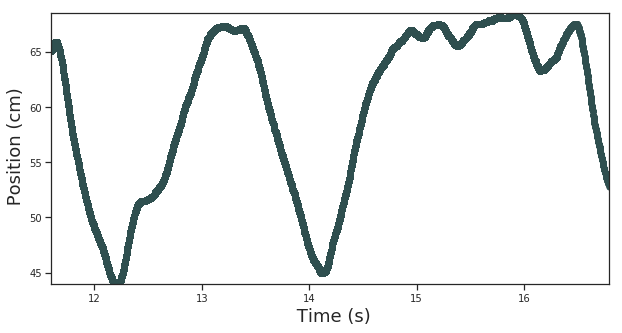

In [67]:
df = pd.read_csv('/media/shiva/LaCie/interesting mouse trials/Mouse_8/MouseFoxP2Cre_#8_SquarePulse_0-25mW_g02_RightDLC_resnet50_Locomotion_Shiva_Mouse_8Jun22shuffle1_250000.csv',header=[1,2])
x = (df['RTail','x'].values+df['RNose','x'].values)*scale_pix_to_cm
start = 2900 ;  stop = 4200
x = x[start:stop]
time_series = np.arange(start,stop)/250
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5), sharey=True)
ax.get_xaxis().set_tick_params(direction='out',labelsize = 10)
ax.xaxis.set_ticks_position('bottom')
ax.get_yaxis().set_tick_params(direction='out',labelsize = 10)
ax.yaxis.set_ticks_position('left')
plt.xlim(min(time_series),max(time_series))
plt.ylim(min(x),max(x))

for i in range(0,stop-start):
    if i%20 == 0:
        print(i)
    plt.plot(time_series[:i], x[:i], '-o', markersize = 5, lw = 1,c = 'darkslategrey')
    plt.ylabel(" Position (cm)",fontsize = 18)
    plt.xlabel(" Time (s)",fontsize = 18)
    plt.savefig('/home/shiva/Desktop/tracking/frame'+str(i).zfill(5)+'.png',bbox_inches='tight',orientation='landscape',dpi=300)

# Run one intensity and save data (all mice and types)

Specify one experiment protocol and intensity by folder together with the coordinate (x,y) and measure (position,velocity). This cell will extract the pre-on-post laser epochs of all mice and will save it together with the same number of spontaneous trials.
The file will contain 3 matrices:
    1. epochs of laser trials.  *size = (number of trials,pre-on-post duration)*
    2. epochs of spontaneous trials. *size = same as above*
    3. mean value for the measurement (x-pos or V) for the three epochs (pre,on,post) for each animal laser. *size = ( number of animals, 3)*

Select for which parts you want to see the pre/On/post: 

 1. Tail 
 2. Nose 
 3. Fore Limb 
 4. Hind Limb
1 2
 1. X 
 2. Y 
1
 1. Position 
 2. Velocity 
 
2
type =FoxP2 # 23
 number of session = 1 out of 4
# inconsistent right left =  0
# jitter in mean(righ,left)  =  161
# inconsistent right left =  0
# jitter in mean(righ,left)  =  202
# discarded epochs = 0
 number of session = 2 out of 4
# inconsistent right left =  0
# jitter in mean(righ,left)  =  135
# inconsistent right left =  49
# jitter in mean(righ,left)  =  377
# discarded epochs = 0
 number of session = 3 out of 4
There's a shift between left and right detections. Don't worry we will fix it!
# inconsistent right left =  0
# jitter in mean(righ,left)  =  90
There's a shift between left and right detections. Don't worry we will fix it!
# inconsistent right left =  0
# jitter in mean(righ,left)  =  140
# discarded epochs = 0
 number of session = 4 out of 4
There's a shift between left and right detections. Don't worry we w

<Figure size 432x288 with 0 Axes>

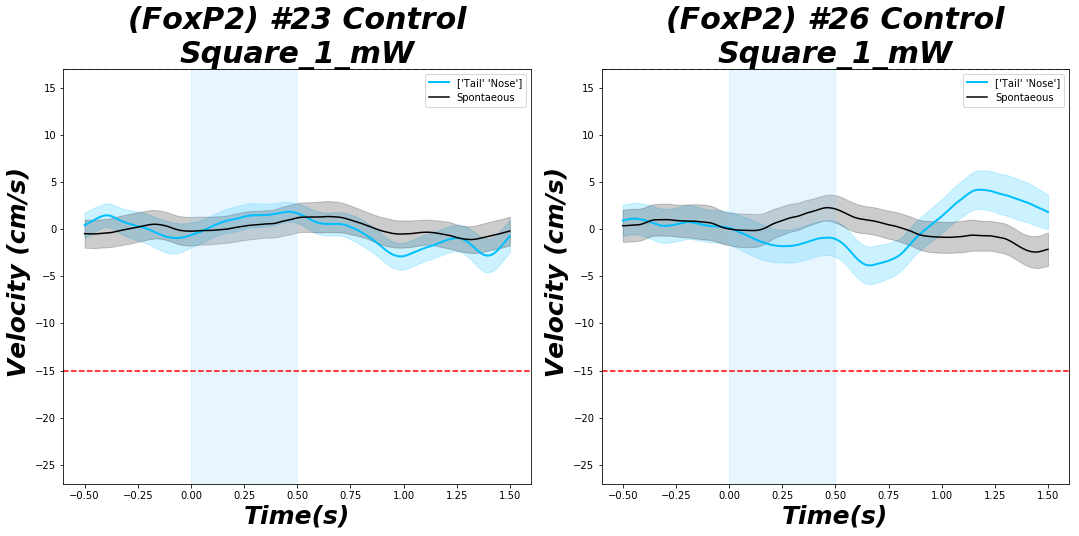

In [43]:
study_param = get_input_cor_body_part(**exp_dict) # decide to average over what and coordinates


# opto_par_list=['ChR2','Control']
opto_par_list=['Control']

mouse_t_list = ['FoxP2','D2','Vglut2']
mouse_t_list = ['FoxP2']

folder = 'Square_1_mW'
# folder = 'GP_15_mW'
# interval = 250# number of timebins of stimulation 


#folder = 'Square_0-25_mW'
# folder = 'Square_0-5_mW'
# folder2 = 'Square_0-5_mW'
# folder1 = 'Square_1_mW'


# folder = 'Beta_5_mW'

for mouse_type in mouse_t_list:  
    
    for opto_par in opto_par_list:
        run_one_intensity_save_data(mouse_type, mouse_no_dict[mouse_type],folder,opto_par,
                                spont_trial_dict,intervals_dict,t_window_dict,study_param,
                                **spont_trial_dict)



# Plots

## Average position or velocity (all the ChR2 mice)

### One intensity
Compare the average of all mice of each mouse type and compare with the equal number of spontaneous trials for one experiment protocol and intensity.

FoxP2_Control_Square_1_mW_mov_aver=40.0_n_t=120.0_x_velocity_Tail_Nose.npz
['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice', 'avg_pre_stim_position', 'avg_pre_stim_velocity', 'avg_pre_stim_acc']


<Figure size 432x288 with 0 Axes>

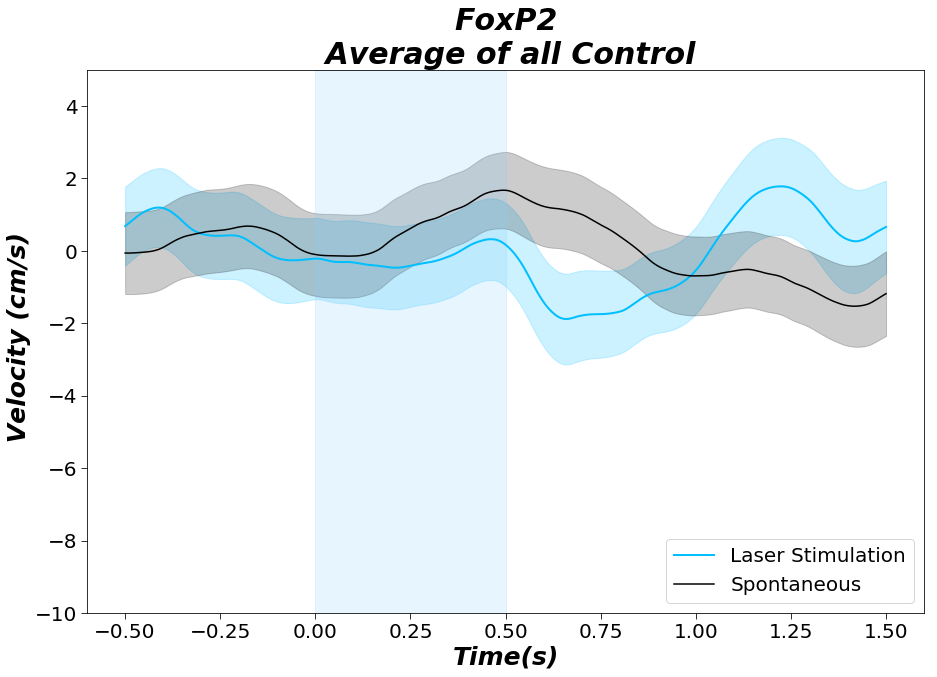

In [48]:
#study_param = get_input_cor_body_part(**exp_dict) # decide to average over what and coordinates

folder = 'Square_1_mW'


path = os.path.join(pre_direct,'data_npz',folder,'Control')
Summary_files_list = list_all_files(path,".npz")
count = 1
min_y_pre_post = -10 ; max_y_pre_post =  5
for file in Summary_files_list:
    count+=1
    print(file)
    dat = np.load(os.path.join(path,file))
    print(dat.files)
    properties=file.split("_")
    epochs_all_mice = dat['epochs_all_mice']
    epochs_spont_all_mice = dat['epochs_spont_all_mice']#*scale_pix_to_cm/1000*fps*fps
#     epochs_spont_all_mice = np.zeros((epochs_all_mice.shape))
    mouse_type = properties[0]
    opto_par = properties[1]
    plt.figure(count)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10), sharey=True)

    plot_pre_on_post(mouse_type,opto_par,epochs_all_mice,epochs_spont_all_mice,t_window_dict['fps'],**study_param,**intervals_dict,
                     average = 'Averg_trials_all_mice',c_laser = 'deepskyblue',c_spont = 'k')
#     plot_pre_on_post(epochs_all_mice,epochs_spont_all_mice,average = 'Averg_trials_all_mice',c_laser = 'mediumseagreen',c_spont = 'hotpink')

# def plot_pre_on_post(epochs,epochs_spont,average,c_laser,c_spont):
#     ''' plot (pre Laser/ON-Laser/post Laser) velocity comparison between active trials and spontaneous'''
    
# #     epochs_mean = np.average(epochs, axis = 0) # average over different stimuli
# #     epochs_mean_spont = np.average(epochs_spont, axis = 0) # average over different stimuli
    
# #     epochs_sem = stats.sem(epochs, axis=0) # SEM 
# #     epochs_sem_spont = stats.sem(epochs, axis=0) # SEM 

#     confidence_inter = np.empty((0,2), int)
    
#     if len(epochs.shape) > 1 :
#         epochs_mean = np.average(epochs, axis = 0)
#         epochs_mean_spont = np.average(epochs_spont, axis = 0)
        
#         for i in range (epochs.shape[1]): #calculate the two sided confidence interval for every timestep
#             m = [sms.DescrStatsW(epochs[:,i]).tconfint_mean(alpha=0.05, alternative='two-sided')]
#             confidence_inter = np.append(confidence_inter,[[m[0][0],m[0][1]]],axis=0)
#         confidence_inter_spont = np.empty((0,2), int)
        
#         for i in range (epochs_spont.shape[1]):
#             m = [sms.DescrStatsW(epochs_spont[:,i]).tconfint_mean(alpha=0.05, alternative='two-sided')]
#             confidence_inter_spont = np.append(confidence_inter_spont,[[m[0][0],m[0][1]]],axis=0)
#     else:
#         epochs_mean = epochs
#         epochs_mean_spont = epochs_spont
#         confidence_inter = np.zeros(((epochs_mean.shape[0]),2))
#         confidence_inter_spont = np.zeros((epochs_mean.shape[0],2))
#     time_series = np.arange(-pre_interval,interval+post_interval+1)/fps
    
#     plt1,=plt.plot(time_series, epochs_mean, color = c_laser, label = '0.5 mW', linestyle='-',linewidth=2)#, marker='o',markersize=1)
#     plt.fill_between(time_series, confidence_inter[:,0],  confidence_inter[:,1], color=c_laser, alpha=0.2)
    
#     plt2,=plt.plot(time_series, epochs_mean_spont, color = c_spont, label = "Spontaeous")
#     plt.fill_between(time_series, confidence_inter_spont[:,0],  confidence_inter_spont[:,1], color=c_spont, alpha=0.2)
#     plt.axvspan(0, interval/fps, alpha=0.2, color='lightskyblue')
    
# #     plt.fill_between(time_series, epochs_mean - epochs_sem,  epochs_mean+ epochs_sem,
# #                     color='gray', alpha=0.2)
# #     plt.fill_between(time_series, epochs_mean_spont - epochs_sem_spont,  epochs_mean_spont+ epochs_sem_spont,
# #                    color='b', alpha=0.2)

#     if plot_param_list[what_plot] == 'velocity':
#         plt.ylabel(" Velocity (cm/s)",fontsize = 30)#.set_fontproperties(font_label)
#     else:
#         plt.ylabel(" Position (cm)",fontsize = 30)#.set_fontproperties(font_label)
        
#     plt.axhline( y = treadmil_velocity, ls='--', c='red')
    
#     plt.xlabel("Time(s)",fontsize = 30)#.set_fontproperties(font_label)
#     plt.ylim(min_y_pre_post,max_y_pre_post) #set limits
#     plt.legend(fontsize = 25)
# #     plt.xlim(-.5,2) #set limits
#     b = body_part_list[where_plot]
#     s = '_'
#     s = s.join(b)
#     if average == 'n':
#         ax.get_xaxis().set_tick_params(direction='out',labelsize = 20 ,length=6)
#         ax.xaxis.set_ticks_position('bottom')
#         ax.get_yaxis().set_tick_params(direction='out',labelsize = 20, length=6)
#         ax.yaxis.set_ticks_position('left')
#         plt.title(plot_param_list[what_plot]+"("+mouse_type+") #"+str(mouse_no) +" "+opto_par+"\n").set_fontproperties(font)
#         plt.savefig(pre_direct+direct_comparison+'/Mouse'+str(mouse_no)+'_'+folder+"_"+opto_par+'_'+mouse_type+'_'+plot_param
#                     +'_timebin_'+str(n_timebin)+'_window_'+str(window)+'_pre_post_stim.png',bbox_inches='tight',orientation='landscape',dpi=300)
#     elif average == 'Averg_trials': # one one mouse
#         plt.title("("+mouse_type+") #"+str(mouse_no) +" "+opto_par+"\n"+folder).set_fontproperties(font)
# #         plt.title(" #"+str(mouse_no) +" "+mouse_type , fontproperties=font)
# #         plt.savefig(pre_direct+direct_comparison+'/'+average+'_Mouse'+str(mouse_no)+'_'+folder+"_"+opto_par+'_'+mouse_type+'_'+ cor+ '_Velociy_' +str(n_timebin)+ 'spont_sampl='+str(no_sample)+'_pre_post_stim.png',bbox_inches='tight',orientation='landscape',dpi=400)
#     else:
#         set_ticks(ax)
# #         plt.legend(handles=[plt1,plt2],labels=['Laser Stimulation'+folder,'Spontaneous'+folder],loc = 'lower right',fontsize =20)
# #         plt.title( mouse_type+"\n"+" Average of all "+opto_par).set_fontproperties(font)

#         plt.savefig(path+'/'+average+'_'+folder+"_"+opto_par+'_'+mouse_type+'_'+ cor+ '_Velociy_' +s+'_'+
#                     str(n_timebin)+ '_mov_ave_win='+str(window)+'_pre_post_stim.pdf',bbox_inches='tight',
#                     orientation='landscape',dpi=300)

# min_y_pre_post = -27 ; max_y_pre_post = 17
# # min_y_pre_post = -10 ; max_y_pre_post =  5

# where_plot,which_plot, what_plot = get_input_cor_body_part() # decide to average over what and coordinates
# cor = cor_list[which_plot] # gets either x or y by user
# # folder = 'Limb_Tail/Square_1_mW'
# # folder = 'Square_1_mW'
# # folder = 'Beta_1_mW'
# folder = 'Beta_0-5_mW'
# # folder = 'Beta_2_mW'
# # folder = 'Beta_5_mW'

# path = os.path.join(pre_direct, 'data_npz', folder, 'ChR2')
# extension_summary = ".npz"
# Summary_files_list = list_all_files(path,extension_summary)
# count = 1
# file = Summary_files_list[0]
# dat = np.load(path+file)
# print(file)
# properties=file.split("_")
# epochs_all_mice = dat['epochs_all_mice']
# epochs_spont_all_mice = dat['epochs_spont_all_mice']#*scale_pix_to_cm/1000*fps*fps
# global mouse_type; global opto_par
# mouse_type = properties[0]
# opto_par = properties[1]
# plt.figure(count)
# folder = '0-5_mW'
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10), sharey=True)
# from matplotlib.ticker import FormatStrFormatter
# ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# set_ticks(ax)
# plot_pre_on_post(epochs_all_mice,epochs_spont_all_mice,average = 'Averg_trials_all_mice',c_laser = 'firebrick',c_spont = 'k')

#D2 blue and grey
#Vglut2 firebrick
#FoxP2 steelblue

### Two intensities
To see the results of two different intensities in the same plot, move your corresponding .npz files to the subfolder "Two_intensities" in the directory ../data_npz. 

Select for which parts you want to see the pre/On/post: 

 1. Tail 
 2. Nose 
 3. Fore Limb 
 4. Hind Limb
3
 1. X 
 2. Y 
1
 1. Position 
 2. Velocity 
 
1
VGlut_ChR2_Square_1_mW_mov_aver=10_n_t=30_x_FL.npz


<Figure size 432x288 with 0 Axes>

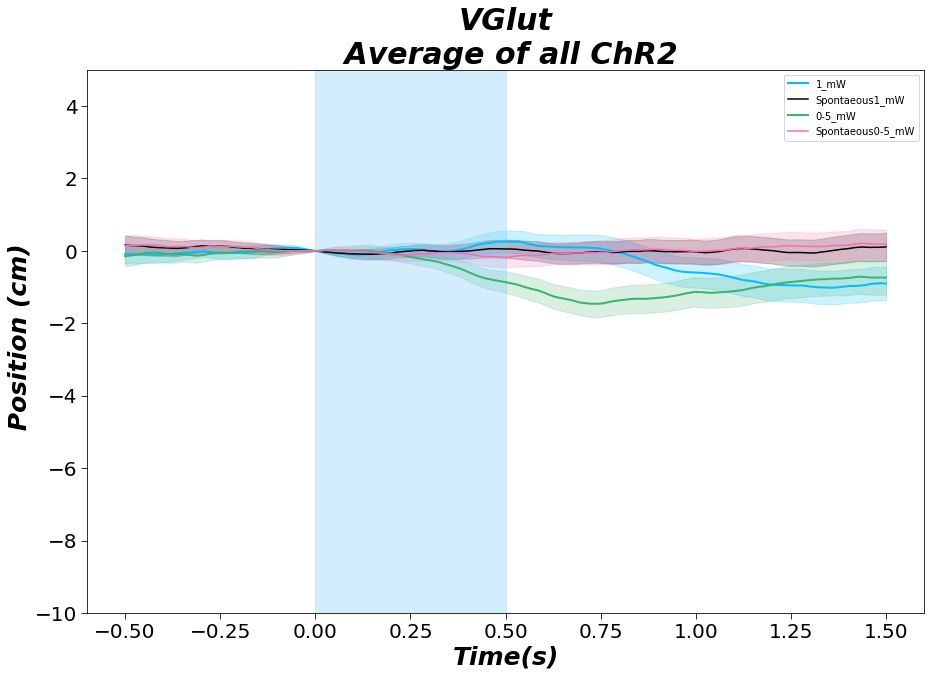

In [32]:

# def plot_pre_on_post(epochs,epochs_spont,average,c_laser,c_spont):
#     ''' plot (pre Laser/ON-Laser/post Laser) velocity comparison between active trials and spontaneous'''
    
# #     epochs_mean = np.average(epochs, axis = 0) # average over different stimuli
# #     epochs_mean_spont = np.average(epochs_spont, axis = 0) # average over different stimuli
    
# #     epochs_sem = stats.sem(epochs, axis=0) # SEM 
# #     epochs_sem_spont = stats.sem(epochs, axis=0) # SEM 

#     confidence_inter = np.empty((0,2), int)
    
#     if len(epochs.shape) > 1 :
#         epochs_mean = np.average(epochs, axis = 0)
#         epochs_mean_spont = np.average(epochs_spont, axis = 0)
        
#         for i in range (epochs.shape[1]): #calculate the two sided confidence interval for every timestep
#             m = [sms.DescrStatsW(epochs[:,i]).tconfint_mean(alpha=0.05, alternative='two-sided')]
#             confidence_inter = np.append(confidence_inter,[[m[0][0],m[0][1]]],axis=0)
#         confidence_inter_spont = np.empty((0,2), int)
        
#         for i in range (epochs_spont.shape[1]):
#             m = [sms.DescrStatsW(epochs_spont[:,i]).tconfint_mean(alpha=0.05, alternative='two-sided')]
#             confidence_inter_spont = np.append(confidence_inter_spont,[[m[0][0],m[0][1]]],axis=0)
#     else:
#         epochs_mean = epochs
#         epochs_mean_spont = epochs_spont
#         confidence_inter = np.zeros(((epochs_mean.shape[0]),2))
#         confidence_inter_spont = np.zeros((epochs_mean.shape[0],2))
#     time_series = np.arange(-pre_interval,interval+post_interval+1)/fps
    
#     plt1,=plt.plot(time_series, epochs_mean, color = c_laser, label = folder, linestyle='-',linewidth=2)#, marker='o',markersize=1)
#     plt.fill_between(time_series, confidence_inter[:,0],  confidence_inter[:,1], color=c_laser, alpha=0.2)
    
#     plt2,=plt.plot(time_series, epochs_mean_spont, color = c_spont, label = "Spontaeous"+folder)
#     plt.fill_between(time_series, confidence_inter_spont[:,0],  confidence_inter_spont[:,1], color=c_spont, alpha=0.2)
#     plt.axvspan(0, interval/fps, alpha=0.2, color='lightskyblue')
    
# #     plt.fill_between(time_series, epochs_mean - epochs_sem,  epochs_mean+ epochs_sem,
# #                     color='gray', alpha=0.2)
# #     plt.fill_between(time_series, epochs_mean_spont - epochs_sem_spont,  epochs_mean_spont+ epochs_sem_spont,
# #                    color='b', alpha=0.2)

#     if plot_param_list[what_plot] == 'velocity':
#         plt.ylabel(" Velocity (cm/s)").set_fontproperties(font_label)
#     else:
#         plt.ylabel(" Position (cm)").set_fontproperties(font_label)
        
#     plt.axhline( y = treadmil_velocity, ls='--', c='red')
    
#     plt.xlabel("Time(s)").set_fontproperties(font_label)
#     plt.ylim(min_y_pre_post,max_y_pre_post) #set limits
#     plt.legend(fontsize = 10)
# #     plt.xlim(-.5,2) #set limits
#     b = body_part_list[where_plot]
#     s = '_'
#     s = s.join(b)
#     if average == 'n':
#         ax.get_xaxis().set_tick_params(direction='out',labelsize = 20 ,length=6)
#         ax.xaxis.set_ticks_position('bottom')
#         ax.get_yaxis().set_tick_params(direction='out',labelsize = 20, length=6)
#         ax.yaxis.set_ticks_position('left')
#         plt.title(plot_param_list[what_plot]+"("+mouse_type+") #"+str(mouse_no) +" "+opto_par+"\n").set_fontproperties(font)
#         plt.savefig(pre_direct+direct_comparison+'/Mouse'+str(mouse_no)+'_'+folder+"_"+opto_par+'_'+mouse_type+'_'+plot_param
#                     +'_timebin_'+str(n_timebin)+'_window_'+str(window)+'_pre_post_stim.png',bbox_inches='tight',orientation='landscape',dpi=300)
#     elif average == 'Averg_trials': # one one mouse
#         plt.title("("+mouse_type+") #"+str(mouse_no) +" "+opto_par+"\n"+folder).set_fontproperties(font)
# #         plt.title(" #"+str(mouse_no) +" "+mouse_type , fontproperties=font)
# #         plt.savefig(pre_direct+direct_comparison+'/'+average+'_Mouse'+str(mouse_no)+'_'+folder+"_"+opto_par+'_'+mouse_type+'_'+ cor+ '_Velociy_' +str(n_timebin)+ 'spont_sampl='+str(no_sample)+'_pre_post_stim.png',bbox_inches='tight',orientation='landscape',dpi=400)
#     else:
#         ax.get_xaxis().set_tick_params(direction='out',labelsize = 20 ,length=6)
#         ax.xaxis.set_ticks_position('bottom')
#         ax.get_yaxis().set_tick_params(direction='out',labelsize = 20, length=6)
#         ax.yaxis.set_ticks_position('left')
# #         plt.legend(handles=[plt1,plt2],labels=['Laser Stimulation'+folder,'Spontaneous'+folder],loc = 'lower right',fontsize =20)
#         plt.title( mouse_type+"\n"+" Average of all "+opto_par).set_fontproperties(font)
#         plt.axhline( y = 17, ls='--', c='g')

#         plt.savefig(os.path.join(path, average+'_'+folder+"_"+opto_par+'_'+mouse_type+'_'+ cor+ '_Velociy_' +s+'_'+
#                     str(n_timebin)+ '_mov_ave_win='+str(window)+'_pre_post_stim.pdf'),bbox_inches='tight',
#                     orientation='landscape',dpi=300)

where_plot,which_plot, what_plot = get_input_cor_body_part() # decide to average over what and coordinates
cor = cor_list[which_plot] # gets either x or y by user

c_spont = ['k', 'hotpink']
c_laser = ['deepbluesky', 'darkseagreen']

path = os.path.join(pre_direct,'data_npz', 'Two_intensities')
Summary_files_list = list_all_files(path,".npz")
count = 1
plt.figure(count)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10), sharey=True)
ax.ylim(-20,17)
for file in Summary_files_list:
    count+=1
    print(file)
    dat = np.load(os.path.join(path,file))
    properties=file.split("_")
    epochs_all_mice = dat['epochs_all_mice']
    epochs_spont_all_mice = dat['epochs_spont_all_mice']#*scale_pix_to_cm/1000*fps*fps
#     epochs_spont_all_mice = np.zeros((epochs_all_mice.shape))
    mouse_type = properties[0]
    opto_par = properties[1]
    plot_pre_on_post(mouse_type,opto_par,epochs_all_mice,epochs_spont_all_mice,
                     average = 'Averg_trials_all_mice',c_laser = c_laser[count],c_spont = c_spont[count])



## Average position or velocity (all the control mice)
This cell will add the epochs of all the files in the chosen directory regardless of the mouse type. If you need the control data for one specific mouse type, remove the other files in the direcroty.

Select for which parts you want to see the pre/On/post: 

 1. Tail 
 2. Nose 
 3. Fore Limb 
 4. Hind Limb
1 2
 1. X 
 2. Y 
1
 1. Position 
 2. Velocity 
 
2
D2_Control_Square_1_mW_mov_aver=10_n_t=30_x_Tail_Nose.npz
['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice']
(227, 501)
FoxP2_Control_Square_1_mW_mov_aver=10_n_t=30_x_Tail_Nose.npz
['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice']
(223, 501)
VGlut_Control_Square_1_mW_mov_aver=10_n_t=30_x_Tail_Nose.npz
['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice']
(158, 501)


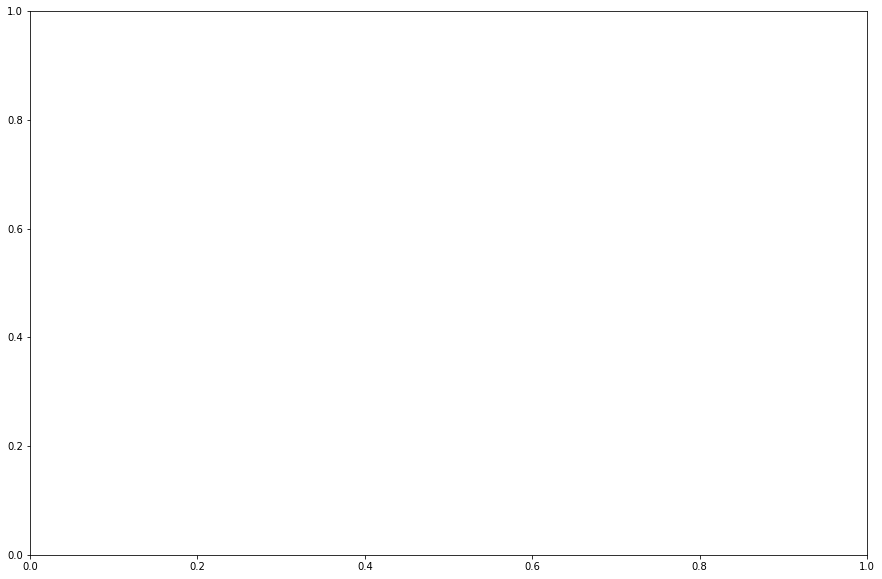

In [30]:
where_plot, which_plot, what_plot = get_input_cor_body_part() # decide to average over what and coordinates
cor = cor_list[which_plot] # gets either x or y by user
plot_param = exp_dict['plot_param_list'][what_plot]

folder = "Square_1_mW"

path = os.path.join(pre_direct, 'data_npz', folder, 'Control')
extension_summary = ".npz"
Summary_files_list = list_all_files(path,extension_summary)
epochs_all_ctr = np.empty((0,pre_interval+interval+post_interval+1))
epochs_spont_all_ctr = np.empty((0,pre_interval+interval+post_interval+1))
count = 0
for file in Summary_files_list:
    count = count+1
    print(file)
    dat = np.load(path+file)
    print(dat.files)
    properties = file.split("_")
    epochs_all_ctr = np.append(epochs_all_ctr,dat['epochs_all_mice'], axis = 0)# construct an array of all the trial epochs of all mice
    epochs_spont_all_ctr = np.append(epochs_spont_all_ctr,dat['epochs_spont_all_mice'], axis = 0)# construct an array of all the trial epochs of all mice
#     epochs_spont_all_ctr = np.zeros((epochs_all_ctr.shape))
    mouse_type = properties[0]
    opto_par = properties[1]
    cor_file = properties[9]
    plot_param_file = properties[10]
    if cor != cor_file:
        print("the file doesn't correspond to your chosen coordinate, please check the files in the directory and try again.")
        break
    if plot_param != plot_param_file:
        print("the file doesn't correspond to your chosen measure, please check the files in the directory and try again.")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10), sharey=True)

plot_pre_on_post(mouse_type,opto_par, epochs_all_ctr,epochs_spont_all_ctr,average = 'Averg_trials_all_mice',c_laser = 'deepbluesky', c_spont = 'k')

## Look at the relative distance between Limb and Tail in one epoch

Here we want to see the relative displacement of the back limb relative to the tail. (a constant value confirms freezing behavior)
set the values for the first five lines:

# discarded epochs = 0
# discarded epochs = 0


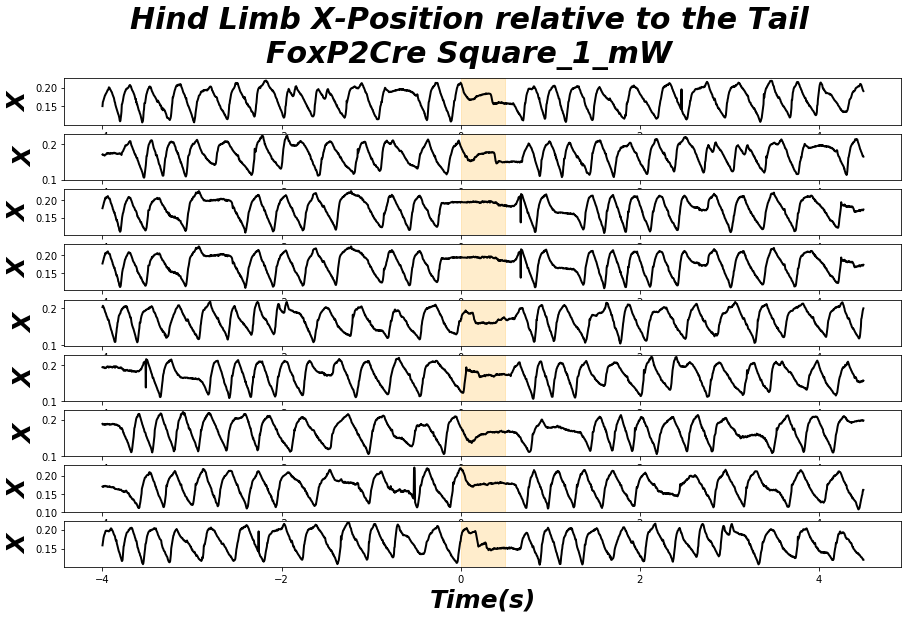

In [7]:
i = 4 # number of session
folder ='Square_1_mW'
# direct = pre_direct + mouse_type +'/'+ opto_par + '/Mouse_' + str(mouse_no)+ '/'  # directory to the folder for each mouse
direct = '/home/shiva/Desktop/Shiva_Behavior/FoxP2/ChR2/Mouse_8/'
n =10 # number of trials to look at

files_list_DLC = list_all_files(os.path.join(os.path.join(direct,folder,'DLC',".xlsx"))
files_list_Laser = list_all_files(os.path.join(direct,folder,'Laser',".xlsx"))

file_name_pos = os.path.join(direct,folder,'DLC',files_list_DLC[i])
file_name_laser = os.path.join(direct,folder,'Laser',files_list_laser[i])

between_stim = 250
df = read_DLC(file_name_pos)
laser_t = read_laser(file_name_laser)

time_series  = df.index / fps ## time axis in seconds for stimulation trial
trial_time = max(time_series)
bins  = np.array(laser_t.values).astype(int)
                                
pre_interval = 1000;interval = 125; post_interval = 1000; 
                                
epochs_Limb = extract_epochs(bins,df['lFL','x'].values,accep_interval_range[0],accep_interval_range[1],pre_interval,interval,post_interval)
epochs_Tail = extract_epochs(bins,(df['lTail','x'].values+df['rTail','x'].values)/2,accep_interval_range[0],accep_interval_range[1],pre_interval,interval,post_intervalt)
epochs_Limb_rel = (epochs_Limb-epochs_Tail)*scale_pix_to_cm
fig = plt.figure(figsize=(15,10))
for i in range(1,n):
    
    x = fig.add_subplot(n,1,i)
    random_num = np.random.randint(0,epochs_Limb_rel.shape[0])
    time_series = np.arange(-pre_interval,interval+post_interval+1)/fps
    plt.plot(time_series, epochs_Limb_rel[random_num,:], color = 'k',linestyle='-',linewidth=2)#, marker='o',markersize=1)
#     plt.axhline(y=0, c= 'g')
    plt.axvspan(0, interval/fps, alpha=0.2, color='orange')
    plt.ylabel("X", fontproperties=font_label).set_fontproperties(font_label)
    plt.xlabel("Time(s)", fontproperties=font_label).set_fontproperties(font_label)
    
fig.suptitle("Hind Limb X-Position relative to the Tail"+'\n'+"FoxP2Cre "+folder, fontsize =20).set_fontproperties(font)
# plt.savefig('/home/shiva/Desktop/Shiva_Behavior/Subplots/Limb_H.pdf',bbox_inches='tight',orientation='landscape',dpi=350)

plt.show()

Since the right and left for limbs are not synchronous we can neither average them nor use them to remove jitters. So the epochs extraction is different here.

Select for which parts you want to see the pre/On/post: 

 1. Tail 
 2. Nose 
 3. Fore Limb 
 4. Hind Limb
3
 1. X 
 2. Y 
1
 1. Position 
 2. Velocity 
 
1
 number of session = 1 out of 3
# jitter in mean(righ,left)  =  5671
# jitter in mean(righ,left)  =  5687
# discarded epochs = 1
 number of session = 2 out of 3
# jitter in mean(righ,left)  =  5607
# jitter in mean(righ,left)  =  5192
# discarded epochs = 2
 number of session = 3 out of 3
# jitter in mean(righ,left)  =  5293
# jitter in mean(righ,left)  =  5524
# discarded epochs = 0


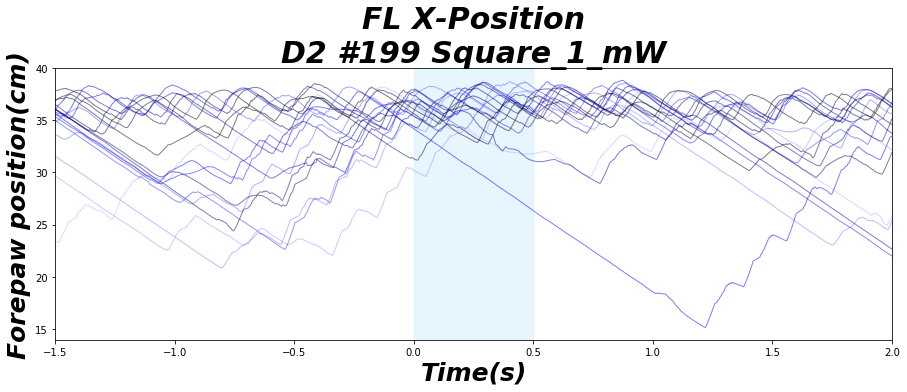

In [141]:
from scipy.signal import find_peaks
# mouse_type= 'FoxP2';opto_par = "ChR2"; mouse_no = 8; spont = "n"; folder = "Square_1_mW"
mouse_type= 'D2';opto_par = "ChR2"; mouse_no = 199; spont = "n"; folder = "Square_1_mW"

pre_interval = 375;interval = 125; post_interval = 375

direct = pre_direct+ mouse_type+'/'+ opto_par+ '/Mouse_'+ str(mouse_no)+ '/'  # directory to the folder for each mouse
convert_csv_to_xlsx(direct+folder+'/DLC')
files_list_DLC = list_all_files(direct+folder+'/DLC',extension)
convert_csv_to_xlsx(direct+folder+'/Laser') # files might be given in csv, this is to unify 
files_list_Laser = list_all_files(direct+folder+'/Laser',extension)
def extract_epochs_over_trials_limb(files_list,files_list_laser,direct,folder,spont,pre_interval,post_interval,interval):
    '''return all the epochs of all trials for one mouse without averaging right and left'''
    plot_param_list = ['position' , 'velocity', 'acceleration']
    global plot_param
    plot_param = plot_param_list[what_plot]
    i = 0
    epochs = np.empty((0,pre_interval+post_interval+interval+1))

    for i in range(0,len(files_list)):
        
        print(' number of session = {} out of {}'.format(i+1,len(files_list)))
        file_path_DLC = direct+folder+'/DLC/'+files_list[i]
        df = read_DLC(file_path_DLC)
        
        if plot_param == 'position':
            variable,blah = position_r_l(df, which_plot,where_plot)
            
        if plot_param == 'velocity':
            variable =  derivative_mov_ave(position_r_l(df, which_plot,where_plot),n_timebin,window)  # velocity

        if spont == 'y': #if it's a spontaneous reading extract epochs randomly 
            bins = produce_random_bins_for_spont(len(variable),no_sample,max_distance,min_distance)
            
        else: # if a normal trial read bins from laser times
            file_path_Laser = direct+folder+'/Laser/'+files_list_laser[i]
            laser_t = read_laser(file_path_Laser)
            bins  = np.copy(laser_t.values).astype(int)
        epochs_trial = extract_epochs(bins,variable,pre_interval,post_interval,interval)
        epochs = np.append(epochs,epochs_trial,axis = 0)

    return epochs

# uncomment if you want the relative to tail
# where_plot,which_plot, what_plot = [0],0,0 # tail x position
# cor = cor_list[which_plot] # gets either x or y by user
# epochs_tail = extract_epochs_over_trials(files_list_DLC,files_list_Laser,direct,folder,'n',pre_interval,post_interval,interval) 

where_plot,which_plot, what_plot = get_input_cor_body_part() #limb x position
cor = cor_list[which_plot] # gets either x or y by user
epochs_limb = extract_epochs_over_trials_limb(files_list_DLC,files_list_Laser,direct,folder,'n',pre_interval,post_interval,interval) 


# epochs = epochs_limb - epochs_tail
epochs = epochs_limb

# n = 10
# fig = plt.figure(figsize=(15,10))
# for i in range(1,n):
    
#     x = fig.add_subplot(n,1,i)
#     random_num = np.random.randint(0,ep_rel_limb_tail.shape[0])
#     time_series = np.arange(-pre_interval,interval+post_interval+1)/fps
#     plt.plot(time_series, ep_rel_limb_tail[random_num,:], color = 'k',linestyle='-',linewidth=2)#, marker='o',markersize=1)
#     plt.axhline(y=0, c= 'g')
#     plt.axvspan(0, interval/fps, alpha=0.2, color='orange')
#     plt.ylabel("X", fontproperties=font_label).set_fontproperties(font_label)
#     plt.xlabel("Time(s)", fontproperties=font_label).set_fontproperties(font_label)
    
from colour import Color
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])
gap = 3
align = 100
selected = np.full((epochs.shape[0]),False) #the epochs chosen for plot
pre_stim_x = np.empty((epochs.shape[0])) #the epochs chosen for plot
time_series = np.arange(-pre_interval,interval+post_interval+1)/fps
for i in range(epochs.shape[0]):
    peaks, _ = find_peaks(epochs[i,:], height=6.5)
    if sum(np.logical_and(pre_interval-align -gap < peaks,peaks < pre_interval-align+ gap)) :
        selected[i] = True
#         print(np.average( epochs[i,:pre_interval]))
        pre_stim_x[i] = np.average( epochs[i,:1])
        
#         plt.plot(time_series, epochs[i,:],linestyle='-',linewidth=1,alpha = 0.5)#, marker='o',markersize=1)
ind, = np.where(selected)

pre_x = pre_stim_x[ind]
inds = pre_x.argsort()

red = Color("blue")
colors = list(red.range_to(Color("green"),len(pre_x)))
fig = plt.figure(figsize=(15,5))
lightness = np.linspace(0.3,2,len(pre_x))

for i in range(len(pre_x)):
#     print(pre_x[inds[i]])
    plt.plot(time_series, epochs[ind[inds[i]],:],linestyle='-',linewidth=1,color =lighten_color('b', lightness[i]),alpha = 0.5)#, marker='o',markersize=1)


plt.axvspan(0, interval/fps, alpha=0.2, color='lightskyblue')
plt.xlim(-1.5,2)
# plt.axvline(x=(-align+gap/2)/fps, c= 'navy',ls='--')
plt.title(body_part[where_plot][0]+" X-Position"+'\n'+mouse_type+' #'+str(mouse_no)+' '+folder, fontsize =20).set_fontproperties(font)

plt.ylabel("Forepaw position(cm)", fontproperties=font_label).set_fontproperties(font_label)
plt.xlabel("Time(s)", fontproperties=font_label).set_fontproperties(font_label)
plt.savefig('/home/shiva/Desktop/Shiva_Behavior/Subplots/'+body_part[where_plot][0]+'_'+mouse_type+'_mouse_#'+str(mouse_no)+'.png',bbox_inches='tight',orientation='landscape',dpi=350)


provided that you have npz files storing limb epochs and their corresponding tail epochs you can select epochs with a good synchronation of last cycle and plot

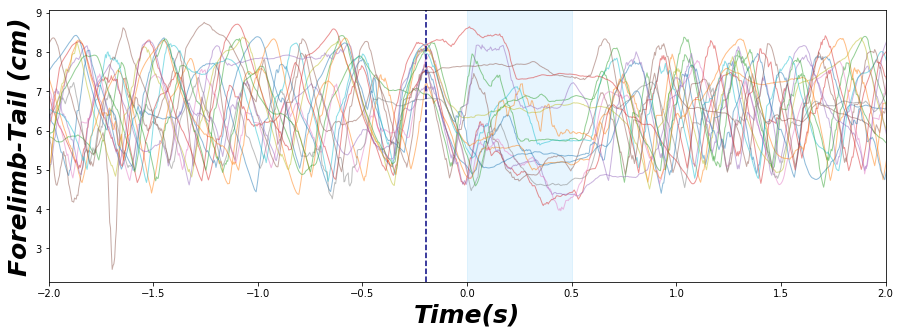

In [22]:
file_name= 'FoxP2_limb_ChR2_Square_1_mW_mov_aver=10_n_t=30.npz'
path =pre_direct+'data_npz/Square_1_mW/Limb_Tail/'+file_name

limb = np.load(path)
epochs_limb = limb['epochs_all_mice']

file_name= 'FoxP2_tail_ChR2_Square_1_mW_mov_aver=10_n_t=30.npz'
path =pre_direct+'data_npz/Square_1_mW/Limb_Tail/'+file_name

tail = np.load(path)
epochs_tail = tail['epochs_all_mice']
ep_rel_limb_tail = epochs_limb - epochs_tail
fig = plt.figure(figsize=(15,5))
pre_interval = 1000;interval = 125; post_interval = 1000

gap = 3
align = 50
selected = np.full((ep_rel_limb_tail.shape[0]),False) #the epochs chosen for plot
for i in range(110):#ep_rel_limb_tail.shape[0]):
    peaks, _ = find_peaks(ep_rel_limb_tail[i,:], height=6.5)
    if sum(np.logical_and(pre_interval-align -gap < peaks,peaks < pre_interval-align+ gap)) :
        selected[i] = True
        time_series = np.arange(-pre_interval,interval+post_interval+1)/fps
        plt.plot(time_series, ep_rel_limb_tail[i,:],linestyle='-',linewidth=1,alpha = 0.5)#, marker='o',markersize=1)
plt.axvspan(0, interval/fps, alpha=0.2, color='lightskyblue')
plt.xlim(-2,2)
plt.axvline(x=(-align+gap/2)/fps, c= 'navy',ls='--')

plt.ylabel("Forelimb-Tail (cm)", fontproperties=font_label).set_fontproperties(font_label)
plt.xlabel("Time(s)", fontproperties=font_label).set_fontproperties(font_label)
plt.savefig('/home/shiva/Desktop/Shiva_Behavior/Subplots/Flimb_rel_tail.png',bbox_inches='tight',orientation='landscape',dpi=350)


## Look at a single measure in one session

/home/shiva/Desktop/Shiva_Behavior/FoxP2/ChR2/Mouse_8/Square_1_mW
Select what you want to see: 

 1. Tail 
 2. Nose 
 3. Fore Limb 
 4. Hind Limb
2
 1. Position 
 2. Velocity 
 3. Acceleration
1
 1. X 
 2. Y 
1
 1. Right & Left 
 2. Average
1
in
# inconsistent right left =  1
time stamps =  []


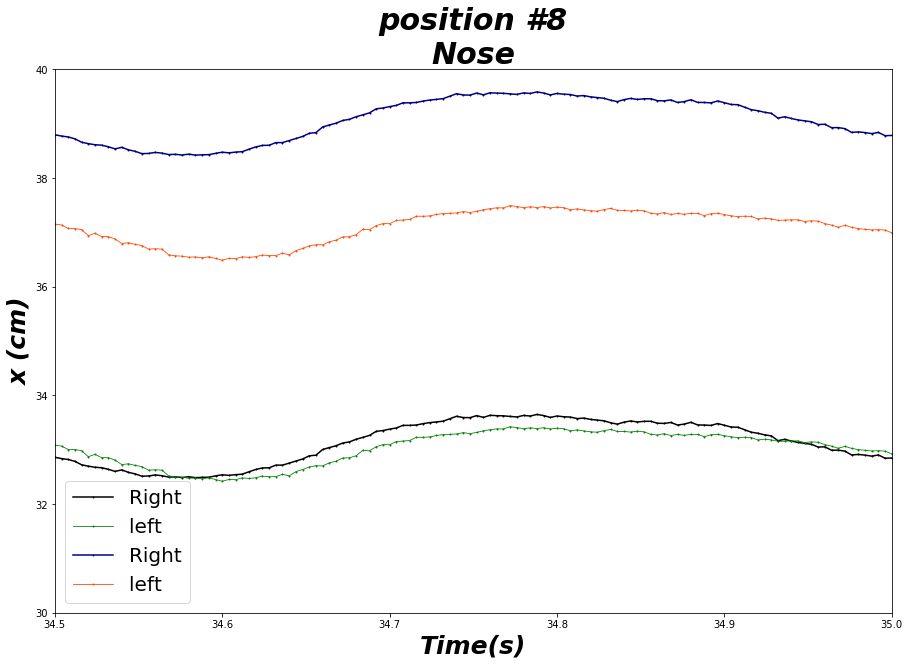

In [33]:
trial_no = 13
i = 2 # which session to look
mouse_type= 'FoxP2';opto_par = "ChR2"; mouse_no = 8; spont = "n"; folder = "Square_1_mW"

direct = os.path.join(pre_direct, mouse_type, opto_par, 'Mouse_' +str(mouse_no)) # directory to the folder for each mouse
files_list_DLC = list_all_files(os.path.join(direct,folder,'DLC','.xlsx'))
files_list_Laser = list_all_files(os.path.join(direct,folder,'Laser','.xlsx'))
df = read_DLC(direct+folder+"/DLC/"+files_list_DLC[i])
laser_t = read_laser(direct+folder+"/Laser/"+files_list_Laser[i])

time_series  = df.index / fps ## time axis in seconds for stimulation trial
trial_time = max(time_series)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10), sharey=True)
input_plot(df, laser_t,exp_dict)

plt.show()

In [56]:
a = np.arange(10)
b = np.arange(100)
def hey(a,b):
    b = a+3
hey(a,b)
print(b)


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


## Naive Implementation of X-V distinction

## Categorize trials by pre-laser X/V and Plot by distinction

In [5]:
# folder = 'Square_0-5_mW'
# folder = 'Square_1_mW'
folder = 'Square_0-25_mW'
# folder = 'GP_15_mW';
# folder = 'STN+GP_1_mW';

where_plot,which_plot, what_plot = get_input_cor_body_part() # decide to average over what and coordinates
cor = cor_list[which_plot] # gets either x or y by user

Vglut2_list = ([ 164, 165, 166],[359, 360]) #first list ChR2 second Control
mouse_no_list = pd.DataFrame(({'D2':D2_list, 'Vglut2':Vglut2_list, 'FoxP2':FoxP2_list}))

opto_par = 'ChR2'
# mouse_type = 'D2';
# mouse_type = 'Vglut2'
mouse_type = 'FoxP2'
pre_interval = 125
pre_stim_inter = pre_interval
average_pre_x_v_and_save(mouse_type, folder, opto_par,pre_interval,post_interval,interval,**pre_x_v_dict)


Select for which parts you want to see the pre/On/post: 

 1. Tail 
 2. Nose 
 3. Fore Limb 
 4. Hind Limb
1 2
 1. X 
 2. Y 
1
 1. Position 
 2. Velocity 
 
2
Select for which parts you want to see the pre/On/post: 

 1. Tail 
 2. Nose 
 3. Fore Limb 
 4. Hind Limb
1 2
 1. X 
 2. Y 
1
 1. Position 
 2. Velocity 
 
2
# mouse =  8
spont =n
 number of session = 1 out of 2
# jitter in mean(righ,left)  =  758
# jitter in mean(righ,left)  =  921
# discarded epochs = 0
 number of session = 2 out of 2
# jitter in mean(righ,left)  =  1504
# jitter in mean(righ,left)  =  2070
# discarded epochs = 1
x number of session = 1 out of 2
# jitter in mean(righ,left)  =  758
# jitter in mean(righ,left)  =  921
# x discarded epochs = 0
x number of session = 2 out of 2
# jitter in mean(righ,left)  =  1504
# jitter in mean(righ,left)  =  2070
# x discarded epochs = 1
run time =  27.125691296001605
# mouse =  9
spont =n
 number of session = 1 out of 2
# jitter in mean(righ,left)  =  1238
# jitter in mean(rig

FoxP2_ChR2_Square_1_mW_pre_x_pre_v_pre_stim_inter=125_mov_aver=10_n_t=30.npz
   mean_velocity mouse_type optogenetic expression pulse_type intensity_mW  \
0       0.706812      FoxP2                   ChR2     Square            1   
1       3.336014      FoxP2                   ChR2     Square            1   
2      -3.103739      FoxP2                   ChR2     Square            1   
3      -5.976931      FoxP2                   ChR2     Square            1   
4      -4.729980      FoxP2                   ChR2     Square            1   

  epoch velocity      x  
0   OFF      pos  front  
1   OFF      pos  front  
2   OFF      neg  front  
3   OFF      neg  front  
4   OFF      neg  front  
[3.5775199235122113, 3.2183656523737296]


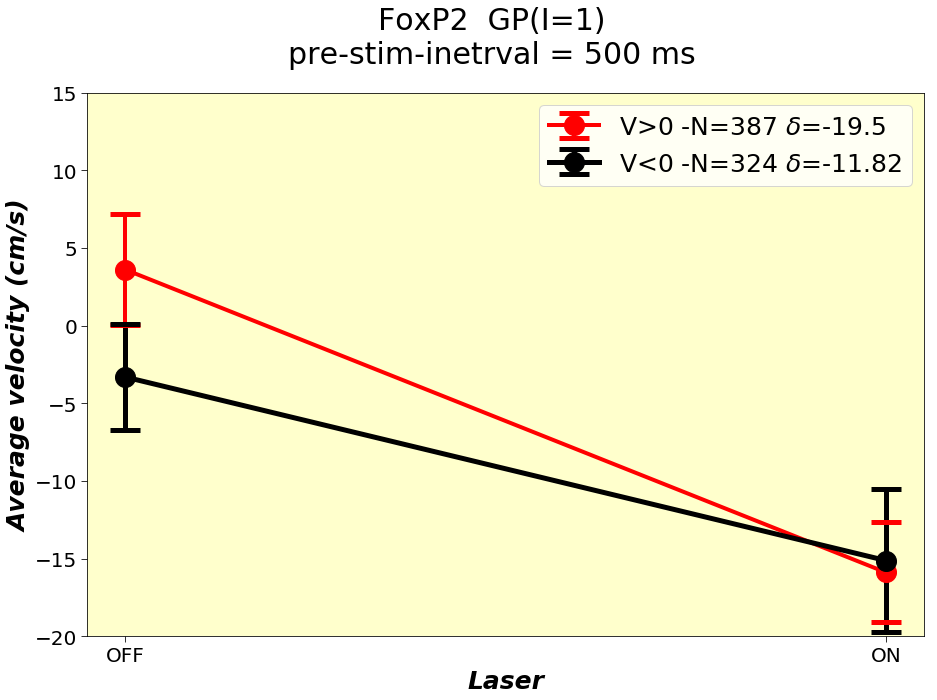

In [7]:
# mouse_type = 'D2';
# folder = 'STR'; 

mouse_type = 'FoxP2'
# folder = "GP"

# mouse_type = 'Vglut2'
# folder = 'STN+GP'; 
# folder = 'STN_3_mice'; 
folder = 'GP'; 
# folder = 'STN'; 

path =pre_direct+'data_npz/Distinction/ChR2/'+mouse_type+'/'+folder+"/"

result_val = read_npz_return_data_frame(path,pre_interval,post_interval,interval)
result = categorize_pre_x_and_v(result_val,**pre_x_v_dict)
print(result.head())
# violin_plot_X_V_distiction(result, path, mouse_type, folder, **pre_x_v_dict)
# plot_phase_space_V(result,path,mouse_type,folder,**pre_x_v_dict)
# Plot_ON_OFF_X_V_mean(result,path,mouse_type,folder,**pre_x_v_dict)
Plot_ON_OFF_V_mean(result,path,mouse_type,folder,**pre_x_v_dict)


## Stats on minimum velocity during laser

/home/shiva/Desktop/Shiva_Behavior/data_npz/Distinction/ChR2/D2/STR/
D2_ChR2_Square_1_mW_pre_x_pre_v_pre_stim_inter=125_mov_aver=10_n_t=30.npz
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

pos v.s. neg: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.089e-01 U_stat=7.160e+04
/home/shiva/Desktop/Shiva_Behavior/data_npz/Distinction/ChR2/VGlut/STN/
VGlut_ChR2_Square_1_mW_pre_x_pre_v_pre_stim_inter=125_mov_aver=10_n_t=30.npz
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

pos v.s. neg: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.431e-01 U_stat=8.015e+04
/home/shiva/Desktop/Shiva_Behavior/data_npz/Distinction/ChR2/FoxP2/GP/
FoxP2_ChR2_Square_0-25_mW_pre_x_pre_v_pre_stim_inter=125_mov_aver=10_n_t=30_x_Tail_No

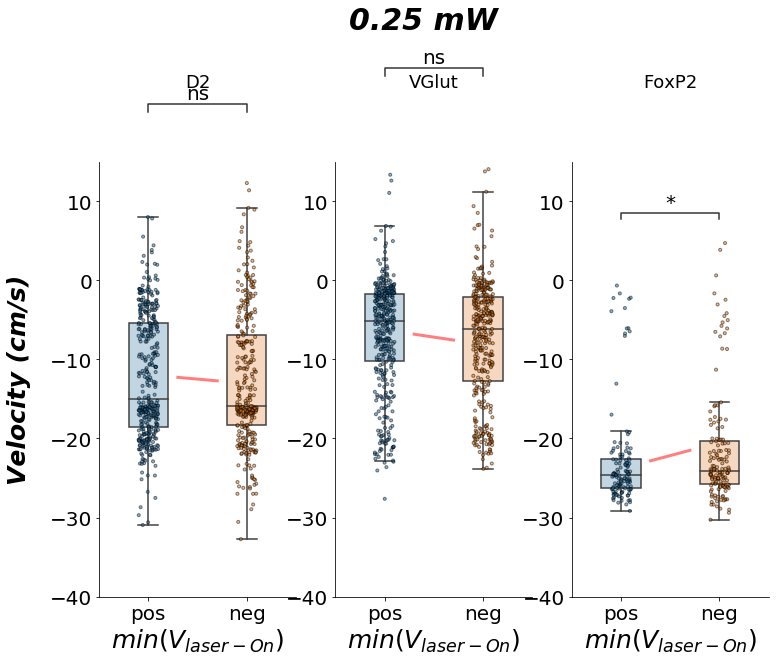

In [6]:
# # mouse_type = 'D2';
# # folder = 'STR'; 

# mouse_type = 'FoxP2'
# # folder = "GP"

# # mouse_type = 'Vglut2'
# # folder = 'STN+GP'; 
# # folder = 'STN_3_mice'; 
# folder = 'GP'; 
# # folder = 'STN'; 

# path =pre_direct+'data_npz/Distinction/ChR2/'+mouse_type+'/'+folder+"/"


# result_val = read_npz_return_data_frame(path,pre_interval,post_interval,interval)
# result = categorize_pre_x_and_v(result_val,back_front_boundary,0)
# print(result.head())

# result = result[result['epoch']=='ON']

# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 8))
# sns.stripplot(x="velocity", y="min_velocity", order=["pos", "neg"],dodge=True, data=result,jitter=True, 
#                    marker='o',edgecolor = 'k',linewidth = 1, size = 3,
#                    alpha=0.5)
# g = sns.boxplot(x="velocity", y="min_velocity", order=["pos", "neg"],dodge=False, width = 0.4 ,
#             data=result, boxprops={'facecolor':'None'}, fliersize = 0)
# add_stat_annotation(g, data=result,x="velocity", y="min_velocity", order=["pos", "neg"], box_pairs=[("pos", "neg")],
#                     test='Mann-Whitney', text_format='star', loc='outside', verbose=2,fontsize = 20)
# set_ticks(ax)
# plt.ylabel('').set_fontproperties(font_label)
# plt.xlabel('').set_fontproperties(font_label)
# # plt.title(result['pulse'].values[0]+' '+ result['intensity'].values[0]+' mW' +
# #           '\n'+ result['protocol'].values[0],fontsize = 18,pad=70)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# t = stats.mannwhitneyu(result[result['velocity'] == 'pos']['min_velocity'],
#                        result[result['velocity'] == 'neg']['min_velocity'])

folder = '0.25 mW'
subplot_details = {'brain_region':['STR','STN','GP'], 'mouse_type':['D2','Vglut2','FoxP2']}
def sns_box_point_plot(subplot_details):
    n_subplots = len(subplot_details['brain_region'])
    
    y_max = 15 ; y_min = - 40

    fig, axes = plt.subplots(nrows=1, ncols=n_subplots, figsize=(4*n_subplots, 8))
    for count in range(1,n_subplots+1):
        path =os.path.join(pre_direct,'data_npz','Distinction','ChR2',
                           subplot_details['mouse_type'][count-1],subplot_details['brain_region'][count-1])+'/'
        print(path)
        result_val = read_npz_return_data_frame(path,pre_interval,post_interval,interval)
        result = categorize_pre_x_and_v(result_val,back_front_boundary,0)
        result = result[result['epoch']=='ON']
        ax = axes[count-1] 
        ax = plt.subplot(100+n_subplots*10+count)
        set_ticks(ax)
        
        sns.stripplot(x="velocity", y="min_velocity", order=["pos", "neg"],dodge=True, data=result,jitter=True, 
                   marker='o',edgecolor = 'k',linewidth = 1, size = 3,
                   alpha=0.5)
        g = sns.boxplot(x="velocity", y="min_velocity", order=["pos", "neg"],dodge=False, width = 0.4 ,
            data=result, fliersize = 0)

        add_stat_annotation(g, data=result,x="velocity", y="min_velocity", order=["pos", "neg"], box_pairs=[("pos", "neg")],
                    test='Mann-Whitney', text_format='star', loc='outside', verbose=2,fontsize = 20)
        plt.plot([0.3,0.7],[np.average(result[result['velocity']=='pos']['min_velocity']),
                                          np.average(result[result['velocity']=='neg']['min_velocity'])],
                                           '-',lw = 3, c= 'r',alpha = 0.5,markersize = 12)
        for patch in g.artists:
            r, g, b, a = patch.get_facecolor()
            patch.set_facecolor((r, g, b, .3))
        plt.ylim(y_min,y_max)
        # get legend information from the plot object
        # handles, labels = ax.get_legend_handles_labels()
        # specify just one legend
        # plt.legend(handles[0:2], labels[0:2], fontsize = 20)
        plt.ylabel('').set_fontproperties(font_label)
        plt.xlabel(r'$min(V_{laser-On})$').set_fontproperties(font_label)
        plt.title(subplot_details['mouse_type'][count-1],fontsize = 18,pad=75)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
    fig.suptitle(folder,y=1.15, fontproperties=font)
    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axis
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.ylabel('Velocity (cm/s)',fontsize = 25,labelpad=45).set_fontproperties(font_label)
    
sns_box_point_plot(subplot_details)
plt.savefig(os.path.join(pre_direct,'data_npz','Distinction','ChR2','Min_V_ON_'+folder+'.pdf'),bbox_inches='tight',orientation='landscape',dpi=200)

## Look at average velocity by pre-laser X position distinction

VGlut_ChR2_Square_1_mW_pre_x_pre_v_pre_stim_inter=125_mov_aver=10_n_t=30.npz
['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice']
3.423680482398385
0.07032386267492569
29.914298444381817
11.533333333333333
front 730
back 48
['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice']


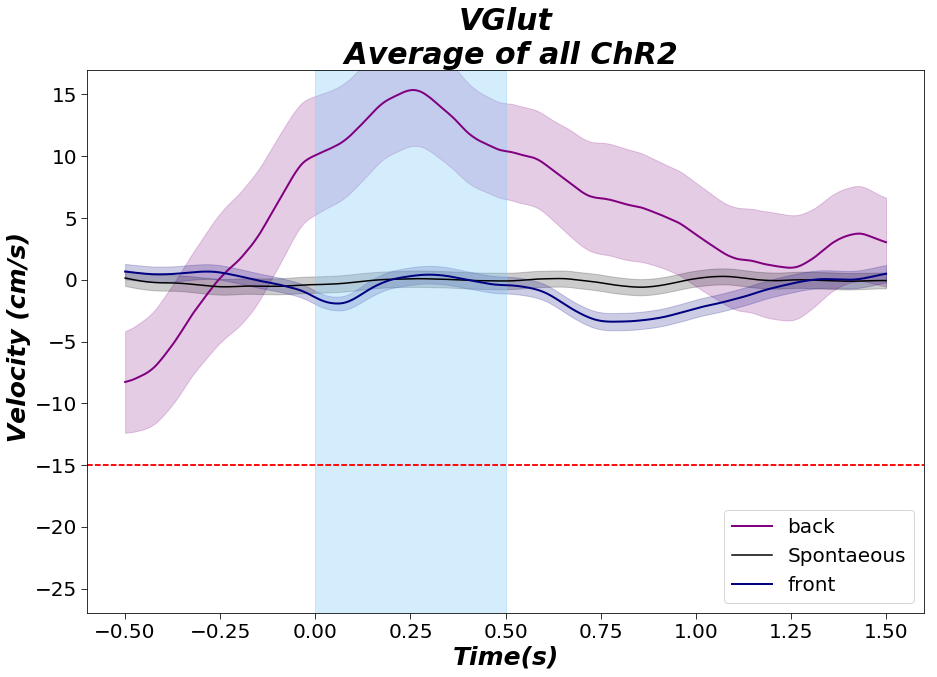

In [48]:
def plot_pre_on_post_v(epochs,epochs_spont,color,label,spont ):
    ''' plot (pre Laser/ON-Laser/post Laser) velocity comparison between active trials and spontaneous'''
    
    epochs_mean = np.average(epochs, axis = 0) # average over different stimuli
    epochs_mean_spont = np.average(epochs_spont, axis = 0) # average over different stimuli

    confidence_inter = np.empty((0,2), int)
    
    if len(epochs.shape) > 1 :
        epochs_mean = np.average(epochs, axis = 0)
        epochs_mean_spont = np.average(epochs_spont, axis = 0)
        
        for i in range (epochs.shape[1]): #calculate the two sided confidence interval for every timestep
            m = [sms.DescrStatsW(epochs[:,i]).tconfint_mean(alpha=0.05, alternative='two-sided')]
            confidence_inter = np.append(confidence_inter,[[m[0][0],m[0][1]]],axis=0)
        confidence_inter_spont = np.empty((0,2), int)
        
        for i in range (epochs_spont.shape[1]):
            m = [sms.DescrStatsW(epochs_spont[:,i]).tconfint_mean(alpha=0.05, alternative='two-sided')]
            confidence_inter_spont = np.append(confidence_inter_spont,[[m[0][0],m[0][1]]],axis=0)
    else:
        epochs_mean = epochs
        epochs_mean_spont = epochs_spont
        confidence_inter = np.zeros(((epochs_mean.shape[0]),2))
        confidence_inter_spont = np.zeros((epochs_mean.shape[0],2))
    time_series = np.arange(-pre_interval,interval+post_interval+1)/fps
    
    plt1,=plt.plot(time_series, epochs_mean, color = color, label = label , linestyle='-',linewidth=2)#, marker='o',markersize=1)
    plt.fill_between(time_series, confidence_inter[:,0],  confidence_inter[:,1], color=color, alpha=0.2)
    
    if spont == True:
        plt2,=plt.plot(time_series, epochs_mean_spont, color = 'k', label = "Spontaeous")
        plt.fill_between(time_series, confidence_inter_spont[:,0],  confidence_inter_spont[:,1], color='k', alpha=0.2)
    
    plt.axvspan(0, interval/fps, alpha=0.2, color='lightskyblue')


    if plot_param_list[what_plot] == 'velocity':
        plt.ylabel(" Velocity (cm/s)").set_fontproperties(font_label)
    else:
        plt.ylabel(" Position (cm)").set_fontproperties(font_label)
        
    plt.axhline( y = treadmil_velocity, ls='--', c='red')
    
    plt.xlabel("Time(s)").set_fontproperties(font_label)
    plt.ylim(min_y_pre_post,max_y_pre_post) #set limits
    plt.legend(fontsize = 10)
#     plt.xlim(-.5,2) #set limits

#     handles =np.array([plt1,plt2])
    
    ax.get_xaxis().set_tick_params(direction='out',labelsize = 20 ,length=6)
    ax.xaxis.set_ticks_position('bottom')
    ax.get_yaxis().set_tick_params(direction='out',labelsize = 20, length=6)
    ax.yaxis.set_ticks_position('left')
    plt.legend(loc = 'lower right',fontsize =20)

#     plt.legend(handles=handles[handles_ind].tolist(),labels=labels,loc = 'lower right',fontsize =20)
    plt.title( mouse_type+"\n"+" Average of all "+opto_par).set_fontproperties(font)
#     plt.axhline( y = 17, ls='--', c='g')
   

back_front_boundary =  (treadmill_len-elec_shock)/3 # set the limit below which is considered back of the treadmill

where_plot,which_plot, what_plot = [0,1],0,1 # decide to average over what and coordinates
cor = cor_list[which_plot] # gets either x or y by user

# mouse_type = 'D2' ; folder = 'STR' ; opto_par = 'ChR2'
# mouse_type = 'FoxP2' ; folder = 'GP' ; opto_par = 'ChR2'
mouse_type = 'Vglut2' ; folder = 'STN' ; opto_par = 'ChR2'


path = os.path.join(pre_direct,'data_npz','Distinction','ChR2',mouse_type,folder)
files = list_all_files(path,".npz")
file = files[0]
print(file)
dat = np.load(os.path.join(path,file))
properties=file.split("_")
print(dat.files)
epochs = dat[dat.files[0]]
pre_x = dat[dat.files[1]]
print(np.average(pre_x))
print(np.min(pre_x))
print(np.max(pre_x))
print(back_front_boundary)
ind,  = np.where(pre_x < back_front_boundary)
print("front",len(ind))
# print(np.sort(pre_x)/scale_pix_to_cm)
epochs_v_front = epochs[ind,:]
ind,  = np.where(pre_x > back_front_boundary)
print("back",len(ind))
epochs_v_back = epochs[ind,:]
folder = "Square_1_mW"
path_main = os.path.join(pre_direct,'data_npz', folder, 'ChR2')

extension_summary = ".npz"
summary_files_list = list_all_files(os.path.join(pre_direct,'data_npz',folder,'ChR2',extension_summary))
for file in summary_files_list:
    if file.split("_")[0] == mouse_type:
        dat = np.load(os.path.join(path_main,file))
        print(dat.files)
        epochs_spont = dat['epochs_spont_all_mice']
        break
        
pre_interval = int(.5*fps) # interval before laser onset
post_interval = int(.5*fps*2) # interval after laser onset

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10), sharey=True)
plot_pre_on_post_v(epochs_v_back,epochs_spont[:epochs_v_front.shape[0]],'purple','back', spont = True)
plot_pre_on_post_v(epochs_v_front,np.zeros((epochs_v_less.shape)),'navy','front',spont = False)
plt.savefig(os.path.join(path,'V_X_distinction'+'_'+folder+"_"+opto_par+'_'+mouse_type+'_'+ cor+ '_Velociy_' +
                str(n_timebin)+ '_mov_ave_win='+str(window)+'_pre_post_stim.png'),bbox_inches='tight',
                orientation='landscape',dpi=300)

## Look at average velocity by pre-laser velocity distinction

FoxP2_ChR2_Square_0-25_mW_pre_x_pre_v_pre_stim_inter=125_mov_aver=10_n_t=30_x_Tail_Nose.npz
['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice']
(287, 501)
FoxP2_ChR2_Square_0-25_mW_mov_aver=10_n_t=30_x_Tail_Nose.npz
['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice']


/home/shiva/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


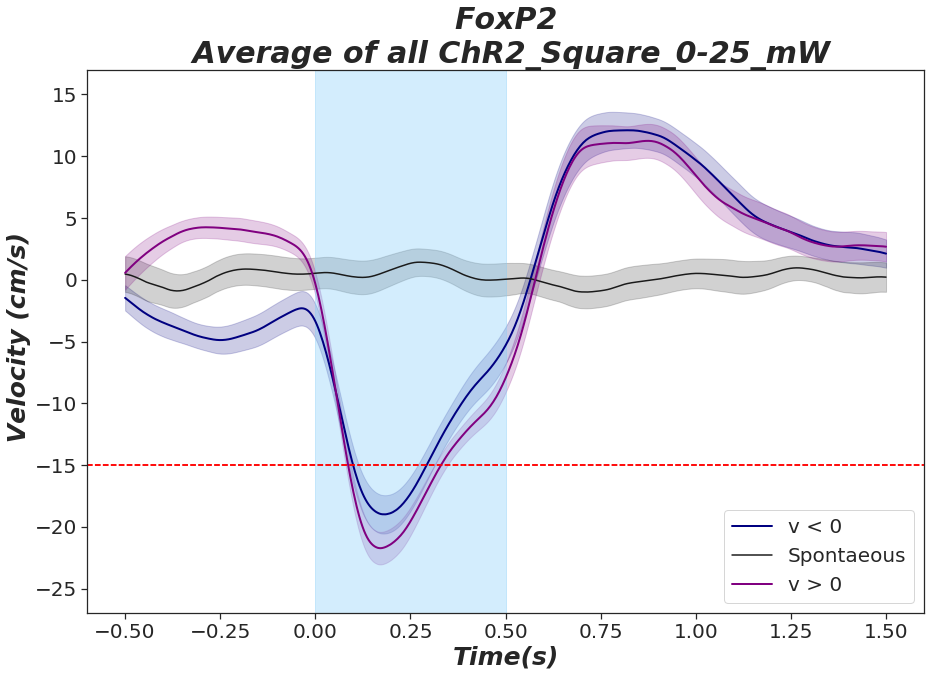

In [18]:
def plot_pre_on_post_v(epochs,epochs_spont,color,label,spont, folder ):
    ''' plot (pre Laser/ON-Laser/post Laser) velocity comparison between active trials and spontaneous'''
    
    epochs_mean = np.average(epochs, axis = 0) # average over different stimuli
    epochs_mean_spont = np.average(epochs_spont, axis = 0) # average over different stimuli

    confidence_inter = np.empty((0,2), int)
    
    if len(epochs.shape) > 1 :
        epochs_mean = np.average(epochs, axis = 0)
        epochs_mean_spont = np.average(epochs_spont, axis = 0)
        
        for i in range (epochs.shape[1]): #calculate the two sided confidence interval for every timestep
            m = [sms.DescrStatsW(epochs[:,i]).tconfint_mean(alpha=0.05, alternative='two-sided')]
            confidence_inter = np.append(confidence_inter,[[m[0][0],m[0][1]]],axis=0)
        confidence_inter_spont = np.empty((0,2), int)
        
        for i in range (epochs_spont.shape[1]):
            m = [sms.DescrStatsW(epochs_spont[:,i]).tconfint_mean(alpha=0.05, alternative='two-sided')]
            confidence_inter_spont = np.append(confidence_inter_spont,[[m[0][0],m[0][1]]],axis=0)
    else:
        epochs_mean = epochs
        epochs_mean_spont = epochs_spont
        confidence_inter = np.zeros(((epochs_mean.shape[0]),2))
        confidence_inter_spont = np.zeros((epochs_mean.shape[0],2))
    time_series = np.arange(-pre_interval,interval+post_interval+1)/fps
    
    plt1,=plt.plot(time_series, epochs_mean, color = color, label = label , linestyle='-',linewidth=2)#, marker='o',markersize=1)
    plt.fill_between(time_series, confidence_inter[:,0],  confidence_inter[:,1], color=color, alpha=0.2)
    
    if spont == True:
        plt2,=plt.plot(time_series, epochs_mean_spont, color = 'k', label = "Spontaeous")
        plt.fill_between(time_series, confidence_inter_spont[:,0],  confidence_inter_spont[:,1], color='k', alpha=0.2)
    
    plt.axvspan(0, interval/fps, alpha=0.2, color='lightskyblue')


    if plot_param_list[what_plot] == 'velocity':
        plt.ylabel(" Velocity (cm/s)").set_fontproperties(font_label)
    else:
        plt.ylabel(" Position (cm)").set_fontproperties(font_label)
        
    plt.axhline( y = treadmil_velocity, ls='--', c='red')
    
    plt.xlabel("Time(s)").set_fontproperties(font_label)
    plt.ylim(min_y_pre_post,max_y_pre_post) #set limits
    plt.legend(fontsize = 10)
#     plt.xlim(-.5,2) #set limits

#     handles =np.array([plt1,plt2])
    
    ax.get_xaxis().set_tick_params(direction='out',labelsize = 20 ,length=6)
    ax.xaxis.set_ticks_position('bottom')
    ax.get_yaxis().set_tick_params(direction='out',labelsize = 20, length=6)
    ax.yaxis.set_ticks_position('left')
    plt.legend(loc = 'lower right',fontsize =20)

#     plt.legend(handles=handles[handles_ind].tolist(),labels=labels,loc = 'lower right',fontsize =20)
    plt.title( mouse_type+"\n"+" Average of all "+opto_par+'_'+folder).set_fontproperties(font)
#     plt.axhline( y = 17, ls='--', c='g')
   


where_plot,which_plot, what_plot = [0,1],0,1 # decide to average over what and coordinates
cor = cor_list[which_plot] # gets either x or y by user

# mouse_type = 'D2' ; folder = 'STR'
mouse_type = 'FoxP2' ; folder = 'GP'
# mouse_type = 'Vglut2' ; folder = 'STN'



path = os.path.join(pre_direct,'data_npz','Distinction','ChR2', mouse_type, folder)
files = list_all_files(path,".npz")
file = files[0]
print(file)
dat = np.load(path+'/'+file)
properties=file.split("_")
print(dat.files)
epochs = dat[dat.files[0]]
pre_v = dat[dat.files[2]]
print(dat[dat.files[0]].shape)
ind,  = np.where(pre_v < 0)
epochs_v_less = epochs[ind,:]
ind,  = np.where(pre_v > 0)
epochs_v_more = epochs[ind,:]

# folder = "Square_1_mW"
# folder = "Square_0-5_mW"
folder = "Square_0-25_mW"

path_main = os.path.join(pre_direct,'data_npz',folder,'ChR2')

extension_summary = ".npz"
summary_files_list = list_all_files(os.path.join(pre_direct,'data_npz',folder,'ChR2',extension_summary))
for file in summary_files_list:
    if file.split("_")[0] == mouse_type:
        dat = np.load(os.path.join(path_main,file))
        print(file)
        print(dat.files)
        epochs_spont = dat['epochs_spont_all_mice']
        break
        
pre_interval = int(.5*fps) # interval before laser onset
post_interval = int(.5*fps*2) # interval after laser onset

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10), sharey=True)
plot_pre_on_post_v(epochs_v_less,epochs_spont[:epochs_v_less.shape[0]],'navy','v < 0', True,folder)
plot_pre_on_post_v(epochs_v_more,np.zeros((epochs_v_less.shape)),'purple','v > 0',False, folder)
plt.savefig(os.path.join(path,'V_distinction'+'_'+folder+"_"+opto_par+'_'+mouse_type+'_'+ cor+ '_Velociy_' +
                str(n_timebin)+ '_mov_ave_win='+str(window)+'_pre_post_stim.pdf'),bbox_inches='tight',
                orientation='landscape',dpi=300)

### CTR

D2_Control_Square_1_mW_mov_aver=10n_t=30.npz
['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice']
FoxP2_Control_Square_1_mW_mov_aver=10n_t=30.npz
['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice']
VGlut_Control_Square_1_mW_mov_aver=10n_t=30.npz
['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice']


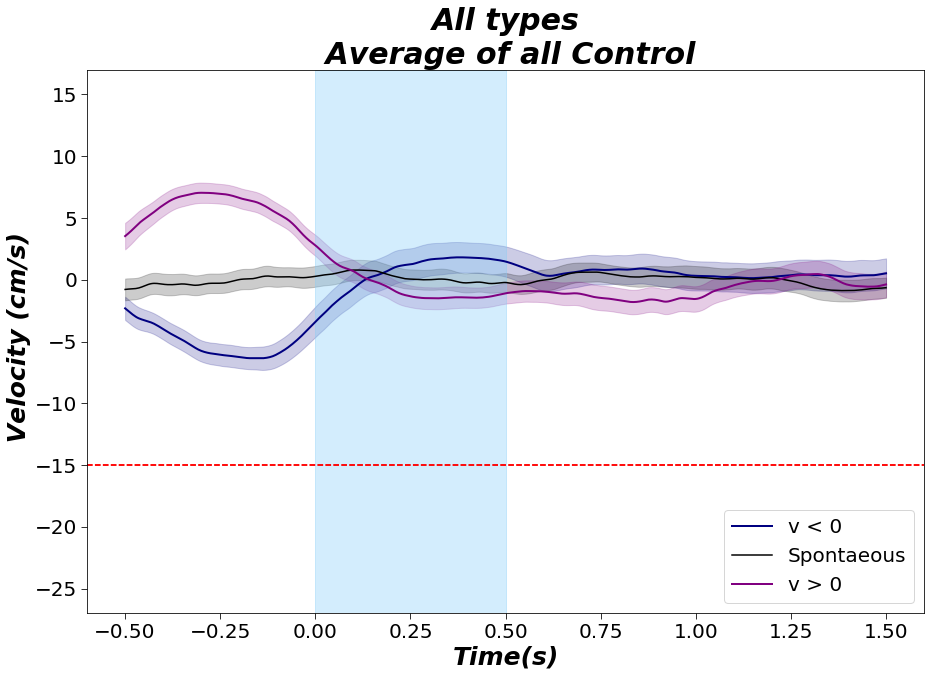

In [8]:
where_plot, which_plot, what_plot = [0,1],0,1 # decide to average over what and coordinates
cor = cor_list[which_plot] # gets either x or y by user


folder = "Square_1_mW"
path =pre_direct+'data_npz/'+folder+'/Control/'
extension_summary = ".npz"
Summary_files_list = list_all_files(path,extension_summary)
epochs_all_ctr = np.empty((0,pre_interval+interval+post_interval+1))
epochs_spont_all_ctr = np.empty((0,pre_interval+interval+post_interval+1))
count = 0
for file in Summary_files_list:
    count = count+1
    print(file)
    dat = npzfile = np.load(path+file)
    print(dat.files)
    properties=file.split("_")
    epochs_all_ctr = np.append(epochs_all_ctr,dat['epochs_all_mice'], axis = 0)# construct an array of all the trial epochs of all mice
    epochs_spont_all_ctr = np.append(epochs_spont_all_ctr,dat['epochs_spont_all_mice'], axis = 0)# construct an array of all the trial epochs of all mice

#     epochs_spont_all_ctr = np.zeros((epochs_all_ctr.shape))
    global mouse_type; global opto_par
    mouse_type = 'All types'
    opto_par = properties[1]
    
opto_par = 'Control'
pre_v = np.average(epochs_all_ctr[:,:pre_stim_inter],axis = 1)
ind_less,  = np.where(pre_v < 0)
epochs_v_less = epochs_all_ctr[ind_less,:]
ind_more,  = np.where(pre_v > 0)
epochs_v_more = epochs_all_ctr[ind_more,:]
ind_spont  = np.random.randint(epochs_spont_all_ctr.shape[0], size=int((len(ind_more)+len(ind_less))/2))
path = '/home/shiva/Desktop/Shiva_Behavior/data_npz/Distinction/Control'
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10), sharey=True)
plot_pre_on_post_v(epochs_v_less,epochs_spont_all_ctr[ind_spont],'navy','v < 0', spont = True)
plot_pre_on_post_v(epochs_v_more,np.zeros((epochs_v_less.shape)),'purple','v > 0',spont = False)
plt.savefig(path+'/V_distinction'+'_'+folder+"_"+opto_par+'_'+ cor+ '_Velociy_' +
                str(n_timebin)+ '_mov_ave_win='+str(window)+'_pre_post_stim.pdf',bbox_inches='tight',
                orientation='landscape',dpi=300)

## Look at average position by pre-laser velocity distinction

FoxP2_ChR2_Square_1_mW_pre_x_pre_v_pre_stim_inter=125_mov_aver=10_n_t=30.npz
(711,)
FoxP2_x_ChR2_Square_1_mW_mov_aver=10_n_t=30.npz
['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice']
24.10706964955898


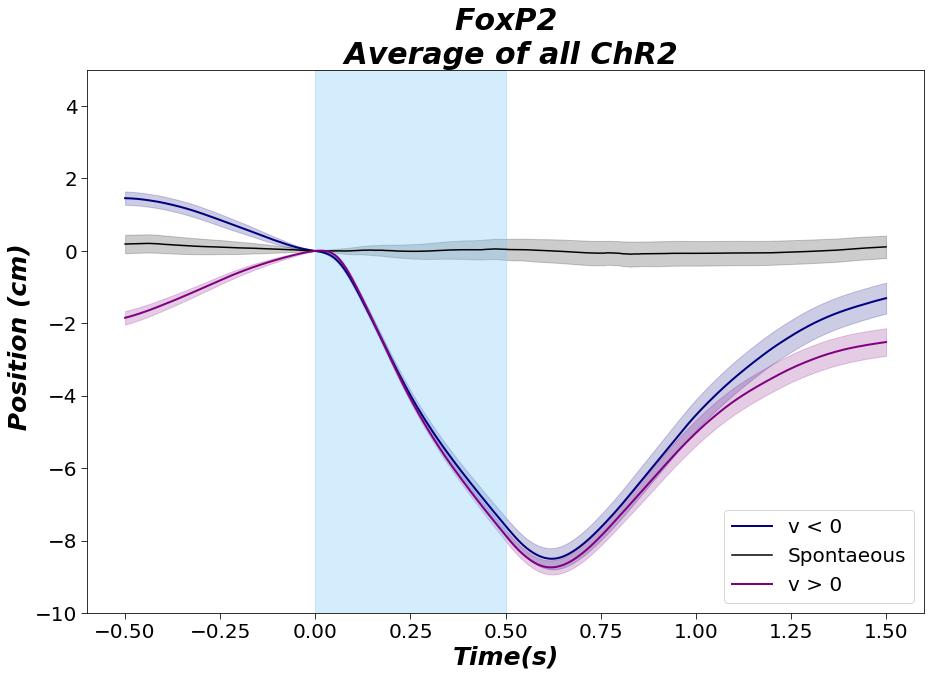

In [80]:
def plot_pre_on_post_v(epochs,epochs_spont,color,label,spont ):
    ''' plot (pre Laser/ON-Laser/post Laser) velocity comparison between active trials and spontaneous'''
    
    epochs_mean = np.average(epochs, axis = 0) # average over different stimuli
    epochs_mean_spont = np.average(epochs_spont, axis = 0) # average over different stimuli

    confidence_inter = np.empty((0,2), int)
    
    if len(epochs.shape) > 1 :
        epochs_mean = np.average(epochs, axis = 0)
        epochs_mean_spont = np.average(epochs_spont, axis = 0)
        
        for i in range (epochs.shape[1]): #calculate the two sided confidence interval for every timestep
            m = [sms.DescrStatsW(epochs[:,i]).tconfint_mean(alpha=0.05, alternative='two-sided')]
            confidence_inter = np.append(confidence_inter,[[m[0][0],m[0][1]]],axis=0)
        confidence_inter_spont = np.empty((0,2), int)
        
        for i in range (epochs_spont.shape[1]):
            m = [sms.DescrStatsW(epochs_spont[:,i]).tconfint_mean(alpha=0.05, alternative='two-sided')]
            confidence_inter_spont = np.append(confidence_inter_spont,[[m[0][0],m[0][1]]],axis=0)
    else:
        epochs_mean = epochs
        epochs_mean_spont = epochs_spont
        confidence_inter = np.zeros(((epochs_mean.shape[0]),2))
        confidence_inter_spont = np.zeros((epochs_mean.shape[0],2))
    time_series = np.arange(-pre_interval,interval+post_interval+1)/fps
    
    plt1,=plt.plot(time_series, epochs_mean, color = color, label = label , linestyle='-',linewidth=2)#, marker='o',markersize=1)
    plt.fill_between(time_series, confidence_inter[:,0],  confidence_inter[:,1], color=color, alpha=0.2)
    
    if spont == True:
        plt2,=plt.plot(time_series, epochs_mean_spont, color = 'k', label = "Spontaeous")
        plt.fill_between(time_series, confidence_inter_spont[:,0],  confidence_inter_spont[:,1], color='k', alpha=0.2)
    
    plt.axvspan(0, interval/fps, alpha=0.2, color='lightskyblue')


    if plot_param_list[what_plot] == 'velocity':
        plt.ylabel(" Velocity (cm/s)").set_fontproperties(font_label)
    else:
        plt.ylabel(" Position (cm)").set_fontproperties(font_label)
        
    plt.axhline( y = treadmil_velocity, ls='--', c='red')
    
    plt.xlabel("Time(s)").set_fontproperties(font_label)
    plt.ylim(-10,5) #set limits
    plt.legend(fontsize = 10)
#     plt.xlim(-.5,2) #set limits

#     handles =np.array([plt1,plt2])
    
    ax.get_xaxis().set_tick_params(direction='out',labelsize = 20 ,length=6)
    ax.xaxis.set_ticks_position('bottom')
    ax.get_yaxis().set_tick_params(direction='out',labelsize = 20, length=6)
    ax.yaxis.set_ticks_position('left')
    plt.legend(loc = 'lower right',fontsize =20)

#     plt.legend(handles=handles[handles_ind].tolist(),labels=labels,loc = 'lower right',fontsize =20)
    plt.title( mouse_type+"\n"+" Average of all "+opto_par).set_fontproperties(font)
#     plt.axhline( y = 17, ls='--', c='g')
   


where_plot,which_plot, what_plot = [0,1],0,0 # decide to average over what and coordinates
cor = cor_list[which_plot] # gets either x or y by user

mouse_type = 'D2' ; folder = 'STR'
# mouse_type = 'FoxP2' ; folder = 'GP'

path = os.path.join(pre_direct,'data_npz','Distinction','ChR2',mouse_type,folder)
files = list_all_files(path,".npz")
file = files[0]
print(file)
dat = np.load(os.path.join(path_main,file))
properties=file.split("_")
epochs = dat[dat.files[0]]
pre_v = dat[dat.files[2]]
print(pre_v.shape)
ind_less,  = np.where(pre_v < 0)
ind_more,  = np.where(pre_v > 0)
folder = "Square_1_mW"

extension_summary = ".npz"
path_main = os.path.join(pre_direct,'data_npz',folder,'ChR2')
summary_files_list = list_all_files(os.path.join(pre_direct,'data_npz',folder,'ChR2'),extension_summary)
for file in summary_files_list:
    if file.split("_")[0] == mouse_type:
        print(file)
        dat = np.load(os.path.join(path_main,file))
        print(dat.files)
        epochs_spont = dat['epochs_spont_all_mice']
        print(np.max(epochs_spont))
        epochs_less = dat['epochs_all_mice'][ind_less]
        epochs_more = dat['epochs_all_mice'][ind_more]
        break
        
pre_interval = int(.5*fps) # interval before laser onset
post_interval = int(.5*fps*2) # interval after laser onset

pre_v = dat[dat.files[2]]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10), sharey=True)
plot_pre_on_post_v(epochs_less,epochs_spont[:epochs_less.shape[0]],'navy','v < 0', spont = True)
plot_pre_on_post_v(epochs_more,np.zeros((epochs_less.shape)),'purple','v > 0',spont = False)
plt.savefig(os.path.join(path,'X_distinction'+'_'+folder+"_"+opto_par+'_'+mouse_type+'_'+ cor+ '_Velociy_' +
                str(n_timebin)+ '_mov_ave_win='+str(window)+'_pre_post_stim.pdf'),bbox_inches='tight',
                orientation='landscape',dpi=300)

## Look at the results of different intensity on FoxP2

### Beta

FoxP2_ChR2_Beta_0-5_mW_mov_aver=10_n_t=30_x_Tail_Nose.npz
['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice']
FoxP2_ChR2_Beta_1_mW_mov_aver=10_n_t=30_x_Tail_Nose.npz
['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice']
FoxP2_ChR2_Beta_2_mW_mov_aver=10_n_t=30_x_Tail_Nose.npz
['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice']
FoxP2_ChR2_Beta_5_mW_mov_aver=10_n_t=30_x_Tail_Nose.npz
['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice']
FoxP2_Control_Beta_5_mW_mov_aver.npz
['epochs_all_mice', 'epochs_mean_each_mouse']


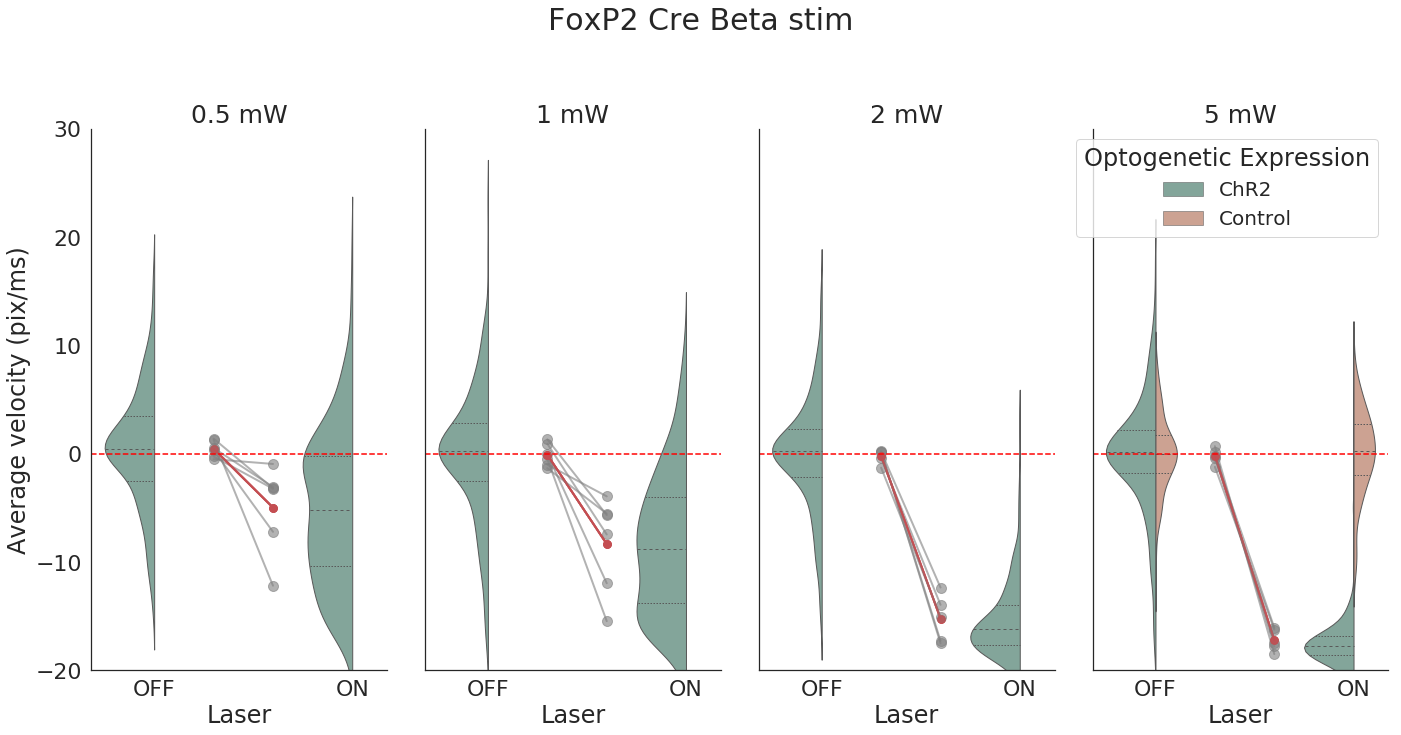

In [28]:
interval = 125 # number of timebins of stimulation 
fps = 250
pre_interval = int(.5*fps) # interval before laser onset
post_interval = int(.5*fps*2) # interval after laser onset

#path = "/Users/apple/Desktop/data_npz/"
path = os.path.join(pre_direct,'data_npz','Beta_FoxP2')
extension = ".npz"
Summary_files_list = list_all_files(path,extension)
col_names =  ['mean_velocity', 'mouse_type', 'optogenetic expression', 'pulse_type','intensity_mW','epoch']
result = pd.DataFrame(columns = col_names)



for file in Summary_files_list:
    print(file)
    dat = npzfile = np.load(os.path.join(path,file))
    properties=file.split("_")
    epochs = dat[dat.files[0]]
    print(dat.files)
    ## data for individual plot points of mice
    if properties[3]=='0-5' and properties[1] != 'Control':
        epochs_mean_mouse_0_5 = dat[dat.files[1]]
        min_arg_0_25 = np.argmin(epochs[:,pre_interval+1:pre_interval+interval+1], axis = 1)
    if properties[3]=='1'and properties[1] != 'Control':
        epochs_mean_mouse_1 = dat[dat.files[1]]
    if properties[3]=='2'and properties[1] != 'Control':
        epochs_mean_mouse_2 = dat[dat.files[1]]
    if properties[3]=='5'and properties[1] != 'Control':
        epochs_mean_mouse_5 = dat[dat.files[1]]

    pre = epochs[:,:pre_interval] ; post = epochs[:,pre_interval+1:pre_interval+interval+1]
    mouse_type_ = [properties[0]] * epochs.shape[0]*2
    opto_par_ = [properties[1]] * epochs.shape[0]*2
    pulse_ = [properties[2]] * epochs.shape[0]*2
#     intensity, data_type = properties[4].split('.')
    inten_ = [properties[3]] * epochs.shape[0]*2
  
    off_vel = np.average(pre,axis = 1)
    on_vel = np.average(post,axis = 1)
    all_ = np.concatenate((off_vel,on_vel),axis = 0)
    epoch_off = ['OFF'] * epochs.shape[0]
    epoch_on = ['ON'] * epochs.shape[0]
    epoch_ = epoch_off+epoch_on
    df = pd.DataFrame(({'mean_velocity':all_, 
                        'mouse_type':mouse_type_, 'optogenetic expression':opto_par_, 'pulse_type':pulse_,
                        'intensity_mW':inten_,'epoch':epoch_}))
    frames = [result, df]
    result = pd.concat(frames,ignore_index=True)
# print(result.head())

import seaborn as sns

# g = sns.FacetGrid(result, col="mouse_type", size=5, aspect=1.5)
sns.set_style("white")
# path = "/Users/apple/Desktop/data_npz/"

g = sns.catplot(x="epoch", y="mean_velocity",
                hue="optogenetic expression", col="intensity_mW",
                data=result, kind="violin", split=True, palette = sns.color_palette("Set2", n_colors=2, desat=.5),
                height=5, scale_hue=False, linewidth = 1, inner="quartile", scale = 'count',
                hue_order=['ChR2','Control'],col_order=['0-5','1','2', '5'],legend = False,width=.5)
x_series = [0.3,0.6]
ax1, ax2, ax3, ax4 = g.axes[0]
for i in range (epochs_mean_mouse_0_5.shape[0]):
    ax1.plot(x_series,epochs_mean_mouse_0_5[i,:2],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
    ax1.plot(x_series,np.average(epochs_mean_mouse_0_5[:,:2],axis =0),'-',color = 'r',marker = '.',markersize=15,linewidth=2,alpha=0.6)

for i in range (epochs_mean_mouse_1.shape[0]):
    ax2.plot(x_series,epochs_mean_mouse_1[i,:2],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
    ax2.plot(x_series,np.average(epochs_mean_mouse_1[:,:2],axis =0),'-',color = 'r',marker = '.',markersize=15,linewidth=2,alpha=0.6)

for i in range (epochs_mean_mouse_2.shape[0]):
    ax3.plot(x_series,epochs_mean_mouse_2[i,:2],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
    ax3.plot(x_series,np.average(epochs_mean_mouse_2[:,:2],axis =0),'-',color = 'r',marker = '.',markersize=15,linewidth=2,alpha=0.6)
for i in range (epochs_mean_mouse_5.shape[0]):
    ax4.plot(x_series,epochs_mean_mouse_5[i,:2],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
    ax4.plot(x_series,np.average(epochs_mean_mouse_5[:,:2],axis =0),'-',color = 'r',marker = '.',markersize=15,linewidth=2,alpha=0.6)

sns.set(font_scale = 2)
sns.set_style("white")
plt.ylim([-20,30])
ax1, ax2, ax3 , ax4= g.axes[0]
ax1.axhline( y=0, ls='--', c='red')
ax2.axhline( y=0, ls='--', c='red')
ax3.axhline( y=0, ls='--', c='red')
ax4.axhline( y=0, ls='--', c='red')
ax1.set_title('0.5 mW', y=0.95, fontsize = 25)
ax2.set_title('1 mW', y=0.95, fontsize = 25)
ax3.set_title('2 mW', y=0.95, fontsize = 25)
ax4.set_title('5 mW', y=0.95, fontsize = 25)

g.set_axis_labels("Laser", "Average velocity (pix/ms)")
plt.suptitle('FoxP2 Cre Beta stim',fontsize= 30,y = 1)
g.fig.set_figwidth(20.0)
g.fig.set_figheight(12)
legend = plt.legend(loc='upper right', title='Optogenetic Expression',fontsize= 20)
plt.savefig(os.path.join(path,'All_Beta_FoxP2.pdf'),bbox_inches='tight',orientation='landscape',dpi=350)



FoxP2_ChR2_Beta_0-5_mW_mov_aver=10_n_t=30_x_Tail_Nose.npz
['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice']
(289, 501)
FoxP2_ChR2_Beta_1_mW_mov_aver=10_n_t=30_x_Tail_Nose.npz
['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice']
(290, 501)
FoxP2_ChR2_Beta_2_mW_mov_aver=10_n_t=30_x_Tail_Nose.npz
['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice']
(356, 501)
FoxP2_ChR2_Beta_5_mW_mov_aver=10_n_t=30_x_Tail_Nose.npz
['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice']
(250, 501)
   mean_velocity mouse_type optogenetic expression pulse_type intensity_mW  \
0       0.579967      FoxP2                   ChR2       Beta          0-5   
1       2.457237      FoxP2                   ChR2       Beta          0-5   
2      -9.065263      FoxP2                   ChR2       Beta          0-5   
3       3.468745      FoxP2                   ChR2       Beta          0-5   
4       1.956481      FoxP2                   ChR2      

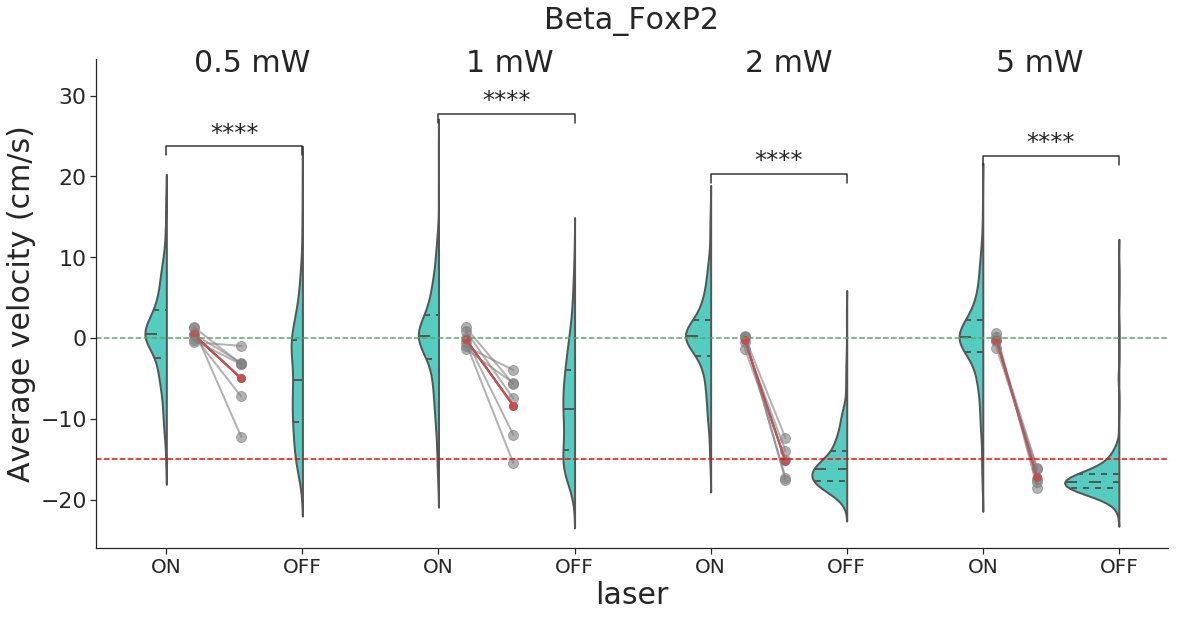

In [37]:
interval = 125 # number of timebins of stimulation 
fps = 250
pre_interval = int(.5*fps) # interval before laser onset
post_interval = int(.5*fps*2) # interval after laser onset
# folder = 'Square_FoxP2'
folder = 'Beta_FoxP2'

# path = "/Users/apple/Desktop/data_npz/"
path =pre_direct+'data_npz/'+folder+'/'
extension = ".npz"
Summary_files_list = list_all_files(path,extension)
col_names =  ['mean_velocity', 'mouse_type', 'optogenetic expression', 'pulse_type','intensity_mW','epoch']
result = pd.DataFrame(columns = col_names)


suffix = {'0-25':'L','0-5':'M','1':'L'}
c = 0
for file in Summary_files_list:
    print(file)
    dat = npzfile = np.load(path+file)
    properties=file.split("_")
    epochs = dat[dat.files[0]]
    print(dat.files)
    ## data for individual plot points of mice
    if properties[3]=='0-5' and properties[1] != 'Control':
        epochs_mean_mouse_0_5 = dat[dat.files[1]]
        min_arg_0_25 = np.argmin(epochs[:,pre_interval+1:pre_interval+interval+1], axis = 1)
    if properties[3]=='1'and properties[1] != 'Control':
        epochs_mean_mouse_1 = dat[dat.files[1]]
    if properties[3]=='2'and properties[1] != 'Control':
        epochs_mean_mouse_2 = dat[dat.files[1]]
    if properties[3]=='5'and properties[1] != 'Control':
        epochs_mean_mouse_5 = dat[dat.files[1]]
        
    pre = epochs[:,:pre_interval] ; post = epochs[:,pre_interval+1:pre_interval+interval+1]
    mouse_type_ = [properties[0]] * epochs.shape[0]*2
    opto_par_ = [properties[1]] * epochs.shape[0]*2
    pulse_ = [properties[2]] * epochs.shape[0]*2
#     intensity, data_type = properties[4].split('.')
    inten_ = [properties[3]] * epochs.shape[0]*2
  
    off_vel = np.average(pre,axis = 1)
    on_vel = np.average(post,axis = 1)
    all_ = np.concatenate((off_vel,on_vel),axis = 0)
    epoch_off = ['OFF'+properties[3]] * epochs.shape[0]
    print(epochs.shape)
    epoch_on = ['ON'+properties[3]] * epochs.shape[0]
    epoch_ = epoch_off+epoch_on
    df = pd.DataFrame(({'mean_velocity':all_, 
                        'mouse_type':mouse_type_, 'optogenetic expression':opto_par_, 'pulse_type':pulse_,
                        'intensity_mW':inten_,'epoch':epoch_}))
    frames = [result, df]
    result = pd.concat(frames,ignore_index=True)
    c +=1
print(result.head())
g = sns.catplot(x="epoch", y="mean_velocity",
                hue="optogenetic expression", 
                data=result, kind="violin",  palette= ['turquoise'],
                height=5,  scale_hue=False,linewidth = 2, inner="quartile",split=True,scale ='area',
                hue_order=['ChR2','Control'],legend = False, gridsize = 100 )
ax = g.axes[0]
axes = g.axes.flatten()
add_stat_annotation(axes[0], data=result,x="epoch", y="mean_velocity",hue="optogenetic expression",
                    box_pairs=[(("ON0-5","ChR2"), ("OFF0-5","ChR2")),(("ON1","ChR2"), ("OFF1","ChR2")),
                               (("ON2","ChR2"), ("OFF2","ChR2")), (("ON5","ChR2"), ("OFF5","ChR2"))],
                    test='Wilcoxon', text_format='star', loc='inside', verbose=2)
yy= 33
x_series = [0.2,0.55]
for i in range (epochs_mean_mouse_0_5.shape[0]):
    plt.plot(x_series,epochs_mean_mouse_0_5[i,:2],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
    plt.plot(x_series,np.average(epochs_mean_mouse_0_5[:,:2],axis =0),'-',color = 'r',marker = '.',markersize=15,linewidth=2,alpha=0.6)
plt.text(min(x_series), yy, '0.5 mW', fontsize=30)
x_series = [2.2,2.55]
for i in range (epochs_mean_mouse_1.shape[0]):
    plt.plot(x_series,epochs_mean_mouse_1[i,:2],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
    plt.plot(x_series,np.average(epochs_mean_mouse_1[:,:2],axis =0),'-',color = 'r',marker = '.',markersize=15,linewidth=2,alpha=0.6)

plt.text(min(x_series), yy, '1 mW', fontsize=30)

x_series = [4.25,4.55]
for i in range (epochs_mean_mouse_2.shape[0]):
    plt.plot(x_series,epochs_mean_mouse_2[i,:2],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
    plt.plot(x_series,np.average(epochs_mean_mouse_2[:,:2],axis =0),'-',color = 'r',marker = '.',markersize=15,linewidth=2,alpha=0.6)
plt.text(min(x_series), yy, '2 mW', fontsize=30)

x_series = [6.1,6.4]
for i in range (epochs_mean_mouse_5.shape[0]):
    plt.plot(x_series,epochs_mean_mouse_5[i,:2],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
    plt.plot(x_series,np.average(epochs_mean_mouse_5[:,:2],axis =0),'-',color = 'r',marker = '.',markersize=15,linewidth=2,alpha=0.6)
plt.text(min(x_series), yy, '5 mW', fontsize=30)

sns.set(font_scale = 2)
sns.set_style("white")


plt.axhline( y=0, ls='--', c='g')
plt.axhline( y=treadmil_velocity, ls='--', c='red')

axes[0].set_xlabel("laser",fontsize=30)
axes[0].set_ylabel("Average velocity (cm/s)",fontsize=30)
axes[0].get_xaxis().set_tick_params(direction='out')
axes[0].xaxis.set_ticks_position('bottom')
axes[0].get_yaxis().set_tick_params(direction='out')
axes[0].yaxis.set_ticks_position('left')
axes[0].set_title(folder,fontsize = 30,pad = 30)

axes[0].set_xticklabels(['ON','OFF', 'ON','OFF', 'ON','OFF','ON','OFF'],fontsize = 20)
# plt.title(folder).set_fontproperties(font)
g.fig.set_figwidth(25.0)
g.fig.set_figheight(10)
# legend = plt.legend(loc='upper right', title='Optogenetic Expression',fontsize= 20)
plt.savefig(path+'All_'+folder+'.pdf',bbox_inches='tight',orientation='landscape',dpi=350)



### Square

FoxP2_ChR2_Square_0-25_mW_mov_aver=10_n_t=30_x_Tail_Nose.npz
['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice']
(245, 501)
FoxP2_ChR2_Square_0-5_mW_mov_aver=10_n_t=30_x_Tail_Nose.npz
['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice']
(316, 501)
FoxP2_ChR2_Square_1_mW_mov_aver=10_n_t=30_x_Tail_Nose.npz
['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice']
(711, 501)
FoxP2_Control_Square_1_mW_mov_aver=10_n_t=30_x_Tail_Nose.npz
['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice']
(223, 501)
   mean_velocity mouse_type optogenetic expression pulse_type intensity_mW  \
0      -0.286812      FoxP2                   ChR2     Square         0-25   
1       6.751397      FoxP2                   ChR2     Square         0-25   
2       6.152413      FoxP2                   ChR2     Square         0-25   
3      -3.882456      FoxP2                   ChR2     Square         0-25   
4       2.883658      FoxP2               

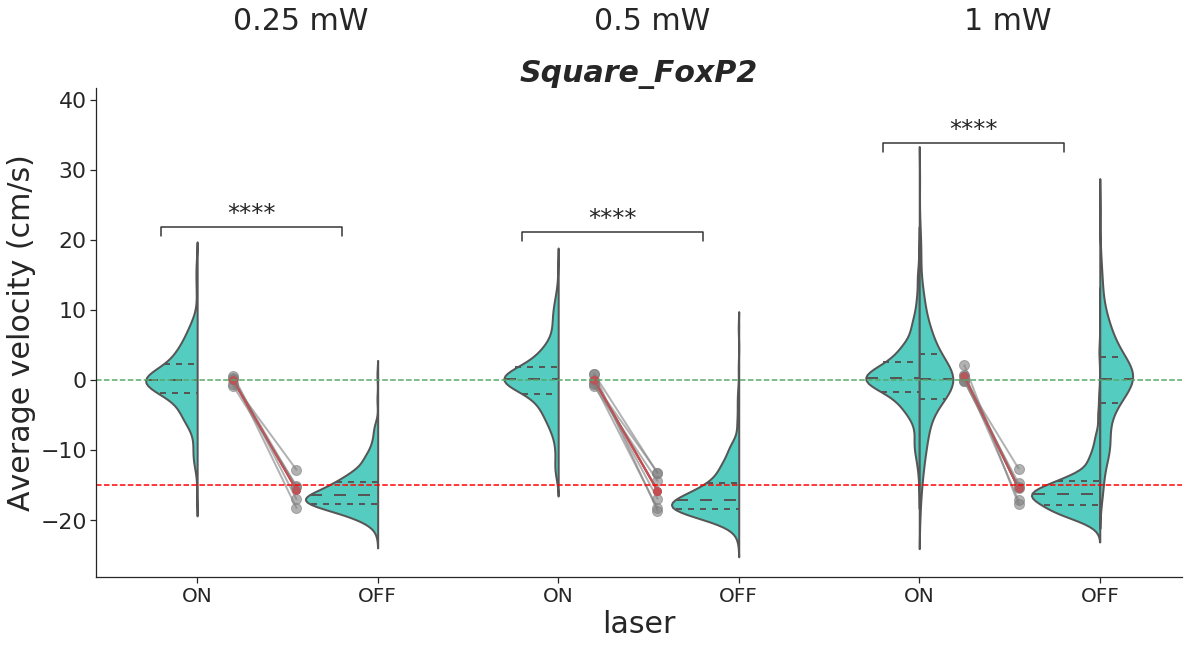

In [17]:
interval = 125 # number of timebins of stimulation 
fps = 250
pre_interval = int(.5*fps) # interval before laser onset
post_interval = int(.5*fps*2) # interval after laser onset
folder = 'Square_FoxP2'
#path = "/Users/apple/Desktop/data_npz/"
path = os.path.join(pre_direct,'data_npz','Square_FoxP2')
extension = ".npz"
Summary_files_list = list_all_files(path,extension)
col_names =  ['mean_velocity', 'mouse_type', 'optogenetic expression', 'pulse_type','intensity_mW','epoch']
result = pd.DataFrame(columns = col_names)


suffix = {'0-25':'L','0-5':'M','1':'L'}
c = 0
for file in Summary_files_list:
    print(file)
    dat = npzfile = np.load(path+file)
    properties=file.split("_")
    epochs = dat[dat.files[0]]
    print(dat.files)
    ## data for individual plot points of mice
    if properties[3]=='0-25' and properties[1] != 'Control':
        epochs_mean_mouse_0_25 = dat[dat.files[1]]
        min_arg_0_25 = np.argmin(epochs[:,pre_interval+1:pre_interval+interval+1], axis = 1)
    if properties[3]=='0-5'and properties[1] != 'Control':
        epochs_mean_mouse_0_5 = dat[dat.files[1]]
    if properties[3]=='1'and properties[1] != 'Control':
        epochs_mean_mouse_1 = dat[dat.files[1]]


    pre = epochs[:,:pre_interval] ; post = epochs[:,pre_interval+1:pre_interval+interval+1]
    mouse_type_ = [properties[0]] * epochs.shape[0]*2
    opto_par_ = [properties[1]] * epochs.shape[0]*2
    pulse_ = [properties[2]] * epochs.shape[0]*2
#     intensity, data_type = properties[4].split('.')
    inten_ = [properties[3]] * epochs.shape[0]*2
  
    off_vel = np.average(pre,axis = 1)
    on_vel = np.average(post,axis = 1)
    all_ = np.concatenate((off_vel,on_vel),axis = 0)
    epoch_off = ['OFF'+properties[3]] * epochs.shape[0]
    print(epochs.shape)
    epoch_on = ['ON'+properties[3]] * epochs.shape[0]
    epoch_ = epoch_off+epoch_on
    df = pd.DataFrame(({'mean_velocity':all_, 
                        'mouse_type':mouse_type_, 'optogenetic expression':opto_par_, 'pulse_type':pulse_,
                        'intensity_mW':inten_,'epoch':epoch_}))
    frames = [result, df]
    result = pd.concat(frames,ignore_index=True)
    c +=1
print(result.head())
g = sns.catplot(x="epoch", y="mean_velocity",
                hue="optogenetic expression", 
                data=result, kind="violin",  palette= ['turquoise'],
                height=5,  scale_hue=False,linewidth = 2, inner="quartile",split=True,scale ='area',
                hue_order=['ChR2','Control'],legend = False, gridsize = 100 )
ax = g.axes[0]
axes = g.axes.flatten()
add_stat_annotation(axes[0], data=result,x="epoch", y="mean_velocity",hue="optogenetic expression",
                    box_pairs=[(("ON0-25","ChR2"), ("OFF0-25","ChR2")),(("ON0-5","ChR2"), ("OFF0-5","ChR2")),
                               (("ON1","ChR2"), ("OFF1","ChR2"))],
                    test='Wilcoxon', text_format='star', loc='inside', verbose=2)
x_series = [0.2,0.55]
for i in range (epochs_mean_mouse_0_25.shape[0]):
    plt.plot(x_series,epochs_mean_mouse_0_25[i,:2],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
    plt.plot(x_series,np.average(epochs_mean_mouse_0_25[:,:2],axis =0),'-',color = 'r',marker = '.',markersize=15,linewidth=2,alpha=0.6)
plt.text(min(x_series), 50, '0.25 mW', fontsize=30)
x_series = [2.2,2.55]
for i in range (epochs_mean_mouse_0_5.shape[0]):
    plt.plot(x_series,epochs_mean_mouse_0_5[i,:2],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
    plt.plot(x_series,np.average(epochs_mean_mouse_0_5[:,:2],axis =0),'-',color = 'r',marker = '.',markersize=15,linewidth=2,alpha=0.6)

plt.text(min(x_series), 50, '0.5 mW', fontsize=30)

x_series = [4.25,4.55]
for i in range (epochs_mean_mouse_1.shape[0]):
    plt.plot(x_series,epochs_mean_mouse_1[i,:2],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
    plt.plot(x_series,np.average(epochs_mean_mouse_1[:,:2],axis =0),'-',color = 'r',marker = '.',markersize=15,linewidth=2,alpha=0.6)
plt.text(min(x_series), 50, '1 mW', fontsize=30)

sns.set(font_scale = 2)
sns.set_style("white")


plt.axhline( y=0, ls='--', c='g')
plt.axhline( y=treadmil_velocity, ls='--', c='red')

axes[0].set_xlabel("laser",fontsize=30)
axes[0].set_ylabel("Average velocity (cm/s)",fontsize=30)
axes[0].get_xaxis().set_tick_params(direction='out')
axes[0].xaxis.set_ticks_position('bottom')
axes[0].get_yaxis().set_tick_params(direction='out')
axes[0].yaxis.set_ticks_position('left')

axes[0].set_xticklabels(['ON','OFF', 'ON','OFF', 'ON','OFF'],fontsize = 20)
plt.title(folder).set_fontproperties(font)
g.fig.set_figwidth(25.0)
g.fig.set_figheight(10)
# legend = plt.legend(loc='upper right', title='Optogenetic Expression',fontsize= 20)
plt.savefig(os.path.join(path,'All_'+folder+'.pdf'),bbox_inches='tight',orientation='landscape',dpi=350)



# Compare STN with STN+GP and  GP alone

VGlut_ChR2_GP_15_mW_mov_aver=10_n_t=30.npz
['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice']
VGlut_ChR2_STN+GP_1_mW_mov_aver=10_n_t=30.npz
['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice']
VGlut_ChR2_STN_1_mW_mov_aver=10n_t=30.npz
['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

OFFSTN_ChR2 v.s. ONSTN_ChR2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.539e-02 U_stat=2.832e+05
OFFSTN+GP_ChR2 v.s. ONSTN+GP_ChR2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.413e-15 U_stat=8.648e+05
OFFGP_ChR2 v.s. ONGP_ChR2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.399e-48 U_stat=5.321e+05


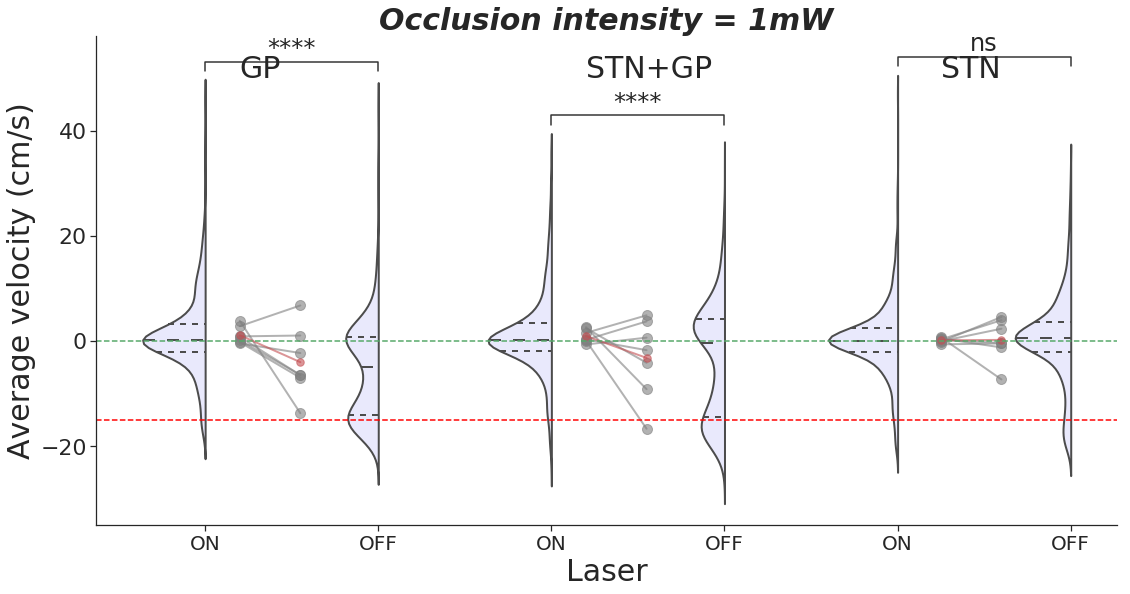

In [10]:
interval = 125 # number of timebins of stimulation 
fps = 250
pre_interval = int(.5*fps) # interval before laser onset
post_interval = int(.5*fps*2) # interval after laser onset

# path = "/Users/apple/Desktop/data_npz/"
path =os.path.join(pre_direct,'data_npz','Occlusion')
extension = ".npz"
Summary_files_list = list_all_files(path,extension)
col_names =  ['mean_velocity', 'mouse_type','optogenetic expression', 'pulse_type','intensity_mW','epoch']
result = pd.DataFrame(columns = col_names)



for file in Summary_files_list:
    print(file)
    dat = npzfile = np.load(os.path.join(path,file))
    properties=file.split("_")
    epochs = dat[dat.files[0]]
    print(dat.files)
    ## data for individual plot points of mice
    if properties[2]=='GP' and properties[1] != 'Control':
        epochs_mean_mouse_GP = dat[dat.files[1]]
        min_arg_0_25 = np.argmin(epochs[:,pre_interval+1:pre_interval+interval+1], axis = 1)
    if properties[2]=='STN'and properties[1] != 'Control':
        epochs_mean_mouse_STN = dat[dat.files[1]]
    if properties[2]=='STN+GP'and properties[1] != 'Control':
        epochs_mean_mouse_STN_GP = dat[dat.files[1]]

    pre = epochs[:,:pre_interval] ; post = epochs[:,pre_interval+1:pre_interval+interval+1]
    mouse_type_ = [properties[0]] * epochs.shape[0]*2
    opto_par_ = [properties[1]] * epochs.shape[0]*2
    pulse_ = [properties[2]] * epochs.shape[0]*2
#     intensity, data_type = properties[4].split('.')
    inten_ = [properties[3]] * epochs.shape[0]*2
  
    off_vel = np.average(pre,axis = 1)
    on_vel = np.average(post,axis = 1)
    all_ = np.concatenate((off_vel,on_vel),axis = 0)
#     epoch_off = ['OFF'] * epochs.shape[0]
#     epoch_on = ['ON'] * epochs.shape[0]
    epoch_off = ['OFF'+properties[2]] * epochs.shape[0]
    epoch_on = ['ON'+properties[2]] * epochs.shape[0]
    epoch_ = epoch_off+epoch_on
    df = pd.DataFrame(({'mean_velocity':all_, 
                        'mouse_type':mouse_type_, 'optogenetic expression':opto_par_, 'pulse_type':pulse_,
                        'intensity_mW':inten_,'epoch':epoch_}))
    frames = [result, df]
    result = pd.concat(frames,ignore_index=True)
# print(result.head())

import seaborn as sns

# g = sns.FacetGrid(result, col="mouse_type", size=5, aspect=1.5)
sns.set_style("white")

g = sns.catplot(x="epoch", y="mean_velocity",
                hue="optogenetic expression",
                data=result, kind="violin", color = 'blue',

                height=5, scale_hue=False, linewidth = 2, inner="quartile",split=True,scale ='area', 
                box_pairs=[(("ONSTN","ChR2"), ("OFFSTN","ChR2")), (("ONSTN+GP","ChR2"), ("OFFSTN+GP","ChR2"))
                               , (("ONGP","ChR2"), ("OFFGP","ChR2"))],
                hue_order=['ChR2','Control'],legend = False, gridsize = 100)

axes = g.axes.flatten()


add_stat_annotation(axes[0], data=result,x="epoch", y="mean_velocity",hue="optogenetic expression",
                    box_pairs=[(("ONSTN","ChR2"), ("OFFSTN","ChR2")), (("ONSTN+GP","ChR2"), ("OFFSTN+GP","ChR2"))
                               , (("ONGP","ChR2"), ("OFFGP","ChR2"))],
                    test='Mann-Whitney', text_format='star', loc='inside', verbose=2)

x_series = [0.2,0.55]
plt.text(min(x_series), 50, 'GP', fontsize=30)
for i in range (epochs_mean_mouse_GP.shape[0]):
    plt.plot(x_series,epochs_mean_mouse_GP[i,:2],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
plt.plot(x_series,np.average(epochs_mean_mouse_GP[:,:2],axis =0),'-',color = 'r',marker = '.',markersize=15,linewidth=2,alpha=0.6)

x_series = [2.2,2.55]
plt.text(min(x_series), 50, 'STN+GP', fontsize=30)
for i in range (epochs_mean_mouse_STN_GP.shape[0]):
    plt.plot(x_series,epochs_mean_mouse_STN_GP[i,:2],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
plt.plot(x_series,np.average(epochs_mean_mouse_STN_GP[:,:2],axis =0),'-',color = 'r',marker = '.',markersize=15,linewidth=2,alpha=0.6)

x_series = [4.25,4.6]
plt.text(min(x_series), 50, 'STN', fontsize=30)
for i in range (epochs_mean_mouse_STN.shape[0]):
    plt.plot(x_series,epochs_mean_mouse_STN[i,:2],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
plt.plot(x_series,np.average(epochs_mean_mouse_STN[:,:2],axis =0),'-',color = 'r',marker = '.',markersize=15,linewidth=2,alpha=0.6)

sns.set(font_scale = 2)
sns.set_style("white")
plt.ylim([-35,58])



plt.axhline( y=0, ls='--', c='g')
plt.axhline( y=treadmil_velocity, ls='--', c='red')


axes[0].set_xlabel("laser",fontsize=30)
axes[0].set_ylabel("Average velocity (cm/s)",fontsize=30)
axes[0].get_xaxis().set_tick_params(direction='out')
axes[0].xaxis.set_ticks_position('bottom')
axes[0].get_yaxis().set_tick_params(direction='out')
axes[0].yaxis.set_ticks_position('left')

axes[0].set_xticklabels(['ON','OFF', 'ON','OFF', 'ON','OFF'],fontsize = 20)
g.set_axis_labels("Laser", "Average velocity (cm/s)")
# plt.suptitle('Occlusion 1 mW',fontsize= 30,y = 1)
plt.title("Occlusion"+" intensity = "+properties[3]+"mW").set_fontproperties(font)
g.fig.set_figwidth(25.0)
g.fig.set_figheight(10)
# legend = plt.legend(loc='upper right', title='Optogenetic Expression',fontsize= 20)
plt.savefig(os.path.join(path,'All_Occlusion.png'),bbox_inches='tight',orientation='landscape',dpi=350)



# In the next cells we look at the violin plots of all the data for different intensities

## Intensity = 1 mW (ChR2 animals)

D2_ChR2_Square_1_mW_mov_aver=10_n_t=30_x_Tail_Nose.npz
OFF 0.6843266091792217 0.2727475775524336
ON -6.218373787335728 0.3048984560131043
WilcoxonResult(statistic=47397.0, pvalue=2.222113860020907e-55)
(748, 501)
FoxP2_ChR2_Square_1_mW_mov_aver=10_n_t=30_x_Tail_Nose.npz
OFF 0.5661863147305561 0.1791691732354736
ON -15.53516299719703 0.1389916197424667
WilcoxonResult(statistic=1395.0, pvalue=1.6128116022792367e-115)
(711, 501)
VGlut_ChR2_Square_1_mW_mov_aver=10_n_t=30_x_Tail_Nose.npz
OFF 0.14206222249997538 0.24466542348320575
ON 0.32719463404749827 0.3006221559223246
WilcoxonResult(statistic=143970.0, pvalue=0.22884214219406707)
(778, 501)
   mean_velocity mouse_type optogenetic expression pulse_type intensity_mW  \
0      11.328526         D2                   ChR2     Square            1   
1       4.193047         D2                   ChR2     Square            1   
2       7.026098         D2                   ChR2     Square            1   
3     -11.418524         D2             

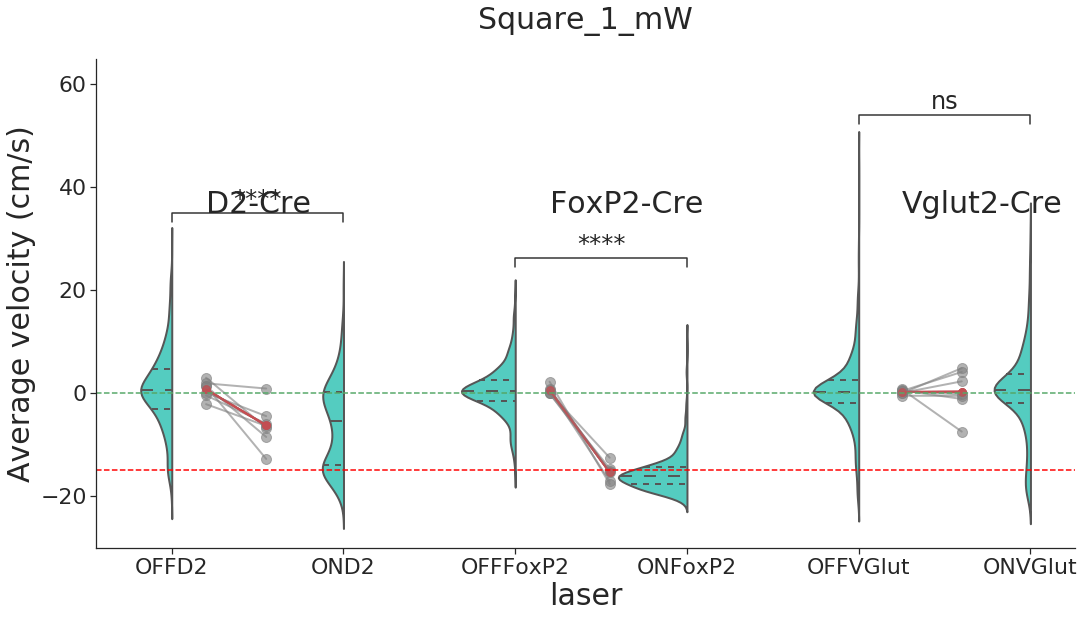

In [7]:

# path = "/Users/apple/Desktop/data_npz/"
folder = "Square_1_mW"
# folder = "Beta_1_mW"
# folder = "Beta_0-5_mW"

path = os.path.join(pre_direct,'data_npz',folder,'ChR2')
extension_summary = ".npz"
Summary_files_list = list_all_files(path,extension_summary)
col_names =  ['mean_velocity', 'mouse_type', 'optogenetic expression', 'pulse_type','intensity_mW','epoch']
result = pd.DataFrame(columns = col_names)

# direct = pre_direct +mouse_type+'/'+opto_par+ '/Mouse_' +str(mouse_no)+ '/'  # directory to the folder for each mouse


for file in Summary_files_list:
    print(file)
    dat = npzfile = np.load(os.path.join(path,file))
    properties=file.split("_")
    epochs = dat[dat.files[0]]
    ## data for individual plot points of mice
    if properties[0]=='Vglut2' and properties[1] != 'Control':
        epochs_mean_mouse_Vglut2 = dat[dat.files[1]]
    if properties[0]=='D2'and properties[1] != 'Control':
        epochs_mean_mouse_D2 = dat[dat.files[1]]
    if properties[0]=='FoxP2'and properties[1] != 'Control':
        epochs_mean_mouse_FoxP2 = dat[dat.files[1]]
        
    pre = epochs[:,:pre_interval] ; post = epochs[:,pre_interval+1:pre_interval+interval+1]
    mouse_type_ = [properties[0]] * epochs.shape[0]*2
    opto_par_ = [properties[1]] * epochs.shape[0]*2
    pulse_ = [properties[2]] * epochs.shape[0]*2
    inten_ = [properties[3]] * epochs.shape[0]*2
    off_vel = np.average(pre,axis = 1)
    on_vel = np.average(post,axis = 1)
    stat_result = stats.mannwhitneyu(off_vel, on_vel, use_continuity=True, alternative='two-sided')
    
    stat_result = stats.wilcoxon(off_vel, on_vel, zero_method='pratt',alternative='two-sided')
    print("OFF",np.average(off_vel),stats.sem(off_vel))
    print("ON",np.average(on_vel),stats.sem(on_vel))

    print(stat_result)
    all_ = np.concatenate((off_vel,on_vel),axis = 0)
    epoch_off = ['OFF'+properties[0]] * epochs.shape[0]
    epoch_on = ['ON'+properties[0]] * epochs.shape[0]
    epoch_ = epoch_off+epoch_on
    print(epochs.shape)
    
    df = pd.DataFrame(({'mean_velocity':all_, 
                        'mouse_type':mouse_type_, 'optogenetic expression':opto_par_, 'pulse_type':pulse_,
                        'intensity_mW':inten_,'epoch':epoch_}))
    frames = [result, df]
    result = pd.concat(frames,ignore_index=True)
print(result.head())
import seaborn as sns
sns.set(font_scale = 2)
sns.set_style("white")

g = sns.catplot(x="epoch", y="mean_velocity",
                hue="optogenetic expression", 
                data=result, kind="violin",  palette= ['turquoise'],
                height=5,  scale_hue=False,linewidth = 2, inner="quartile",split=True,scale ='area',
                hue_order=['ChR2','Control'],legend = False, gridsize = 100 )
ax1 = g.axes[0]
axes = g.axes.flatten()
add_stat_annotation(axes[0], data=result,x="epoch", y="mean_velocity",hue="optogenetic expression",
                    box_pairs=[(("OND2","ChR2"), ("OFFD2","ChR2")), (("ONVglut2","ChR2"), ("OFFVglut2","ChR2"))
                               , (("ONFoxP2","ChR2"), ("OFFFoxP2","ChR2"))],
                    test='Wilcoxon', text_format='star', loc='inside', verbose=2)
x_series = [0.2,0.55]
yy = 35
plt.text(min(x_series), yy, 'D2-Cre', fontsize=30)
for i in range (epochs_mean_mouse_D2.shape[0]):
    plt.plot(x_series,epochs_mean_mouse_D2[i,:2],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
    plt.plot(x_series,np.average(epochs_mean_mouse_D2[:,:2],axis =0),'-',color = 'r',marker = '.',markersize=15,linewidth=2,alpha=0.6)
x_series = [4.25,4.6]
plt.text(min(x_series), yy, 'Vglut22-Cre', fontsize=30)
for i in range (epochs_mean_mouse_Vglut2.shape[0]):
    plt.plot(x_series,epochs_mean_mouse_Vglut2[i,:2],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
    plt.plot(x_series,np.average(epochs_mean_mouse_Vglut2[:,:2],axis =0),'-',color = 'r',marker = '.',markersize=15,linewidth=2,alpha=0.6)
x_series = [2.2,2.55]
plt.text(min(x_series), yy, 'FoxP2-Cre', fontsize=30)
for i in range (epochs_mean_mouse_FoxP2.shape[0]):
    
    plt.plot(x_series,epochs_mean_mouse_FoxP2[i,:2],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
    plt.plot(x_series,np.average(epochs_mean_mouse_FoxP2[:,:2],axis =0),'-',color = 'r',marker = '.',markersize=15,linewidth=2,alpha=0.6)

plt.axhline( y=0, ls='--', c='g')
plt.axhline( y=treadmil_velocity, ls='--', c='red')

axes[0].set_xlabel("laser",fontsize=30)
axes[0].set_ylabel("Average velocity (cm/s)",fontsize=30)
axes[0].get_xaxis().set_tick_params(direction='out')
axes[0].xaxis.set_ticks_position('bottom')
axes[0].get_yaxis().set_tick_params(direction='out')
axes[0].yaxis.set_ticks_position('left')
axes[0].set_ylabel("Average velocity (cm/s)",fontsize=30)

axes[0].set_title(folder,fontsize = 30,pad = 30)
# plt.title(folder,y=1.2).set_fontproperties(font)
g.fig.set_figwidth(25.0)
g.fig.set_figheight(10)
# legend = plt.legend(loc='upper right', title='Optogenetic Expression',fontsize= 20)
plt.savefig(os.path.join(path,folder+'_ChR2.pdf'),bbox_inches='tight',orientation='landscape',dpi=500)



## MWW test comparing ChR2 to Control within group

In [9]:
MWW_test(result,result_Ctr,"D2")
MWW_test(result,result_Ctr,"FoxP2")
MWW_test(result,result_Ctr,"Vglut2")

MWW ChR2 vs. Ctr D2 =  MannwhitneyuResult(statistic=49134.0, pvalue=3.1752924983997243e-22)
MWW ChR2 vs. Ctr FoxP2 =  MannwhitneyuResult(statistic=4559.0, pvalue=1.3979076763172949e-100)
MWW ChR2 vs. Ctr VGlut =  MannwhitneyuResult(statistic=58789.0, pvalue=0.19417284575745858)


MannwhitneyuResult(statistic=58789.0, pvalue=0.19417284575745858)

## Intensity = 1  mW (Control animals)

D2_Control_Square_1_mW_mov_aver=10_n_t=30_x_Tail_Nose.npz
WilcoxonResult(statistic=10835.0, pvalue=0.026117752802237704)
shapiro : (0.9757888913154602, 0.0005989220226183534)
OFF 1.2022126534386952 0.5573289776606598
ON 0.20396089705480977 0.5182020043734616
(228, 501)
FoxP2_Control_Square_1_mW_mov_aver=10_n_t=30_x_Tail_Nose.npz
WilcoxonResult(statistic=10637.0, pvalue=0.05498049630461796)
shapiro : (0.970769464969635, 0.00014350256242323667)
OFF 0.4477724556451855 0.4597735315984625
ON -0.16294152600811748 0.4438385204539792
(223, 501)
VGlut_Control_Square_1_mW_mov_aver=10_n_t=30_x_Tail_Nose.npz
WilcoxonResult(statistic=4943.0, pvalue=0.020238561755774064)
shapiro : (0.9666121006011963, 0.0007204808061942458)
OFF 0.8498915901004972 0.5300734661780697
ON -0.0641693707782187 0.526345442219044
(158, 501)
   mean_velocity mouse_type optogenetic expression pulse_type intensity_mW  \
0      12.779080         D2                Control     Square            1   
1       3.697608         D2   

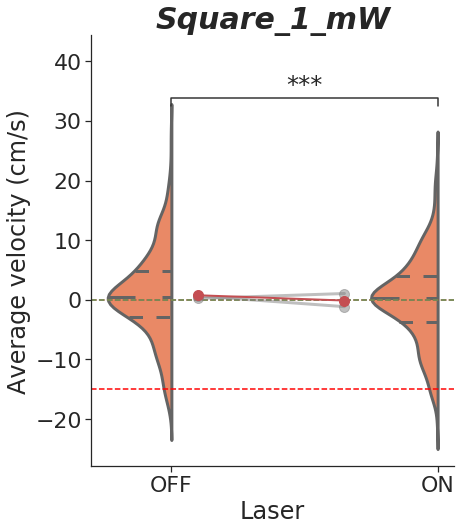

In [29]:

# path = "/Users/apple/Desktop/data_npz/"
folder = "Square_1_mW"
path = os.path.join(pre_direct,'data_npz',folder,'Control')
extension_summary = ".npz"
Summary_files_list = list_all_files(path,extension_summary)
col_names =  ['mean_velocity', 'mouse_type', 'optogenetic expression', 'pulse_type','intensity_mW','epoch']
result_Ctr = pd.DataFrame(columns = col_names)

# direct = pre_direct +mouse_type+'/'+opto_par+ '/Mouse_' +str(mouse_no)+ '/'  # directory to the folder for each mouse

on=[]
off=[]
for file in Summary_files_list:
    print(file)
    dat = npzfile = np.load(os.path.join(path,file))
    properties=file.split("_")
    epochs = dat[dat.files[0]]
    ## data for individual plot points of mice
    if properties[0]=='Vglut2':
        epochs_mean_mouse_Vglut2 = dat[dat.files[1]]
    if properties[0]=='D2':
        epochs_mean_mouse_D2 = dat[dat.files[1]]
    if properties[0]=='FoxP2':
        epochs_mean_mouse_FoxP2 = dat[dat.files[1]]
        
    pre = epochs[:,:pre_interval] ; post = epochs[:,pre_interval+1:pre_interval+interval+1]
    mouse_type_ = [properties[0]] * epochs.shape[0]*2
    opto_par_ = [properties[1]] * epochs.shape[0]*2
    pulse_ = [properties[2]] * epochs.shape[0]*2
    inten_ = [properties[3]] * epochs.shape[0]*2
    off_vel = np.average(pre,axis = 1)
    on_vel = np.average(post,axis = 1)
    all_ = np.concatenate((off_vel,on_vel),axis = 0)
    stat_result = stats.wilcoxon(off_vel, on_vel, zero_method='pratt', alternative='two-sided')
#     stat_result = stats.mannwhitneyu(off_vel, on_vel, alternative='two-sided')
    print(stat_result)
    print("shapiro :",stats.shapiro(off_vel-on_vel))
    print("OFF",np.average(off_vel),stats.sem(off_vel))
    print("ON",np.average(on_vel),stats.sem(on_vel))
    on = np.append(on,on_vel)
    off = np.append(off,off_vel)
    epoch_off = ['OFF'] * epochs.shape[0]
    epoch_on = ['ON'] * epochs.shape[0]
    epoch_ = epoch_off+epoch_on
    print(epochs.shape)
    df = pd.DataFrame(({'mean_velocity':all_, 
                        'mouse_type':mouse_type_, 'optogenetic expression':opto_par_, 'pulse_type':pulse_,
                        'intensity_mW':inten_,'epoch':epoch_}))
    frames = [result_Ctr, df]
    result_Ctr = pd.concat(frames,ignore_index=True)
    
print(result_Ctr.head())
stat_result = stats.wilcoxon(result_Ctr[result_Ctr['epoch']=='OFF']['mean_velocity'], 
                             result_Ctr[result_Ctr['epoch']=='ON']['mean_velocity'], zero_method='pratt', alternative='two-sided')
print("shapiro :",stats.shapiro(result_Ctr[result_Ctr['epoch']=='OFF']['mean_velocity']- 
                             result_Ctr[result_Ctr['epoch']=='ON']['mean_velocity']))
print('test',stats.wilcoxon(off, on, zero_method='pratt', alternative='two-sided'))
print('overall wilcoxon',stat_result)
import seaborn as sns
sns.set(font_scale = 2)

sns.set_style("white")


g = sns.catplot(x="epoch", y="mean_velocity",
                hue="optogenetic expression", 
                data=result_Ctr, kind="violin",  palette= ['coral'],
                height=4,  scale_hue=False,linewidth = 3, inner="quartile",split=True,scale ='area',width = 0.5,
                hue_order=['Control','ChR2'],legend = False, label='_nolegend_')
axes = g.axes.flatten()
add_stat_annotation(axes[0], data=result_Ctr,x="epoch", y="mean_velocity",hue="optogenetic expression",
                    box_pairs=[(("ON","Control"), ("OFF","Control"))],
                    test='Wilcoxon', text_format='star', loc='inside', verbose=2)
plt.axhline( y=0, ls='--', c='red')

x_series = [0.1,0.65]

plt.axhline( y=0, ls='--', c='g')
plt.axhline( y=treadmil_velocity, ls='--', c='red')

# plt.text(min(x_series), 30, 'D2-Cre', fontsize=22)
# for i in range (epochs_mean_mouse_D2.shape[0]):
#     plt1, = plt.plot(x_series,epochs_mean_mouse_D2[i,:2],'-',color = 'coral',marker = 'o',markersize=10,linewidth=2,alpha=0.4)
# plt1,=plt.plot(x_series,np.average(epochs_mean_mouse_D2[:,:2],axis =0),'.-',
#              color = 'darkorange',marker = '.',markersize=15,linewidth=3,alpha=1, label = 'D2-Cre')

# for i in range (epochs_mean_mouse_Vglut2.shape[0]):
#     plt2, = plt.plot(x_series,epochs_mean_mouse_Vglut2[i,:2],'-',color = 'steelblue',marker = 'o',markersize=10,linewidth=2,alpha=0.4)
# # plt2,=plt.plot(x_series,np.average(epochs_mean_mouse_Vglut2[:,:2],axis =0),'.-'
# #              ,color = 'darkblue',marker = '.',markersize=15,linewidth=3,alpha=1, label ='Vglut2')

for i in range (epochs_mean_mouse_FoxP2.shape[0]):
    plt3, = plt.plot(x_series,epochs_mean_mouse_FoxP2[i,:2],'-',color = 'grey',marker = 'o',markersize=10,linewidth=3,alpha=0.5)
# plt3,=plt.plot(x_series,np.average(epochs_mean_mouse_FoxP2[:,:2],axis =0),'.-'
#              ,color = 'darkgreen',marker = '.',markersize=15,linewidth=3,alpha=1,label = 'FoxP2-Cre')

# mean_mean = (np.average(epochs_mean_mouse_FoxP2[:,:2],axis =0)+np.average(epochs_mean_mouse_Vglut2[:,:2])+
#                np.average(epochs_mean_mouse_D2[:,:2],axis =0))/3
mean_mean = np.average(epochs_mean_mouse_Vglut2[:,:2],axis =0)
                          
plt4, = plt.plot(x_series,mean_mean,'-',color = 'r',marker = 'o',markersize=10,linewidth=2,alpha=1)

g.set_axis_labels("Laser", "Average velocity (cm/s)")

axes[0].get_xaxis().set_tick_params(direction='out')
axes[0].xaxis.set_ticks_position('bottom')
axes[0].get_yaxis().set_tick_params(direction='out')
axes[0].yaxis.set_ticks_position('left')

plt.title(folder).set_fontproperties(font)
g.fig.set_figwidth(10.0)
g.fig.set_figheight(10)
# plt.legend(handles=[plt1,plt2,plt3],labels=['D2-Cre','Vglut2','FoxP2-Cre'],loc = 'lower center',fontsize =15)
plt.savefig(os.path.join(path,folder+'_FoxP2_Control.pdf'),bbox_inches='tight',orientation='landscape',dpi=500)


In [22]:
mouse_type = 'D2'
ON_D2 = result_Ctr[(result_Ctr['mouse_type']==mouse_type) & (result_Ctr['epoch']=='ON')]['mean_velocity'] 
OFF_D2 = result_Ctr[(result_Ctr['mouse_type']==mouse_type) & (result_Ctr['epoch']=='OFF')]['mean_velocity'] 
print(ON_D2)
mouse_type = 'Vglut2'
ON_Vglut2 = result_Ctr[(result_Ctr['mouse_type']==mouse_type) & (result_Ctr['epoch']=='ON')]['mean_velocity'] 
OFF_Vglut2 = result_Ctr[(result_Ctr['mouse_type']==mouse_type) & (result_Ctr['epoch']=='OFF')]['mean_velocity'] 
print(ON_Vglut2)
mouse_type = 'FoxP2'
ON_FoxP2 = result_Ctr[(result_Ctr['mouse_type']==mouse_type) & (result_Ctr['epoch']=='ON')]['mean_velocity'] 
OFF_FoxP2 = result_Ctr[(result_Ctr['mouse_type']==mouse_type) & (result_Ctr['epoch']=='OFF')]['mean_velocity'] 
#df = pd.DataFrame(({'D2-ON':ON_D2.values,'D2-OFF':OFF_D2.values,'Vglut22-ON':ON_Vglut2.values,
#                    'Vglut22-OFF':OFF_Vglut2.values,'FoxP2-ON':ON_FoxP2.values,'FoxP2-OFF':OFF_FoxP2.values}))
df1 = pd.DataFrame(({'D2-ON':ON_D2.values,'D2-OFF':OFF_D2.values }))
df2 = pd.DataFrame(({'Vglut22-ON':ON_Vglut2.values,'Vglut22-OFF':OFF_Vglut2.values}))
df3 = pd.DataFrame(({'FoxP2-ON':ON_FoxP2.values,'FoxP2-OFF':OFF_FoxP2.values}))
datatoexcel = pd.ExcelWriter(pre_direct+'sum.xlsx',engine = 'xlsxwriter')
df1.to_excel(datatoexcel,sheet_name = 'Sheet1')
df2.to_excel(datatoexcel,sheet_name = 'Sheet2')
df3.to_excel(datatoexcel,sheet_name = 'Sheet3')
datatoexcel.save()
#df.to_csv(pre_direct+'sum.csv',index=False)

227    -0.940305
228    -5.136120
229    -2.639385
230    14.438407
231    18.438676
         ...    
449    -1.943511
450     1.807367
451     0.127015
452     0.072582
453     0.542743
Name: mean_velocity, Length: 227, dtype: float64
1058   -8.759184
1059   -5.606506
1060    2.044469
1061   -6.019322
1062   -9.405924
          ...   
1211    2.710242
1212   -6.115310
1213    0.687927
1214   -5.765207
1215   -3.643182
Name: mean_velocity, Length: 158, dtype: float64


## intensity = 1mW with Control

D2_ChR2_Square_HI_1_mov_aver.npz
(748, 501)
D2_Control_Square_HI_1.npz
(228, 501)
FoxP2_ChR2_Square_HI_1_mov_aver.npz
(711, 501)
FoxP2_Control_Square_HI_1.npz
(223, 501)
Vglut_ChR2_Square_HI_1_mov_aver.npz
(778, 501)
Vglut_Control_Square_HI_1.npz
(158, 501)


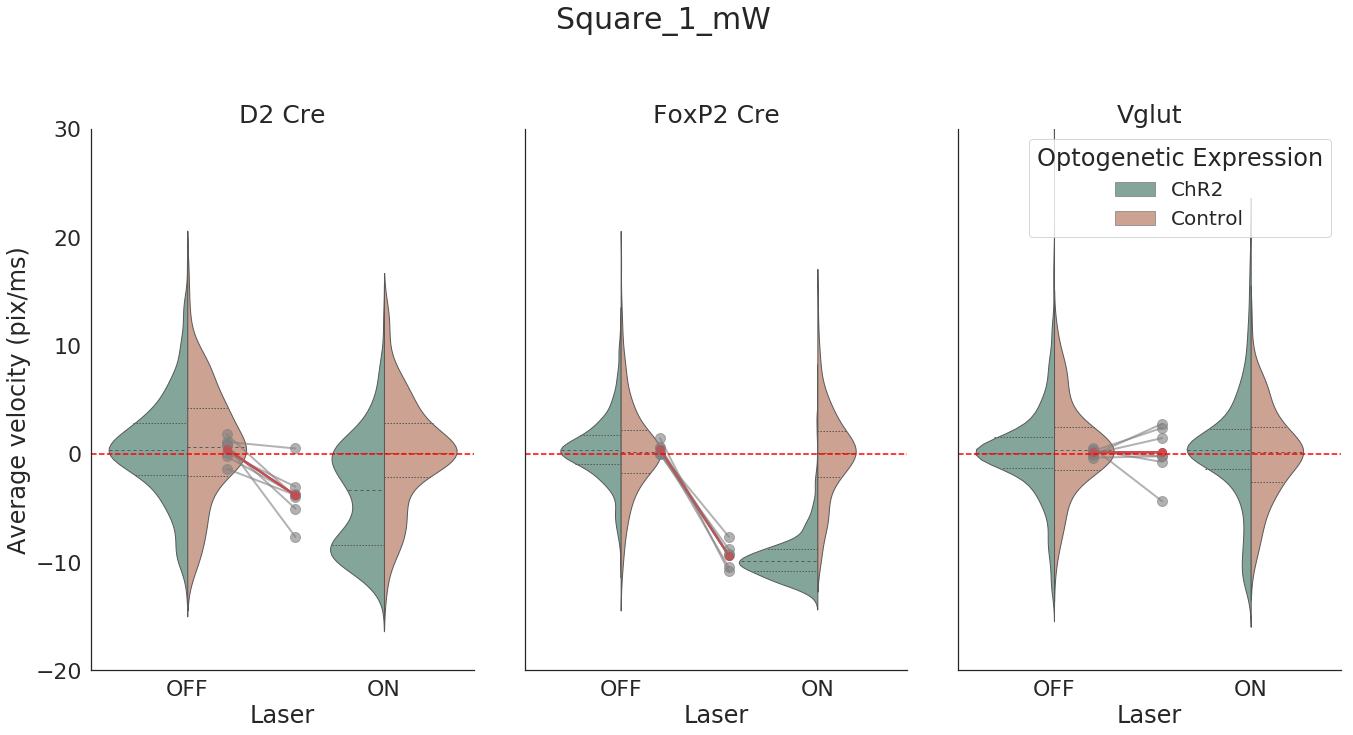

In [16]:

# path = "/Users/apple/Desktop/data_npz/"
folder = "Square_1_mW"
path = os.path.jion(pre_direct,'data_npz',folder)
extension_summary = ".npz"
Summary_files_list = list_all_files(path,extension_summary)
col_names =  ['mean_velocity', 'mouse_type', 'optogenetic expression', 'pulse_type','intensity_mW','epoch']
result = pd.DataFrame(columns = col_names)

# direct = pre_direct +mouse_type+'/'+opto_par+ '/Mouse_' +str(mouse_no)+ '/'  # directory to the folder for each mouse


for file in Summary_files_list:
    print(file)
    dat = npzfile = np.load(os.path.join(path,file))
    properties=file.split("_")
    epochs = dat[dat.files[0]]
    ## data for individual plot points of mice
    if properties[0]=='Vglut2' and properties[1] != 'Control':
        epochs_mean_mouse_Vglut2 = dat[dat.files[1]]
    if properties[0]=='D2'and properties[1] != 'Control':
        epochs_mean_mouse_D2 = dat[dat.files[1]]
    if properties[0]=='FoxP2'and properties[1] != 'Control':
        epochs_mean_mouse_FoxP2 = dat[dat.files[1]]
        
    pre = epochs[:,:pre_interval] ; post = epochs[:,pre_interval+1:pre_interval+interval+1]
    mouse_type_ = [properties[0]] * epochs.shape[0]*2
    opto_par_ = [properties[1]] * epochs.shape[0]*2
    pulse_ = [properties[2]] * epochs.shape[0]*2
#     intensity, data_type = properties[4].split('.')
    inten_ = [properties[4]] * epochs.shape[0]*2
    off_vel = np.average(pre,axis = 1)
    on_vel = np.average(post,axis = 1)
    all_ = np.concatenate((off_vel,on_vel),axis = 0)
    epoch_off = ['OFF'] * epochs.shape[0]
    epoch_on = ['ON'] * epochs.shape[0]
    epoch_ = epoch_off+epoch_on
    print(epochs.shape)
    df = pd.DataFrame(({'mean_velocity':all_, 
                        'mouse_type':mouse_type_, 'optogenetic expression':opto_par_, 'pulse_type':pulse_,
                        'intensity_mW':inten_,'epoch':epoch_}))
    frames = [result, df]
    result = pd.concat(frames,ignore_index=True)
result.head()

import seaborn as sns

sns.set_style("white")

g = sns.catplot(x="epoch", y="mean_velocity",
                hue="optogenetic expression", col="mouse_type",
                data=result, kind="violin", split=True, palette = sns.color_palette("Set2", n_colors=2, desat=.5),
                height=5, scale_hue=False, linewidth = 1, inner="quartile", scale = 'area',
                hue_order=['ChR2','Control'],col_order=['D2','FoxP2','Vglut2'],legend = False)
x_series = [0.2,0.55]
ax1, ax2, ax3 = g.axes[0]
for i in range (epochs_mean_mouse_Vglut2.shape[0]):
    ax3.plot(x_series,epochs_mean_mouse_Vglut2[i,:2],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
    ax3.plot(x_series,np.average(epochs_mean_mouse_Vglut2[:,:2],axis =0),'-',color = 'r',marker = '.',markersize=15,linewidth=2,alpha=0.6)

for i in range (epochs_mean_mouse_D2.shape[0]):
    ax1.plot(x_series,epochs_mean_mouse_D2[i,:2],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
    ax1.plot(x_series,np.average(epochs_mean_mouse_D2[:,:2],axis =0),'-',color = 'r',marker = '.',markersize=15,linewidth=2,alpha=0.6)

for i in range (epochs_mean_mouse_FoxP2.shape[0]):
    ax2.plot(x_series,epochs_mean_mouse_FoxP2[i,:2],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
    ax2.plot(x_series,np.average(epochs_mean_mouse_FoxP2[:,:2],axis =0),'-',color = 'r',marker = '.',markersize=15,linewidth=2,alpha=0.6)

sns.set(font_scale = 2)
sns.set_style("white")
plt.ylim([-20,30])
# plt.xlim([-2,2])
ax1, ax2, ax3 = g.axes[0]
ax1.axhline( y=0, ls='--', c='red')
ax2.axhline( y=0, ls='--', c='red')
ax3.axhline( y=0, ls='--', c='red')
ax1.set_title('D2 Cre', y=0.95, fontsize = 25)
ax2.set_title('FoxP2 Cre', y=0.95, fontsize = 25)
ax3.set_title('Vglut2', y=0.95, fontsize = 25)
g.set_axis_labels("Laser", "Average velocity (pix/ms)")
plt.suptitle(folder,fontsize= 30,y = 1)
g.fig.set_figwidth(20.0)
g.fig.set_figheight(12)
legend = plt.legend(loc='upper right', title='Optogenetic Expression',fontsize= 20)
plt.savefig(os.path.join(path,folder+'.pdf'),bbox_inches='tight',orientation='landscape',dpi=350)



## Intensity = 0.5 mW

D2_ChR2_Beta_0-5_mW_mov_aver.npz
D2_Control_Beta_0-5_mW_mov_aver.npz
FoxP2_ChR2_Beta_0-5_mW_mov_aver.npz
FoxP2_Control_Beta_0-5_mW_mov_aver.npz
VGlut_ChR2_Beta_0-5_mW_mov_aver.npz
VGlut_Control_Beta_0-5_mW_mov_aver.npz


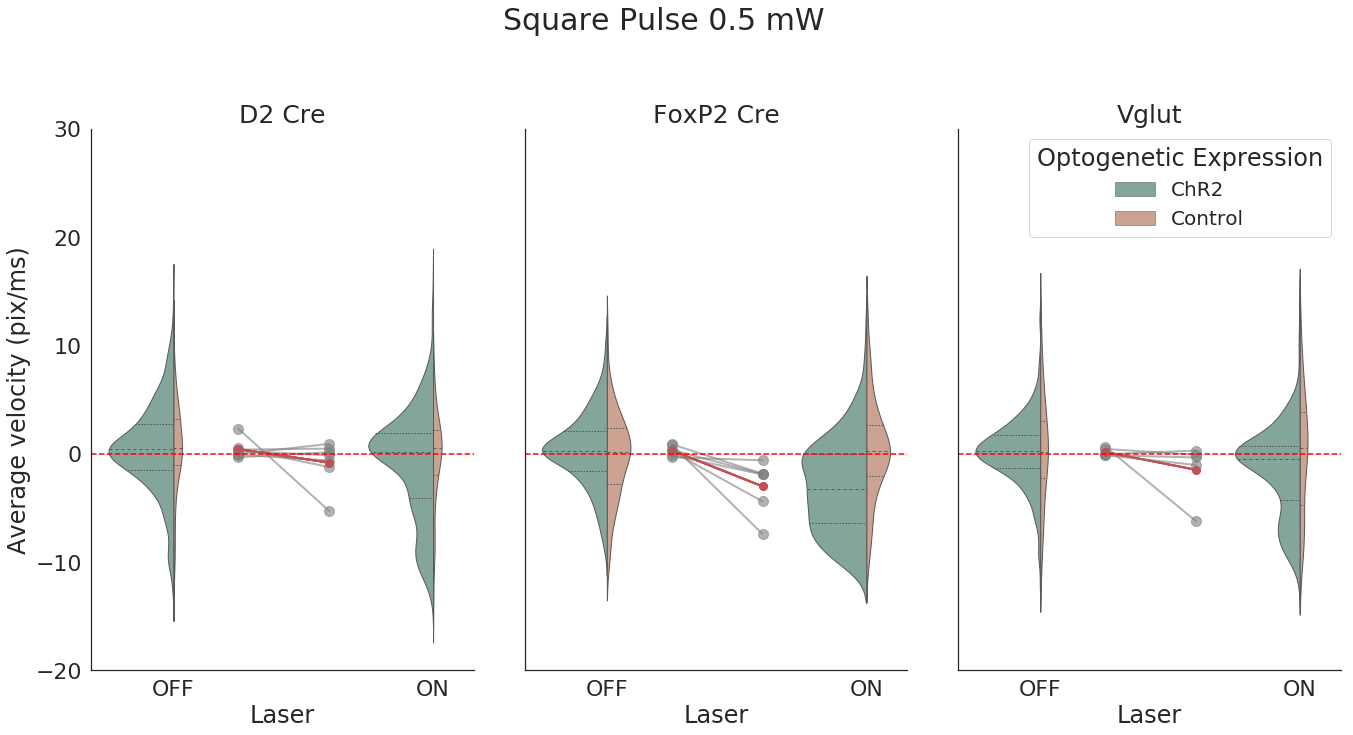

In [65]:
interval = 125 # number of timebins of stimulation 
fps = 250
pre_interval = int(.5*fps) # interval before laser onset
post_interval = int(.5*fps*2) # interval after laser onset

# path = "/Users/apple/Desktop/data_npz_mov_avg/"
path = os.path.join(pre_direct,'data_npz','BetaStim','0-5_mW')
extension = ".npz"
Summary_files_list = list_all_data_files(path,extension)
col_names =  ['mean_velocity', 'mouse_type', 'optogenetic expression', 'pulse_type','intensity_mW','epoch']
result = pd.DataFrame(columns = col_names)



for file in Summary_files_list:
    print(file)
    dat = npzfile = np.load(os.path.join(path,file))
    properties=file.split("_")
    epochs = dat[dat.files[0]]
    ## data for individual plot points of mice
    if properties[0]=='Vglut2' and properties[1] != 'Control':
        epochs_mean_mouse_Vglut2 = dat[dat.files[1]]
    if properties[0]=='D2'and properties[1] != 'Control':
        epochs_mean_mouse_D2 = dat[dat.files[1]]
    if properties[0]=='FoxP2'and properties[1] != 'Control':
        epochs_mean_mouse_FoxP2 = dat[dat.files[1]]
        
    pre = epochs[:,:pre_interval] ; post = epochs[:,pre_interval+1:pre_interval+interval+1]
    mouse_type_ = [properties[0]] * epochs.shape[0]*2
    opto_par_ = [properties[1]] * epochs.shape[0]*2
    pulse_ = [properties[2]] * epochs.shape[0]*2
    
    inten_ = [properties[3]] * epochs.shape[0]*2
    off_vel = np.average(pre,axis = 1)
    on_vel = np.average(post,axis = 1)
    all_ = np.concatenate((off_vel,on_vel),axis = 0)
    epoch_off = ['OFF'] * epochs.shape[0]
    epoch_on = ['ON'] * epochs.shape[0]
    epoch_ = epoch_off+epoch_on
    df = pd.DataFrame(({'mean_velocity':all_, 
                        'mouse_type':mouse_type_, 'optogenetic expression':opto_par_, 'pulse_type':pulse_,
                        'intensity_mW':inten_,'epoch':epoch_}))
    frames = [result, df]
    result = pd.concat(frames,ignore_index=True)
    
# print(result.head())
# plt.rcParams["axes.labelsize"] = 15
sns.set(font_scale = 2)
sns.set_style("white")
g = sns.catplot(x="epoch", y="mean_velocity",
                hue="optogenetic expression", col="mouse_type",
                data=result, kind="violin", split=True, palette = sns.color_palette("Set2", n_colors=2, desat=.5),
                height=5, scale_hue=False, linewidth = 1, inner="quartile",scale='count',
                hue_order=['ChR2','Control'],col_order=['D2','FoxP2','Vglut2'],legend=False,width=.5)


x_series = [0.25,0.6]
ax1, ax2, ax3 = g.axes[0]
for i in range (epochs_mean_mouse_Vglut2.shape[0]):
    ax3.plot(x_series,epochs_mean_mouse_Vglut2[i,:2],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
    ax3.plot(x_series,np.average(epochs_mean_mouse_Vglut2[:,:2],axis =0),'-',color = 'r',marker = '.',markersize=15,linewidth=2,alpha=0.6)

for i in range (epochs_mean_mouse_D2.shape[0]):
    ax1.plot(x_series,epochs_mean_mouse_D2[i,:2],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
    ax1.plot(x_series,np.average(epochs_mean_mouse_D2[:,:2],axis =0),'-',color = 'r',marker = '.',markersize=15,linewidth=2,alpha=0.6)

for i in range (epochs_mean_mouse_FoxP2.shape[0]):
    ax2.plot(x_series,epochs_mean_mouse_FoxP2[i,:2],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
    ax2.plot(x_series,np.average(epochs_mean_mouse_FoxP2[:,:2],axis =0),'-',color = 'r',marker = '.',markersize=15,linewidth=2,alpha=0.6)

# set(xlim=(0,2),ylim=(-20,30))
plt.ylim([-20,30])
ax1.axhline( y=0, ls='--', c='red');#ax1.axhline( y=-15, ls='--', c='red')
ax2.axhline( y=0, ls='--', c='red');#ax1.axhline( y=-15, ls='--', c='red')
ax3.axhline( y=0, ls='--', c='red');#ax1.axhline( y=-15, ls='--', c='red')
ax1.set_title('D2 Cre', y=0.95, fontsize = 25)
ax2.set_title('FoxP2 Cre', y=0.95, fontsize = 25)
ax3.set_title('Vglut2', y=0.95, fontsize = 25)
g.set_axis_labels("Laser", "Average velocity (pix/ms)")
plt.suptitle('Beta Stim 0.5 mW',fontsize= 30,y = 1)
g.fig.set_figwidth(20.0)
g.fig.set_figheight(12)
legend = plt.legend(loc='upper right', title='Optogenetic Expression',fontsize= 20)
plt.savefig(os.path.join(path,'plot_mov_avg_0-5_mW.png'),bbox_inches='tight',orientation='landscape',dpi=350)

# legend.get_title().set_fontsize('15') 

# Comparing the pre-on-post laser epoch average velocities

data_init = (287, 3)
(6, 3)


/home/shiva/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


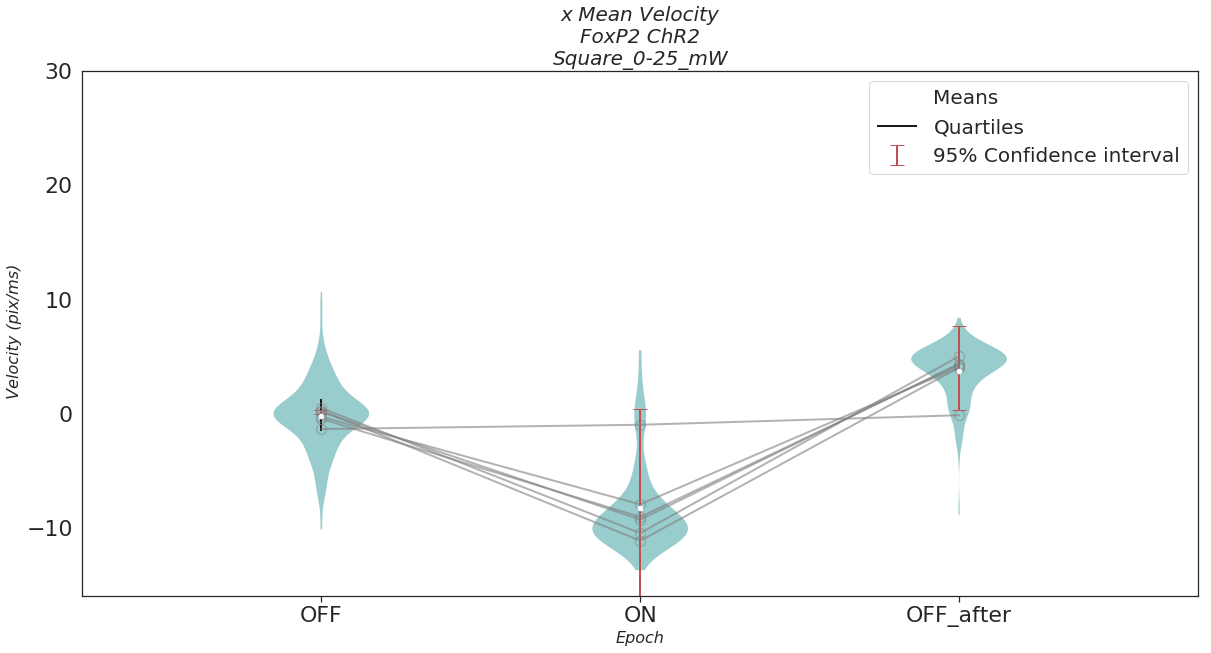

In [30]:
names = ['OFF','ON', 'OFF_after']
measure='Mean' #specify the measure for the ON-Laser Epoch
data_init = min_and_mean_on_off(epochs_all_mice,pre_interval,post_interval,interval,measure)
print('data_init =',data_init.shape)
violin_plot_summary(data_init,names,measure)
# plot_every_mouse_mean(epochs_mean_each_mouse)
plt.show()

# Plot the Pre Laser X Distribution

spont =n
 number of session = 2 out of 2
spont =n
 number of session = 2 out of 2
spont =n
 number of session = 2 out of 2
spont =n
 number of session = 2 out of 2
spont =n
 number of session = 2 out of 2
spont =n
 number of session = 2 out of 2


<Figure size 432x288 with 0 Axes>

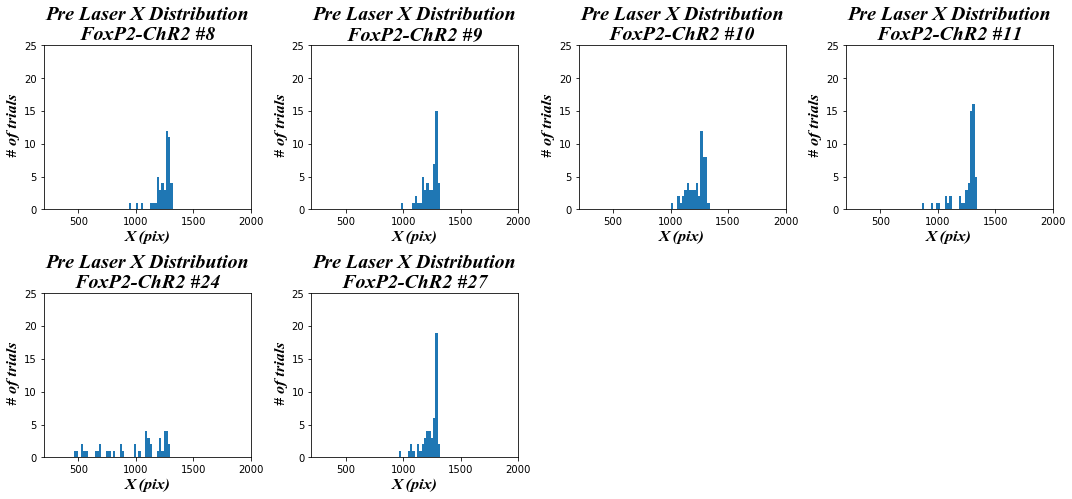

In [200]:
opto_par = 'ChR2'
# opto_par = 'Control'

## 1 mW intensity
folder = 'STR_Square_HI_1';  
# folder = 'STN_Square_HI_1'; #Vglut2 control folder's name
# folder = 'Square_HI_1';

## 0.5 mW intensity
folder = 'STR_Square_HI';  
# folder = 'STN_Square_HI'; #Vglut2 control folder's name
# folder = 'Square_HI';
# folder= 'Square_0-5_mW'

## 0.25 mW intensity
folder = 'Square_0-25_mW'

# mouse_type = 'Vglut2'
# mouse_type = 'D2';
mouse_type = 'FoxP2'
folder_spont = 'Spontaneous'

pre_stim_inter = 10 # number of timebins in the pre-stimulus period 
# n_bins = 45
plt.figure(2)
fig = plt.figure(figsize=(15,10))
count = 0
min_x =200
max_y = 25 ; max_x = 2000
step = 20
bins_list = np.arange(0,max_x,step)
for n in FoxP2_list[0][:]: # Run over all the mice
    count +=1
    start = timeit.default_timer()
    mouse_no = n
    direct = os.path.join(pre_direct, mouse_type, opto_par, 'Mouse_' +str(mouse_no)) # directory to the folder for each mouse

    files_list_DLC = list_all_files(os.path.join(direct,folder,'DLC'),extension)
    files_list_Laser = list_all_files(os.path.join(direct,folder,'Laser'),extension)

    pre_x_position_epochs = extract_pre_laser_x_epochs_over_trials(files_list_DLC,files_list_Laser,folder,'n', pre_stim_inter)
    pre_x_position = np.average(pre_x_position_epochs,axis = 1)
    
    x = fig.add_subplot(3,4,count)
    
    plt.hist(pre_x_position, bins=bins_list)
    plt.ylabel(" # of trials", fontproperties=font_label)
    plt.xlabel("X (pix)", fontproperties=font_label)
    plt.xlim(min_x,max_x) #set limits
    plt.ylim(0,max_y) #set limits
    plt.title("Pre Laser X Distribution"+"\n"+mouse_type+'-'+opto_par+' #'+str(mouse_no) , fontproperties=font)

plt.tight_layout()
plt.savefig(os.path.joijn(pre_direct,'Subplots','Pre_laser_X_distribution_'+folder+"_"+opto_par+'_'+mouse_type+'_' +
            '.png'),bbox_inches='tight',orientation='landscape',dpi=400)
plt.show()




# Plot one mouse

Select for which parts you want to see the pre/On/post: 

 1. Tail 
 2. Nose 
 3. Fore Limb 
 4. Hind Limb
1 2
 1. X 
 2. Y 
1
 1. Position 
 2. Velocity 
 
1
/home/shiva/Desktop/Shiva_Behavior/FoxP2/ChR2/Mouse_8/Square_0-5_mW_1_s
spont =n
 number of session = 1 out of 2
inconsistent right left =  0
# jitter in mean(righ,left)  =  1046
inconsistent right left =  239
# jitter in mean(righ,left)  =  2728
# discarded epochs = 9
 number of session = 2 out of 2
inconsistent right left =  0
# jitter in mean(righ,left)  =  1252
inconsistent right left =  178
# jitter in mean(righ,left)  =  2532
# discarded epochs = 3


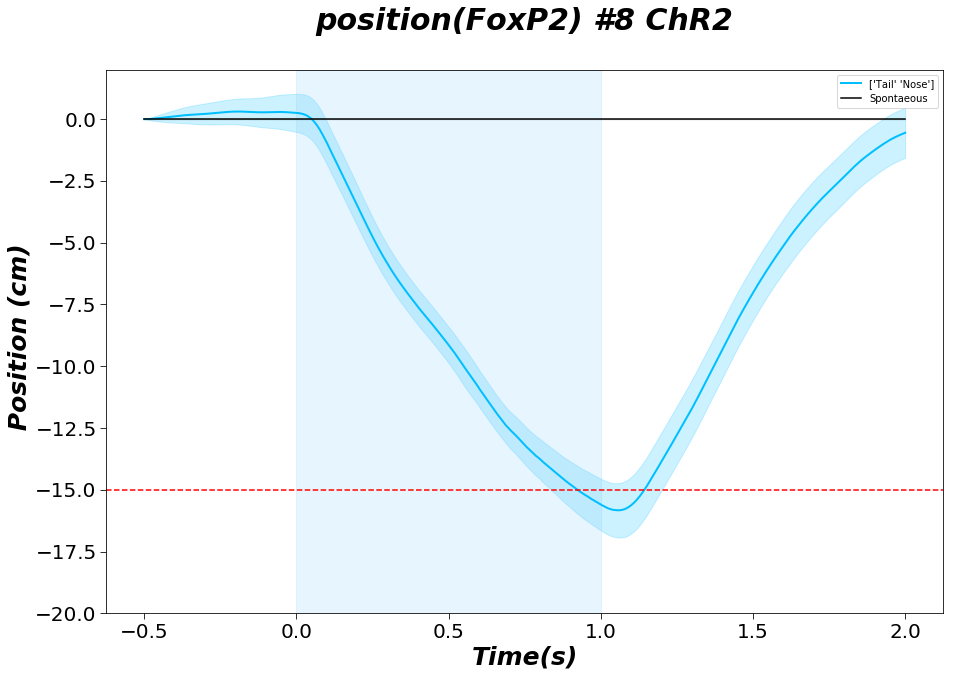

In [57]:
# where_plot,which_plot,what_plot = [1,2],0,1
where_plot,which_plot,what_plot = get_input_cor_body_part() # decide to average over what and coordinates
cor = cor_list[which_plot] # gets either x or y by user
# 

mouse_type= 'FoxP2';opto_par = "ChR2"; mouse_no = 8; spont = "n"; folder = "Square_0-5_mW_1_s"

if what_plot == 0:
    max_y_pre_post = 2; min_y_pre_post = -20
else :
    max_y_pre_post = 30; min_y_pre_post = -30
    
direct = os.path.join(pre_direct, mouse_type, opto_par, 'Mouse_' +str(mouse_no)) # directory to the folder for each mouse
print(direct+folder)


files_list_DLC = list_all_files(os.path.join(direct,folder,'DLC'),extension)
files_list_Laser = list_all_files(os.path.join(direct,folder,'Laser'),extension)

#One session
# epochs = extract_epochs_over_trials([files_list_DLC[0]],[files_list_Laser[0]],direct,folder,spont)

# All sessions 
epochs = extract_epochs_over_trials(files_list_DLC,files_list_Laser,direct,folder,spont,pre_interval,post_interval,interval)

epochs_spont = np.zeros(np.shape(epochs))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10), sharey=True)
# plot_pre_on_post(epochs[13,:],epochs_spont[10,:],average = 'n')
plot_pre_on_post(epochs,epochs_spont,average = 'n')



# Plot one laser stimulation

Select for which parts you want to see the pre/On/post: 

 1. Tail 
 2. Nose 
 3. Fore Limb 
 4. Hind Limb
1 2
 1. X 
 2. Y 
1
 1. Position 
 2. Velocity 
 
2
/home/shiva/Desktop/Shiva_Behavior/VGlut/ChR2/Mouse_116/Square_1_mW
spont =n
 number of session = 1 out of 1
inconsistent right left =  0
0
194
25.509239301286897
righ+left jitter =  1130
nan found? 0
inconsistent right left =  0
0
12
43.597898774344344
righ+left jitter =  1082
nan found? 0
# discarded epochs = 0


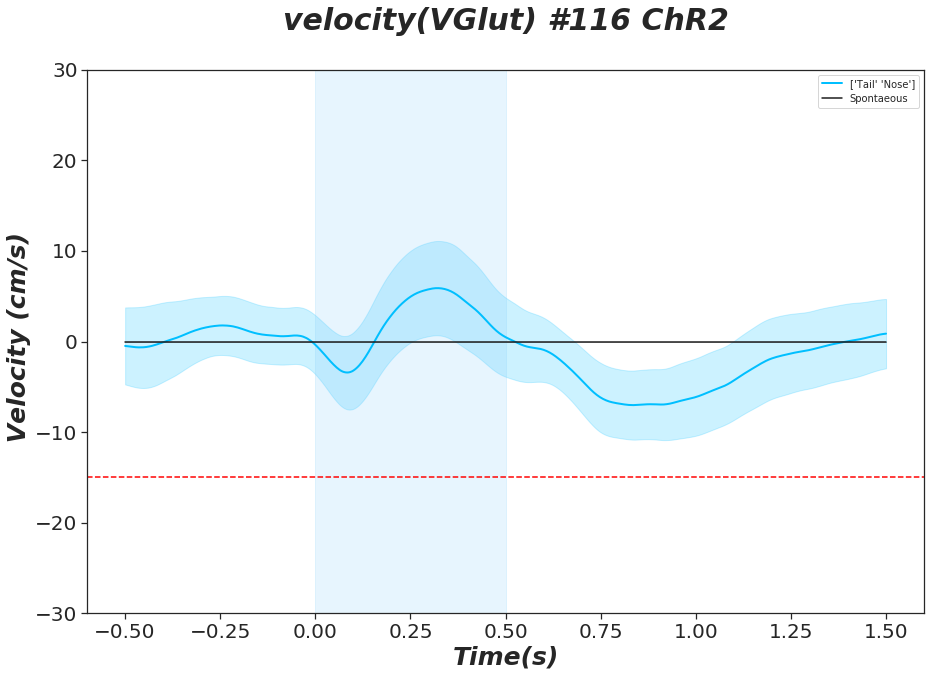

In [220]:
 return averaged_position

# where_plot,which_plot,what_plot = [1,2],0,1
where_plot,which_plot,what_plot = get_input_cor_body_part() # decide to average over what and coordinates
cor = cor_list[which_plot] # gets either x or y by user
# 
n_timebin = 30; window = 10; 
window_veloc = 5
max_accel = 95
mouse_type= 'Vglut2';opto_par = "ChR2"; mouse_no = 116; spont = "n"; folder = "Square_1_mW"

if what_plot == 0:
    max_y_pre_post = 20; min_y_pre_post = -30
else :
    max_y_pre_post = 30; min_y_pre_post = -30
    
direct = os.path.join(pre_direct, mouse_type, opto_par, 'Mouse_' +str(mouse_no))  # directory to the folder for each mouse
print(direct+folder)


files_list_DLC = list_all_files(os.path.join(direct,folder,'DLC'),extension)
files_list_Laser = list_all_files(os.path.join(direct,folder,'Laser'),extension)

epochs = extract_epochs_over_trials([files_list_DLC[0]],[files_list_Laser[0]],direct,folder,spont,pre_interval,post_interval,interval)
epochs_spont = np.zeros(np.shape(epochs))



what_plot = 1 # for velocity
pre_vel_epochs = extract_epochs_over_trials([files_list_DLC[0]],[files_list_Laser[0]],direct,folder,'n',pre_stim_inter,0,0)
#         pre_vel_epochs = extract_pre_laser_accel_epochs_over_trials(files_list_DLC,files_list_Laser,direct,folder, pre_stim_inter,n_timebin,window)
pre_vel = np.average(pre_vel_epochs[:,:pre_stim_inter],axis = 1)
print(pre_vel.shape)
ind_negative_accel = np.array(np.where(pre_vel < 0)).T
ind_negative_accel =  ind_negative_accel.reshape( ind_negative_accel.shape[0],)
ind_positive_accel = np.array(np.where(pre_vel>0)).T
ind_positive_accel =  ind_positive_accel.reshape( ind_positive_accel.shape[0],)
print("#positive accel={}".format(len(ind_positive_accel)))
print("#negative accel={}".format(len(ind_negative_accel)))
print(np.average(epochs[:pre_interval,:],axis = 1)[ind_negative_accel])
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10), sharey=True)
# plot_pre_on_post(epochs[13,:],epochs_spont[10,:],average = 'n')
# plot_pre_on_post(epochs,epochs_spont,average = 'n')
